In [1]:
import pdb
from math import floor,ceil
import random
from itertools import permutations
from collections import Counter

import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers

In [2]:
random_seed = 666

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=random_seed)

# kddcup-rootkit-imap_vs_back

## Pre

In [5]:
def read_data(filepath, atr_num):
    kddcup = pd.read_table(filepath, names=['Atr_' + str(i) for i in range(atr_num)], sep=',')
    kddcup['target'] = kddcup['Atr_'+ str(atr_num-1)] == 'positive'
    kddcup.drop(columns=['Atr_' + str(atr_num-1)], inplace=True)
    kddcup['target'] = kddcup['target'].astype(np.int0)
    X, y = kddcup[kddcup.columns[0:-1]], kddcup['target']
    imbalanced = Counter(y).items()
    k = list(imbalanced)[1][1]
    imbalanced_ratio = list(imbalanced)[0][1]//k
    print(imbalanced, 'Imbalanced Ratio:{}'.format(imbalanced_ratio))
    return kddcup, X, y, k

In [6]:
kddcup, X, y, k = read_data(filepath=r'kddcup-rootkit-imap_vs_back_data.txt', atr_num=42)

dict_items([(0, 2203), (1, 22)]) Imbalanced Ratio:100


In [7]:
kddcup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 42 columns):
Atr_0     2225 non-null int64
Atr_1     2225 non-null object
Atr_2     2225 non-null object
Atr_3     2225 non-null object
Atr_4     2225 non-null int64
Atr_5     2225 non-null int64
Atr_6     2225 non-null int64
Atr_7     2225 non-null int64
Atr_8     2225 non-null int64
Atr_9     2225 non-null int64
Atr_10    2225 non-null int64
Atr_11    2225 non-null int64
Atr_12    2225 non-null int64
Atr_13    2225 non-null int64
Atr_14    2225 non-null int64
Atr_15    2225 non-null int64
Atr_16    2225 non-null int64
Atr_17    2225 non-null int64
Atr_18    2225 non-null int64
Atr_19    2225 non-null int64
Atr_20    2225 non-null int64
Atr_21    2225 non-null int64
Atr_22    2225 non-null int64
Atr_23    2225 non-null int64
Atr_24    2225 non-null float64
Atr_25    2225 non-null float64
Atr_26    2225 non-null float64
Atr_27    2225 non-null float64
Atr_28    2225 non-null float64
Atr_29    

In [9]:
num = [i for i in kddcup.columns if kddcup[i].dtype!='O']
cat = [i for i in kddcup.columns if kddcup[i].dtype=='O']

In [10]:
for i in cat:
    print(i, ' contains ', len(kddcup[i].unique()), ' labels')

Atr_1  contains  2  labels
Atr_2  contains  6  labels
Atr_3  contains  6  labels


In [11]:
y = kddcup.target

In [12]:
x = pd.get_dummies(kddcup[cat])

In [13]:
kddcup.drop(kddcup[cat],axis = 1,inplace = True)

In [14]:
kddcup.drop(columns='target', inplace=True)

In [15]:
kddcup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 38 columns):
Atr_0     2225 non-null int64
Atr_4     2225 non-null int64
Atr_5     2225 non-null int64
Atr_6     2225 non-null int64
Atr_7     2225 non-null int64
Atr_8     2225 non-null int64
Atr_9     2225 non-null int64
Atr_10    2225 non-null int64
Atr_11    2225 non-null int64
Atr_12    2225 non-null int64
Atr_13    2225 non-null int64
Atr_14    2225 non-null int64
Atr_15    2225 non-null int64
Atr_16    2225 non-null int64
Atr_17    2225 non-null int64
Atr_18    2225 non-null int64
Atr_19    2225 non-null int64
Atr_20    2225 non-null int64
Atr_21    2225 non-null int64
Atr_22    2225 non-null int64
Atr_23    2225 non-null int64
Atr_24    2225 non-null float64
Atr_25    2225 non-null float64
Atr_26    2225 non-null float64
Atr_27    2225 non-null float64
Atr_28    2225 non-null float64
Atr_29    2225 non-null float64
Atr_30    2225 non-null float64
Atr_31    2225 non-null int64
Atr_32   

In [16]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
kddcup = scaler.fit_transform(kddcup)

In [17]:
kddcup = pd.DataFrame(kddcup)
x = pd.concat([x,kddcup],axis=1)

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

## 特征选择

### Rellief

In [19]:
def EuclideanDistances(A, B):
    BT = B.transpose()
    vecProd = np.dot(A,BT)
    SqA =  A**2
    sumSqA = np.matrix(np.sum(SqA, axis=1))
    sumSqAEx = np.tile(sumSqA.transpose(), (1, vecProd.shape[1]))

    SqB = B**2
    sumSqB = np.sum(SqB, axis=1)
    sumSqBEx = np.tile(sumSqB, (vecProd.shape[0], 1))
    SqED = sumSqBEx + sumSqAEx - 2*vecProd
    SqED[SqED<0]=0.0
    ED = np.sqrt(SqED)
    return ED

In [20]:
def relief_fit(features, labels, iter_ratio):

    (n_samples, n_features) = np.shape(features)
    distance = np.zeros((n_samples, n_samples))
    weight = np.zeros(n_features)

    distance = EuclideanDistances(features,features)

    # start iteration
    for iter_num in range(int(iter_ratio*n_samples)):

        nearHit, nearMiss, distance_sort = [], [], []

        # random select a sample
        index_i = random.randint(0, n_samples-1)
        self_features = features[index_i]

        # search for nearHit and nearMiss
        if iter_ratio >= 0.5:
            distance[index_i, index_i] = np.max(
                distance[index_i])     # filter self-distance
            for index in range(n_samples):
                distance_sort.append(
                    [distance[index_i, index], index, labels[index]])
        else:
            # compute distance respectively
            distance = np.zeros(n_samples)
            for index_j in range(n_samples):
                D_value = features[index_i] - features[index_j]
                distance[index_j] = np.linalg.norm(D_value, 2)
            distance[index_i] = np.max(distance)		# filter self-distance
            for index in range(n_samples):
                distance_sort.append([distance[index], index, labels[index]])
        distance_sort.sort(key=lambda x: x[0])
        for index in range(n_samples):
            if nearHit == [] and distance_sort[index][2] == labels[index_i]:
                # nearHit = distance_sort[index][1];
                nearHit = features[distance_sort[index][1]]
            elif nearMiss == [] and distance_sort[index][2] != labels[index_i]:
                # nearMiss = distance_sort[index][1]
                nearMiss = features[distance_sort[index][1]]
            elif nearHit != [] and nearMiss != []:
                break
            else:
                continue

        # update weight
        weight = weight - \
            np.power(self_features - nearHit, 2) + \
            np.power(self_features - nearMiss, 2)
    return weight/(iter_ratio*n_samples)

In [21]:
weight_relief = relief_fit(X_train.to_numpy(), y_train.to_numpy(), 0.7)

In [22]:
weight_relief

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.60513644e-03,
        1.00000000e+00,  9.85553772e-01,  0.00000000e+00,  8.02568218e-03,
        4.33386838e-02, -8.02568218e-04,  8.02568218e-04,  8.02568218e-04,
        4.09309791e-02,  0.00000000e+00,  1.82828812e+03,  2.77304884e+09,
        6.44522236e+07,  0.00000000e+00,  0.00000000e+00,  8.02568218e-03,
        3.85152488e+00,  0.00000000e+00,  9.87158909e-01,  1.10754414e+00,
        8.02568218e-03,  0.00000000e+00,  1.74959872e+00,  8.02568218e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  2.16573034e+00,  1.32767077e+01,  2.38290530e-03,
        2.21484751e-03,  1.89691814e-02,  1.26405485e+00,  6.42054575e-05,
        2.56821830e-04,  6.45833868e-02,  6.55058398e+00,  6.01832444e+00,
        9.28105939e-03,  3.85232745e-06,  3.73945425e+02, -1.60513644e-05,
        1.57211477e-01,  1.57211477e-01,  2.79321830e+01,  3.17845104e+01])

In [23]:
features_index = np.where(weight_relief > 0)[0]

In [24]:
features_index.shape

(35,)

In [25]:
weight_relief.shape

(52,)

### BPSO

In [116]:
class my_pso():
    def __init__(self,
                 feature_num,
                 c1=2,
                 c2=2,
                 particle_num=20,
                 wini=0.9,
                 wend=0.4,
                 gk=100,
                 velocity_max=1):
        self.c1 = c1
        self.c2 = c2
        self.particle_num = particle_num
        self.wini = wini
        self.wend = wend
        self.w = wini
        self.gk = gk
        self.velocity_max = velocity_max
        self.dim = feature_num

        # initialization particle
        self.particles = np.random.randint(low=0,
                                           high=2,
                                           size=(self.particle_num, self.dim))
        self.check_particles()
        self.velocities = np.random.randint(low=-1,
                                            high=2,
                                            size=(self.particle_num, self.dim))
        self.pbest = self.particles.copy()

    def check_particles(self):
        # 防止出现一个特征都不选的情况，即保证每一行不全为0
        index_0 = np.where(self.particles.sum(axis=-1) == 0)[0]
        if len(index_0) > 0:
            for index in index_0:
                a_sum = 0
                while a_sum == 0:
                    a = np.random.randint(low=0, high=2, size=(1, self.dim))
                    a_sum = a.sum()
                self.particles[index] = a

    def load_data(self, ori_data, data_target_resample, learner_id, base_learner):
        """
        data_target_resample是用来训练learner的数据，
        ori_data是用来调整BPSO的数据，该部分数据计算出的auc用来计算BPSO的适应度
        """
        if data_target_resample.shape[1] != ori_data.shape[1]:
            raise ValueError(
                'ori_data shape:{}\n data_target_resample shape:{}\n'.format(
                    ori_data.shape, data_target_resample.shape))
        if self.dim + 1 != data_target_resample.shape[1]:
            raise ValueError('feature_num:{}\n ori_data shape:{}\n'.format(
                self.dim, ori_data.shape))
        self.data_target_resample = data_target_resample
        self.ori_data = ori_data
        self.learner_id = learner_id
        self.base_learner = base_learner

    def fitness(self, individual):
        #         z = -20 * np.exp(
        #             -0.2 * np.sqrt(0.5 * np.sum(np.square(individual)))) - np.exp(
        #                 0.5 * (np.cos(2 * np.pi * individual[0]) +
        #                        np.cos(2 * np.pi * individual[1]))) + np.e + 20
        features_selected_index = np.r_[np.where(individual > 0)[0], -1]
        data_selected_feature = self.data_target_resample[:,
                                                          features_selected_index]
        ori_data_featured = self.ori_data[:, features_selected_index]
        auc = LEARNERS[self.learner_id](
            ori_data_featured,
            data_selected_feature,
            self.base_learner,
        )

        return 1 - auc

    def update(self, k):
        self.velocities = np.floor(self.w * self.velocities +
                                   (self.c1 * np.random.random() *
                                    (self.pbest - self.particles) +
                                    self.c2 * np.random.random() *
                                    (self.gbest - self.particles)))
        self.particles = np.array((self.particles + self.velocities) > 0,
                                  dtype=np.int)
        self.check_particles()
        self.w = (self.wini - self.wend) * (self.gk - k) / (self.gk +
                                                            self.wend)

    def solve(self):
        self.pbest_fitness = np.array(
            [self.fitness(item) for item in self.particles])
        self.gbest_fitness = np.min(self.pbest_fitness)
        self.gbest = self.particles[np.argmin(self.pbest_fitness)]
        for k in range(self.gk):
            if (k + 1) % 100 == 0:
                print(self.gbest_fitness, self.gbest)
            self.gbest_fitness = np.min(self.pbest_fitness)
            self.gbest = self.particles[np.argmin(self.pbest_fitness)]
            self.update(k)
            for i in range(self.particle_num):
                one_fitness = self.fitness(self.particles[i])
                if self.pbest_fitness[i] >= one_fitness:
                    self.pbest_fitness[i] = one_fitness
                    self.pbest[i] = self.particles[i]
        return self.gbest

## 集成

### 基分类器

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve

#### LR

In [ ]:
np.c_[data_target_resample[:, features_index], data_target_resample[:, -1]]

In [81]:
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train.to_numpy()[:, features_index], y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [83]:
y_pred = logreg.predict(X_test.to_numpy()[:, features_index])
y_prob = logreg.predict_proba(X_test.to_numpy()[:, features_index])[:,1]
print(accuracy_score(y_test, y_pred))
fpr, tpr, t = roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
print(auc)

0.9977528089887641
0.875


In [84]:
def plot_auc(fpr, tpr, auc):
    plt.figure()
    lw = 2
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange',         
             lw=lw, label='ROC curve (AUC = %0.2f)' % auc) 
    ###假正率为横坐标，真正率为纵坐标做曲线
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
#     plt.savefig(os.path.join(root, 'auc.png'))

### Bagging

In [27]:
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, BaseEnsemble,VotingClassifier

In [62]:
bagging_base_estimators = [
#     MLPClassifier(hidden_layer_sizes=(64), activation='relu', random_state=0,
#                   solver='sgd', alpha=1e-5, max_iter=500, early_stopping=True),
    DecisionTreeClassifier(
        criterion='gini', max_depth=14, random_state=8),
    ExtraTreeClassifier(criterion='gini', max_depth=15, random_state=8),
    LogisticRegression(random_state=0, C=1, tol = 1),
    SVC(C=0.1, kernel='linear', degree=3, gamma='auto_deprecated', probability=True, random_state=6),
    GaussianNB(var_smoothing=0.00001),
]

In [31]:
bagging_base_estimators = [
#     MLPClassifier(hidden_layer_sizes=(64), activation='relu', random_state=0,
#                   solver='sgd', alpha=1e-5, max_iter=500, early_stopping=True),
    DecisionTreeClassifier(
        criterion='gini', max_depth=14),
    ExtraTreeClassifier(criterion='gini', max_depth=15),
    LogisticRegression(C=1, tol = 1),
    SVC(C=0.1, kernel='linear', degree=3, gamma='auto_deprecated', probability=True,),
    GaussianNB(var_smoothing=0.00001),
]

In [34]:
# relief + bagging + averaging
for estimator in bagging_base_estimators:
    for train_index, test_index in kf.split(x):
        X_train = x.loc[train_index,:]
        y_train = y.loc[train_index]
        X_test = x.loc[test_index, :]
        y_test = y.loc[test_index]
        bagging = BaggingClassifier(base_estimator=estimator,
                                    n_estimators=10,
                                    max_samples=0.632,
                                    oob_score=True,
                                    random_state=0)
        print(bagging.base_estimator.__class__)
        bagging.fit(X=X_train.to_numpy()[:, features_index], y=y_train)

        y_pred = bagging.predict(X_test.to_numpy()[:, features_index])
        y_prob = bagging.predict_proba(X_test.to_numpy()[:, features_index])[:,1]
        print(accuracy_score(y_test, y_pred))
        fpr, tpr, t = roc_curve(y_test, y_pred)
        auc = metrics.auc(fpr, tpr)
        print(auc)

<class 'sklearn.tree.tree.DecisionTreeClassifier'>
1.0
1.0
<class 'sklearn.tree.tree.DecisionTreeClassifier'>
1.0
1.0
<class 'sklearn.tree.tree.DecisionTreeClassifier'>
1.0
1.0
<class 'sklearn.tree.tree.DecisionTreeClassifier'>
1.0
1.0
<class 'sklearn.tree.tree.DecisionTreeClassifier'>
1.0
1.0
<class 'sklearn.tree.tree.ExtraTreeClassifier'>
1.0
1.0
<class 'sklearn.tree.tree.ExtraTreeClassifier'>
1.0
1.0
<class 'sklearn.tree.tree.ExtraTreeClassifier'>
1.0
1.0
<class 'sklearn.tree.tree.ExtraTreeClassifier'>
1.0
1.0
<class 'sklearn.tree.tree.ExtraTreeClassifier'>
0.9977528089887641
0.9285714285714286
<class 'sklearn.linear_model.logistic.LogisticRegression'>
0.9910112359550561
0.9954648526077097
<class 'sklearn.linear_model.logistic.LogisticRegression'>
0.9955056179775281
0.9155277145026576
<class 'sklearn.linear_model.logistic.LogisticRegression'>
0.9910112359550561
0.8715986394557823
<class 'sklearn.linear_model.logistic.LogisticRegression'>
1.0
1.0
<class 'sklearn.linear_model.logistic

In [103]:
from sklearn.utils._joblib import Parallel, delayed
from sklearn.utils import check_array
from sklearn.utils.validation import has_fit_parameter, check_is_fitted
from sklearn.ensemble.base import _partition_estimators
from sklearn.ensemble.bagging import _parallel_predict_proba


class BaggingVote(BaggingClassifier):
    def predict_proba(self, X):
        """
        投票是否支持返回概率？
        该函数返回0或1
        """
        check_is_fitted(self, "classes_")
        # Check data
        X = check_array(X,
                        accept_sparse=['csr', 'csc'],
                        dtype=None,
                        force_all_finite=False)

        if self.n_features_ != X.shape[1]:
            raise ValueError("Number of features of the model must "
                             "match the input. Model n_features is {0} and "
                             "input n_features is {1}."
                             "".format(self.n_features_, X.shape[1]))

        # Parallel loop
        n_jobs, n_estimators, starts = _partition_estimators(
            self.n_estimators, self.n_jobs)

        self.all_proba = Parallel(
            n_jobs=n_jobs, verbose=self.verbose,
            **self._parallel_args())(delayed(_parallel_predict_proba)(
                self.estimators_[starts[i]:starts[i + 1]], self.
                estimators_features_[starts[i]:starts[i +
                                                      1]], X, self.n_classes_)
                                     for i in range(n_jobs))
        # majority voting
        maj = np.int64(
            self.all_proba >= (np.ones_like(self.all_proba) * 0.5 *
                               self.n_estimators))
        
        return np.squeeze(maj)

    def predict(self, X):
        """
        投票
        """
        return self.predict_proba(X)[:,1]

In [104]:
# relief + bagging + voting
for estimator in bagging_base_estimators:
    for train_index, test_index in kf.split(x):
        X_train = x.loc[train_index,:]
        y_train = y.loc[train_index]
        X_test = x.loc[test_index, :]
        y_test = y.loc[test_index]
        bagging_vote = BaggingVote(base_estimator=estimator,
                                    n_estimators=10,
                                    max_samples=0.632,
                                    oob_score=True,
                                    random_state=0)
        print(bagging_vote.base_estimator.__class__)
        bagging_vote.fit(X=X_train.to_numpy()[:, features_index], y=y_train)

        y_pred = bagging_vote.predict(X_test.to_numpy()[:, features_index])
        y_prob = bagging_vote.predict_proba(X_test.to_numpy()[:, features_index])[:,1]
        print(accuracy_score(y_test, y_pred))
        fpr, tpr, t = roc_curve(y_test, y_pred)
        auc = metrics.auc(fpr, tpr)
        print(auc)

<class 'sklearn.tree.tree.DecisionTreeClassifier'>
1.0
1.0
<class 'sklearn.tree.tree.DecisionTreeClassifier'>
1.0
1.0
<class 'sklearn.tree.tree.DecisionTreeClassifier'>
1.0
1.0
<class 'sklearn.tree.tree.DecisionTreeClassifier'>
1.0
1.0
<class 'sklearn.tree.tree.DecisionTreeClassifier'>
1.0
1.0
<class 'sklearn.tree.tree.ExtraTreeClassifier'>
1.0
1.0
<class 'sklearn.tree.tree.ExtraTreeClassifier'>
1.0
1.0
<class 'sklearn.tree.tree.ExtraTreeClassifier'>
1.0
1.0
<class 'sklearn.tree.tree.ExtraTreeClassifier'>
1.0
1.0
<class 'sklearn.tree.tree.ExtraTreeClassifier'>
1.0
1.0
<class 'sklearn.linear_model.logistic.LogisticRegression'>
0.9910112359550561
0.9954648526077097
<class 'sklearn.linear_model.logistic.LogisticRegression'>
0.9955056179775281
0.9155277145026576
<class 'sklearn.linear_model.logistic.LogisticRegression'>
0.9910112359550561
0.8715986394557823
<class 'sklearn.linear_model.logistic.LogisticRegression'>
1.0
1.0
<class 'sklearn.linear_model.logistic.LogisticRegression'>
0.988764

### Adaboost

In [35]:
from sklearn.ensemble import AdaBoostClassifier

In [36]:
boost_base_estimators = [
    DecisionTreeClassifier(
        criterion='gini', max_depth=14, random_state=8),
    ExtraTreeClassifier(criterion='gini', max_depth=15, random_state=8),
    LogisticRegression(random_state=0, C=1, tol = 1),
    SVC(C=0.1, kernel='linear', degree=3, gamma='auto_deprecated', probability=True, random_state=6),
    GaussianNB(var_smoothing=0.00001),
]

In [39]:
# relief + boosting 
for estimator in boost_base_estimators:
    for train_index, test_index in kf.split(x):
        X_train = x.loc[train_index,:]
        y_train = y.loc[train_index]
        X_test = x.loc[test_index, :]
        y_test = y.loc[test_index]
        boost = AdaBoostClassifier(base_estimator=estimator,
                                    n_estimators=10,
                                    learning_rate=1.0,
                                    algorithm='SAMME.R',
                                    random_state=0)
        print(boost.base_estimator.__class__)
        boost.fit(X=X_train.to_numpy()[:, features_index], y=y_train)

        y_pred = boost.predict(X_test.to_numpy()[:, features_index])
        y_prob = boost.predict_proba(X_test.to_numpy()[:, features_index])[:,1]
        print(accuracy_score(y_test, y_pred))
        fpr, tpr, t = roc_curve(y_test, y_pred)
        auc = metrics.auc(fpr, tpr)
        print(auc)

<class 'sklearn.tree.tree.DecisionTreeClassifier'>
1.0
1.0
<class 'sklearn.tree.tree.DecisionTreeClassifier'>
1.0
1.0
<class 'sklearn.tree.tree.DecisionTreeClassifier'>
1.0
1.0
<class 'sklearn.tree.tree.DecisionTreeClassifier'>
1.0
1.0
<class 'sklearn.tree.tree.DecisionTreeClassifier'>
1.0
1.0
<class 'sklearn.tree.tree.ExtraTreeClassifier'>
1.0
1.0
<class 'sklearn.tree.tree.ExtraTreeClassifier'>
1.0
1.0
<class 'sklearn.tree.tree.ExtraTreeClassifier'>
1.0
1.0
<class 'sklearn.tree.tree.ExtraTreeClassifier'>
1.0
1.0
<class 'sklearn.tree.tree.ExtraTreeClassifier'>
1.0
1.0
<class 'sklearn.linear_model.logistic.LogisticRegression'>
0.9977528089887641
0.875
<class 'sklearn.linear_model.logistic.LogisticRegression'>
1.0
1.0
<class 'sklearn.linear_model.logistic.LogisticRegression'>
1.0
1.0
<class 'sklearn.linear_model.logistic.LogisticRegression'>
1.0
1.0
<class 'sklearn.linear_model.logistic.LogisticRegression'>
0.9977528089887641
0.9988584474885845
<class 'sklearn.svm.classes.SVC'>
1.0
1.0
<

### BPSO+集成

In [121]:
def adaboost_bpso(
        data_target_resample,
        ori_data,
        base_learner,
):
    X_train = data_target_resample[:, :-1]
    y_train = data_target_resample[:, -1]
    X_test = ori_data[:, :-1]
    y_test = ori_data[:, -1]
    boost = AdaBoostClassifier(base_estimator=base_learner,
                               n_estimators=10,
                               learning_rate=1.0,
                               algorithm='SAMME.R',
                               random_state=0)
    boost.fit(X=X_train, y=y_train)

    y_pred = boost.predict(X_test)
    y_prob = boost.predict_proba(X_test)[:, 1]
    fpr, tpr, t = roc_curve(y_test, y_pred)
    auc = metrics.auc(fpr, tpr)
    return auc

In [122]:
def bagging_bpso(
        data_target_resample,
        ori_data,
        base_learner,
):
    X_train = data_target_resample[:, :-1]
    y_train = data_target_resample[:, -1]
    X_test = ori_data[:, :-1]
    y_test = ori_data[:, -1]
    bagging = BaggingClassifier(base_estimator=estimator,
                                n_estimators=10,
                                max_samples=0.632,
                                oob_score=True,
                                random_state=0)
    bagging.fit(X=X_train, y=y_train)

    y_pred = bagging.predict(X_test)
    y_prob = bagging.predict_proba(X_test)[:, 1]
    fpr, tpr, t = roc_curve(y_test, y_pred)
    auc = metrics.auc(fpr, tpr)
    return auc

In [135]:
def bagging_voting_bpso(
        data_target_resample,
        ori_data,
        base_learner,
):
    data_all_train = np.r_[data_target_resample, ori_data]
    X_train = data_all_train[:, :-1]
    y_train = data_all_train[:, -1]
    X_test = data_all_train[:, :-1]
    y_test = data_all_train[:, -1]
#     X_train = data_target_resample[:, :-1]
#     y_train = data_target_resample[:, -1]
#     X_test = ori_data[:, :-1]
#     y_test = ori_data[:, -1]
    bagging = BaggingClassifier(base_estimator=estimator,
                                n_estimators=10,
                                max_samples=0.632,
                                oob_score=True,
                                random_state=0)
    bagging.fit(X=X_train, y=y_train)

    y_pred = bagging.predict(X_test)
    y_prob = bagging.predict_proba(X_test)[:, 1]
    fpr, tpr, t = roc_curve(y_test, y_pred)
    auc = metrics.auc(fpr, tpr)
    return auc

In [136]:
LEARNERS = {
    0: bagging_bpso,
    1: adaboost_bpso,
    2: bagging_voting_bpso,
}

In [153]:
# BPSO + Bagging + averaging
for estimator in bagging_base_estimators:
    for train_index, test_index in kf.split(x):
        X_train = x.loc[train_index, :]
        y_train = y.loc[train_index]
        X_test = x.loc[test_index, :]
        y_test = y.loc[test_index]
        data_train = X_train.copy()
        data_train['target'] = y_train
        data_target_train_bpso, data_target_val_bpso = train_test_split(
            data_train, test_size=0.4)
        bpso = my_pso(feature_num=data_target_train_bpso.shape[1] - 1,
                      c1=2,
                      c2=2,
                      particle_num=10,
                      wini=0.9,
                      wend=0.4,
                      gk=100,
                      velocity_max=1)
        bpso.load_data(data_target_train_bpso.to_numpy(),
                       data_target_val_bpso.to_numpy(),
                       learner_id=0,
                       base_learner=estimator)
        gbest = bpso.solve()
        features_selected_index = np.r_[np.where(gbest > 0)[0], -1]
        bagging = BaggingClassifier(base_estimator=estimator,
                                    n_estimators=10,
                                    max_samples=0.632,
                                    oob_score=True,
                                    random_state=0)
        print(bagging.base_estimator.__class__)
        bagging.fit(X=X_train.to_numpy()[:, features_selected_index],
                    y=y_train)

        y_pred = bagging.predict(X_test.to_numpy()[:, features_selected_index])
        y_prob = bagging.predict_proba(
            X_test.to_numpy()[:, features_selected_index])[:, 1]
        print(accuracy_score(y_test, y_pred))
        fpr, tpr, t = roc_curve(y_test, y_pred)
        auc = metrics.auc(fpr, tpr)
        print(auc)

0.0 [1 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 1 0 0 1 1 1 1 1 0 1 0 1 1 1 0 0 0 1 0 0 0
 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1]
<class 'sklearn.tree.tree.DecisionTreeClassifier'>
1.0
1.0


KeyboardInterrupt: 

### feature_columns

In [7]:
feature_columns = []

for header in ['Atr_' + str(i) for i in [0, 4, 5, 9, 12, 15, 16, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]]:
    feature_columns.append(tf.feature_column.numeric_column(header))

cateforical_columns = [
    tf.feature_column.categorical_column_with_vocabulary_list(
        'Atr_1', ['icmp', 'tcp', 'udp']),
    tf.feature_column.categorical_column_with_vocabulary_file(
        'Atr_2', 'atr_2_vocabulary_file.txt'),
    tf.feature_column.categorical_column_with_vocabulary_list(
        'Atr_3', ['OTH', 'REJ', 'RSTO', 'RSTOS0', 'RSTR', 'S0', 'S1', 'S2', 'S3', 'SF', 'SH']),
    tf.feature_column.categorical_column_with_vocabulary_list('Atr_6', [0, 1]),
    tf.feature_column.categorical_column_with_vocabulary_list('Atr_7', [0, 1, 3]),
    tf.feature_column.categorical_column_with_vocabulary_list('Atr_8', [0, 1, 2, 3]),
    tf.feature_column.categorical_column_with_vocabulary_list('Atr_10', [0, 1, 2, 3, 4, 5]),
    tf.feature_column.categorical_column_with_vocabulary_list('Atr_11', [0, 1]),
    tf.feature_column.categorical_column_with_vocabulary_list('Atr_13', [0, 1]),
    tf.feature_column.categorical_column_with_vocabulary_list('Atr_14', [0, 1, 2]),
    tf.feature_column.categorical_column_with_vocabulary_list('Atr_17', [0,1,2]),
    tf.feature_column.categorical_column_with_vocabulary_list('Atr_18', [0,1,2,3,4,6,8]),
    tf.feature_column.categorical_column_with_vocabulary_list('Atr_19', [0]),
    tf.feature_column.categorical_column_with_vocabulary_list('Atr_20', [0]),
    tf.feature_column.categorical_column_with_vocabulary_list('Atr_21', [0,1]),
]

onehot_columns = [tf.feature_column.indicator_column(i) for i in cateforical_columns]

feature_columns.extend(onehot_columns)

## onehot

In [8]:
def get_onehot(X, feature_columns):
    feature_layer = layers.DenseFeatures(feature_columns)
    x_onehot = feature_layer(dict(X))
    _, column_num = x_onehot.shape.dims
    return x_onehot, column_num.value

In [9]:
X_onehot, columns_num = get_onehot(X, feature_columns)

W0307 15:54:28.614522  2688 deprecation.py:323] From d:\python\lib\site-packages\tensorflow\python\feature_column\feature_column_v2.py:2758: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0307 15:54:28.894772  2688 deprecation.py:323] From d:\python\lib\site-packages\tensorflow\python\feature_column\feature_column_v2.py:3774: to_int64 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0307 15:54:29.036391  2688 deprecation.py:323] From d:\python\lib\site-packages\tensorflow\python\feature_column\feature_column_v2.py:4307: IndicatorColumn._variable_shape (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W030

In [10]:
dataframe_onehot = pd.DataFrame(np.c_[X_onehot.numpy(), y])

In [11]:
postive_frame_onehot_all = dataframe_onehot[dataframe_onehot[dataframe_onehot.columns[-1]] == 1]
negative_frame_onehot_all = dataframe_onehot[dataframe_onehot[dataframe_onehot.columns[-1]] == 0]

In [12]:
postive_frame_onehot, postive_frame_onehot_vala = train_test_split(postive_frame_onehot_all, test_size=0.2)
negative_frame_onehot, negative_frame_onehot_vala = train_test_split(negative_frame_onehot_all, test_size=0.2)
postive_frame_onehot_val, postive_frame_onehot_test = train_test_split(postive_frame_onehot_vala, test_size=0.5)
negative_frame_onehot_val, negative_frame_onehot_test = train_test_split(negative_frame_onehot_vala, test_size=0.5)

In [13]:
data_train = np.r_[postive_frame_onehot, negative_frame_onehot]
data_val = np.r_[postive_frame_onehot_val, negative_frame_onehot_val]
data_test = np.r_[postive_frame_onehot_test, negative_frame_onehot_test]

## over sampling

In [16]:
all_minority_sample_with_target = postive_frame_onehot.copy()

### SMOTE

In [12]:
def my_smote(minority_numpy, newsample_num=None):
    length_minority, dim_minority = minority_numpy.shape
    newsample_num = newsample_num if newsample_num else length_minority
    dist = np.zeros((length_minority, length_minority))
    dist_access = np.zeros_like(dist)
    newsample = np.zeros((length_minority, dim_minority))
    for i in range(0, length_minority):
        for j in range(0, length_minority):
            a = minority_numpy[i,:] 
            b = minority_numpy[j,:]
            a = np.linalg.norm(a)
            dist[i, j] = a
    for i in range(0, length_minority):
        loops = 0
        k = 5
        B = np.zeros((k, 1))
        while loops < k:
            p = 10000
            for j in range(0, length_minority):
                if dist_access[i, j] == 0 and i != j:
                    if dist[i, j] < p:
                        p = dist[i, j]
                        p1, p2 = i, j
            dist_access[p1, p2] = 1
            B[loops , 0] = p2
            loops += 1
        choose1 = floor(k * np.random.rand())
        choose2 = int(B[choose1, 0])
        c = np.random.rand()
        for j in range(0, dim_minority):
            newsample[i, j] = minority_numpy[choose2, j] + \
                (minority_numpy[i, j] - minority_numpy[choose2, j])*c
    all_minority_sample = np.r_[newsample, minority_numpy]
    all_minority_sample_with_target = np.c_[all_minority_sample, np.ones(length_minority+newsample_num)]
    return all_minority_sample_with_target

In [13]:
all_minority_sample_with_target = my_smote(postive_frame_onehot.to_numpy()[:,0:-1])
k = len(all_minority_sample_with_target)

## under sampling

### kmeans

In [17]:
from sklearn.cluster import KMeans

def cluster_under_sample(negative_frame_onehot, k=len(postive_frame_onehot)):
    kmeans = KMeans(n_clusters=k, max_iter=300, random_state=random_seed)
    kmeans.fit(negative_frame_onehot[negative_frame_onehot.columns[0:-1]])
    return kmeans.cluster_centers_

### near miss

In [18]:
from imblearn.under_sampling import NearMiss

Using TensorFlow backend.


In [19]:
def nm3_under_sample(k, negative_frame_onehot):
    pass

### Random

In [20]:
def random_under_sample(negative_frame_onehot, k=len(postive_frame_onehot)):
    if isinstance(negative_frame_onehot, pd.core.frame.DataFrame):
        negative_frame_onehot = negative_frame_onehot.to_numpy()
    length = len(negative_frame_onehot)
    index = np.random.choice(range(length), k, replace=False)
#     pdb.set_trace()
    return negative_frame_onehot[index, 0:-1]

In [21]:
UNDER_SAMPLE = {
    0: cluster_under_sample,
    1: random_under_sample,
}

### merge postive and negative

In [22]:
new_negative = cluster_under_sample(negative_frame_onehot)

In [23]:
data_target_resample = np.r_[np.c_[new_negative, np.zeros(len(new_negative))], all_minority_sample_with_target]

## feature select

### Relief

In [24]:
def simple_distance(x):
    n_samples = len(x)
    distance = np.zeros((n_samples, n_samples))
    for index_i in range(n_samples):
        for index_j in range(index_i+1, n_samples):
            D_value = x[index_i] - x[index_j]
            distance[index_i, index_j] = np.linalg.norm(D_value, 2)
    distance += distance.T
    return distance

In [25]:
def EuclideanDistances(A, B):
    BT = B.transpose()
    vecProd = np.dot(A,BT)
    SqA =  A**2
    sumSqA = np.matrix(np.sum(SqA, axis=1))
    sumSqAEx = np.tile(sumSqA.transpose(), (1, vecProd.shape[1]))

    SqB = B**2
    sumSqB = np.sum(SqB, axis=1)
    sumSqBEx = np.tile(sumSqB, (vecProd.shape[0], 1))
    SqED = sumSqBEx + sumSqAEx - 2*vecProd
    SqED[SqED<0]=0.0
    ED = np.sqrt(SqED)
    return ED

In [26]:
%timeit simple_dis = simple_distance(X_onehot.numpy())

29.1 s ± 1.33 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
%timeit ED = EuclideanDistances(X_onehot.numpy(),X_onehot.numpy())

184 ms ± 6.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
%timeit cdist_time = cdist(X_onehot.numpy(),X_onehot.numpy())

781 ms ± 26.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
def relief_fit(features, labels, iter_ratio):

    (n_samples, n_features) = np.shape(features)
    distance = np.zeros((n_samples, n_samples))
    weight = np.zeros(n_features)

    distance = EuclideanDistances(features,features)

    # start iteration
    for iter_num in range(int(iter_ratio*n_samples)):

        nearHit, nearMiss, distance_sort = [], [], []

        # random select a sample
        index_i = random.randint(0, n_samples-1)
        self_features = features[index_i]

        # search for nearHit and nearMiss
        if iter_ratio >= 0.5:
            distance[index_i, index_i] = np.max(
                distance[index_i])     # filter self-distance
            for index in range(n_samples):
                distance_sort.append(
                    [distance[index_i, index], index, labels[index]])
        else:
            # compute distance respectively
            distance = np.zeros(n_samples)
            for index_j in range(n_samples):
                D_value = features[index_i] - features[index_j]
                distance[index_j] = np.linalg.norm(D_value, 2)
            distance[index_i] = np.max(distance)		# filter self-distance
            for index in range(n_samples):
                distance_sort.append([distance[index], index, labels[index]])
        distance_sort.sort(key=lambda x: x[0])
        for index in range(n_samples):
            if nearHit == [] and distance_sort[index][2] == labels[index_i]:
                # nearHit = distance_sort[index][1];
                nearHit = features[distance_sort[index][1]]
            elif nearMiss == [] and distance_sort[index][2] != labels[index_i]:
                # nearMiss = distance_sort[index][1]
                nearMiss = features[distance_sort[index][1]]
            elif nearHit != [] and nearMiss != []:
                break
            else:
                continue

        # update weight
        weight = weight - \
            np.power(self_features - nearHit, 2) + \
            np.power(self_features - nearMiss, 2)
    return weight/(iter_ratio*n_samples)

In [28]:
weight_relief = relief_fit(data_target_resample[:,:-1], data_target_resample[:,-1], 0.7)

## Learners

### BP

In [29]:
from sklearn.neural_network import MLPClassifier

In [65]:
def bp_classifier(ori_data, data_selected_feature, test_data=None, test_split=0.2, train=True):

    mlp = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', random_state=random_seed,
                        solver='adam', alpha=1e-5, max_iter=200, early_stopping=True)
    
    if train:
#         train_data, test_data = train_test_split(
#             data_selected_feature, test_size=test_split, random_state=random_seed)
#         mlp.fit(X=train_data[:, :-1], y=train_data[:, -1])
        mlp.fit(X=data_selected_feature[:, :-1], y=data_selected_feature[:, -1])

        y_prob = mlp.predict_proba(ori_data[:, 0:-1])[:, 1]
        y_pred = mlp.predict(ori_data[:, 0:-1]).flatten()
        if test_data is not None:
            y_prob_test = mlp.predict_proba(test_data[:, 0:-1])[:, 1]
            y_pred_test = mlp.predict(test_data[:, 0:-1]).flatten()
            return y_prob, y_pred, y_prob_test, y_pred_test

        return y_prob, y_pred
    else:
        return mlp

### Decision tree

In [31]:
from sklearn.tree import DecisionTreeClassifier

In [66]:
def decision_tree(ori_data, data_selected_feature, test_data=None, test_split=0.2, train=True):

    dtc = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=random_seed)
    if train:
#         train_data, test_data = train_test_split(
#             data_selected_feature, test_size=test_split, random_state = random_seed)
#         dtc.fit(X=train_data[:, :-1], y=train_data[:, -1])
        dtc.fit(X=data_selected_feature[:, :-1], y=data_selected_feature[:, -1])

        y_prob = dtc.predict_proba(ori_data[:, 0:-1])[:, 1]
        y_pred = dtc.predict(ori_data[:, 0:-1]).flatten()
        if test_data is not None:
            y_prob_test = dtc.predict_proba(test_data[:, 0:-1])[:, 1]
            y_pred_test = dtc.predict(test_data[:, 0:-1]).flatten()
            return y_prob, y_pred, y_prob_test, y_pred_test

        return y_prob, y_pred
    else:
        return dtc

### ExtraTree

In [33]:
from sklearn.tree import ExtraTreeClassifier

In [67]:
def extra_tree(ori_data, data_selected_feature, test_data=None, test_split=0.2, train=True):

    etc = ExtraTreeClassifier(criterion='gini', max_depth=5, random_state=random_seed)
    if train:
#         train_data, test_data = train_test_split(
#             data_selected_feature, test_size=test_split, random_state=random_seed)
#         etc.fit(X=train_data[:, :-1], y=train_data[:, -1])
        etc.fit(X=data_selected_feature[:, :-1], y=data_selected_feature[:, -1])

        y_prob = etc.predict_proba(ori_data[:, 0:-1])[:, 1]
        y_pred = etc.predict(ori_data[:, 0:-1]).flatten()
        if test_data is not None:
            y_prob_test = etc.predict_proba(test_data[:, 0:-1])[:, 1]
            y_pred_test = etc.predict(test_data[:, 0:-1]).flatten()
            return y_prob, y_pred, y_prob_test, y_pred_test

        return y_prob, y_pred
    else:
        return etc

### svm

In [35]:
from sklearn import svm

In [68]:
def svm_classifier(ori_data, data_selected_feature, test_data=None, test_split=0.2, train=True):

    svm_c = svm.SVC(C=1.0, kernel='rbf', gamma='auto_deprecated',
                    tol=0.001, probability=True, random_state=random_seed)
    if train:
#         train_data, test_data = train_test_split(
#             data_selected_feature, test_size=test_split, random_state = random_seed)
#         svm_c.fit(X=train_data[:, :-1], y=train_data[:, -1])
        svm_c.fit(X=data_selected_feature[:, :-1], y=data_selected_feature[:, -1])

        y_prob = svm_c.predict_proba(ori_data[:, 0:-1])[:, 1]
        y_pred = svm_c.predict(ori_data[:, 0:-1]).flatten()
        if test_data is not None:
            y_prob_test = svm_c.predict_proba(test_data[:, 0:-1])[:, 1]
            y_pred_test = svm_c.predict(test_data[:, 0:-1]).flatten()
            return y_prob, y_pred, y_prob_test, y_pred_test

        return y_prob, y_pred
    else:
        return svm_c

### logic 

In [37]:
from sklearn.linear_model import LogisticRegression

In [69]:
def lr_classifier(ori_data, data_selected_feature, test_data=None, test_split=0.2, train=True):

    lr = LogisticRegression(random_state=random_seed)
    if train:
#         train_data, test_data = train_test_split(
#             data_selected_feature, test_size=test_split, random_state = random_seed)
#         lr.fit(X=train_data[:, :-1], y=train_data[:, -1])
        lr.fit(X=data_selected_feature[:, :-1], y=data_selected_feature[:, -1])

        y_prob = lr.predict_proba(ori_data[:, 0:-1])[:, 1]
        y_pred = lr.predict(ori_data[:, 0:-1]).flatten()
        if test_data is not None:
            y_prob_test = lr.predict_proba(test_data[:, 0:-1])[:, 1]
            y_pred_test = lr.predict(test_data[:, 0:-1]).flatten()
            return y_prob, y_pred, y_prob_test, y_pred_test

        return y_prob, y_pred
    else:
        return lr

### knn

In [39]:
from sklearn.neighbors import KNeighborsClassifier

In [70]:
def knn_classifier(ori_data, data_selected_feature, test_data=None, test_split=0.2, train=True):
    
    knn = KNeighborsClassifier(n_neighbors=5)
    if train:

#         train_data, test_data = train_test_split(
#             data_selected_feature, test_size=test_split, random_state = random_seed)

#         knn.fit(X=train_data[:,:-1], y=train_data[:,-1])
        knn.fit(X=data_selected_feature[:, :-1], y=data_selected_feature[:, -1])

        y_prob = knn.predict_proba(ori_data[:, 0:-1])[:,1]
        y_pred = knn.predict(ori_data[:, 0:-1]).flatten()
        if test_data is not None:
            y_prob_test = knn.predict_proba(test_data[:, 0:-1])[:, 1]
            y_pred_test = knn.predict(test_data[:, 0:-1]).flatten()
            return y_prob, y_pred, y_prob_test, y_pred_test

        return y_prob, y_pred
    else:
        return knn

### Gaussian Naive Bayes

In [41]:
from sklearn.naive_bayes import GaussianNB

In [71]:
def gnb_classifier(ori_data, data_selected_feature, test_data=None, test_split=0.2, train=True):
    
    gnb = GaussianNB()
    if train:

#         train_data, test_data = train_test_split(
#             data_selected_feature, test_size=test_split, random_state=random_seed)

#         gnb.fit(X=train_data[:,:-1], y=train_data[:,-1])
        gnb.fit(X=data_selected_feature[:, :-1], y=data_selected_feature[:, -1])

        y_prob = gnb.predict_proba(ori_data[:, 0:-1])[:,1]
        y_pred = gnb.predict(ori_data[:, 0:-1]).flatten()
        if test_data is not None:
            y_prob_test = gnb.predict_proba(test_data[:, 0:-1])[:, 1]
            y_pred_test = gnb.predict(test_data[:, 0:-1]).flatten()
            return y_prob, y_pred, y_prob_test, y_pred_test

        return y_prob, y_pred
    else:
        return gnb

### RandomForest

In [43]:
from sklearn.ensemble import RandomForestClassifier

def rf_classifier(ori_data, data_selected_feature, test_split=0.2, train=True):
    
    rf = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=random_seed)
    if train:

#         train_data, test_data = train_test_split(
#             data_selected_feature, test_size=test_split, random_state=random_seed)

#         rf.fit(X=train_data[:,:-1], y=train_data[:,-1])
        rf.fit(X=data_selected_feature[:, :-1], y=data_selected_feature[:, -1])

        y_prob = rf.predict_proba(ori_data[:, 0:-1])[:,1]
        y_pred = rf.predict(ori_data[:, 0:-1]).flatten()

        return y_prob, y_pred
    else:
        return rf

### GradientBoosting

In [44]:
from sklearn.ensemble import GradientBoostingClassifier

def gbt_classifier(ori_data, data_selected_feature, test_split=0.2, train=True):
    gb = GradientBoostingClassifier(n_estimators=10, max_depth=5, random_state=random_seed)
    if train:

#         train_data, test_data = train_test_split(
#             data_selected_feature, test_size=test_split, random_state=random_seed)
#         gb.fit(X=train_data[:,:-1], y=train_data[:,-1])
        gb.fit(X=data_selected_feature[:, :-1], y=data_selected_feature[:, -1])

        y_prob = gb.predict_proba(ori_data[:, 0:-1])[:,1]
        y_pred = gb.predict(ori_data[:, 0:-1]).flatten()

        return y_prob, y_pred
    else:
        return gb

In [72]:
LEARNERS = {
    0: gnb_classifier,
    1: decision_tree,
    2: extra_tree,
    3: svm_classifier,
    4: lr_classifier,
    5: rf_classifier,
    6: gbt_classifier,
}

## metrics

In [46]:
def get_gmean(y_true, y_pred, beta):
    if y_true.shape != y_pred.shape:
        raise ValueError("y_true must have same shape with y_pred")
    length = len(y_true)
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(length):
        if y_pred[i]:
            if y_true[i]:
                tp += 1
            else:
                fp += 1
        else:
            if y_true[i]:
                fn += 1
            else:
                tn += 1
    pred_postive = tp + fp
    pred_postive = pred_postive if pred_postive else 1
    tp = tp if tp else 1e-6
    precision = tp / pred_postive
    tpr = recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    fbeta = (1 + beta**2) * precision * recall / (beta**2 * precision + recall)
    fpr = fp / (tn + fp)
    tnr = tn/(tn+fp)
    g_mean = np.sqrt(recall * tnr)
    return g_mean, recall, tnr, fbeta, precision

In [47]:
def get_auc(y_true, y_pred):
    auc = keras.metrics.AUC()
    auc.update_state(y_true, y_pred)
    return auc.result().numpy()

In [48]:
from sklearn.metrics import roc_curve

def plot_roc(y_true, y_pred):
    fpr, tpr, thresh = roc_curve(y_true, y_pred)
    plt.figure(figsize=(5, 5))
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.plot(fpr, tpr)
    plt.savefig('roc.png')

### 基学习器评价

In [49]:
def test_learner(ori_data=data_val, data_selected_feature=data_target_resample, learner_id=1):
    y_prob, y_pred = LEARNERS[learner_id](
        ori_data, data_target_resample, test_split=0.2)
    y_true = ori_data[:, -1]
    g_mean, recall, tnr, fbeta, precision = get_gmean(y_true, y_pred, beta=1)
    print('g_mean:{}\n recall:{}\n tnr:{}\n fbeta:{}\n precision:{}\n'.format(
        g_mean, recall, tnr, fbeta, precision ))
    plot_roc(y_true, y_pred)
    return g_mean

g_mean:0.9095453409658736
 recall:1.0
 tnr:0.8272727272727273
 fbeta:0.09523809523809523
 precision:0.05



0.9095453409658736

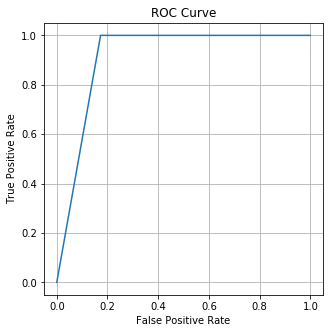

In [115]:
# 随机森林
test_learner(learner_id=5)

g_mean:0.9414688716912718
 recall:1.0
 tnr:0.8863636363636364
 fbeta:0.13793103448275862
 precision:0.07407407407407407



0.9414688716912718

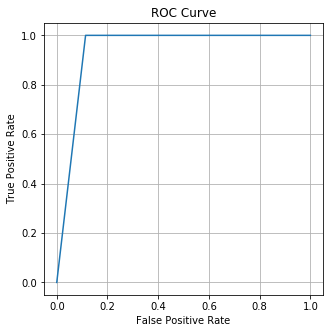

In [108]:
# 梯度提升树
test_learner(learner_id=6)

g_mean:0.9095453409658736
 recall:1.0
 tnr:0.8272727272727273
 fbeta:0.09523809523809523
 precision:0.05



0.9095453409658736

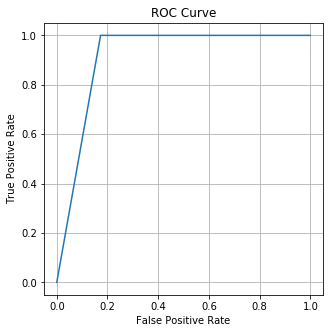

In [114]:
test_learner(learner_id=5)

## ensemble rule

In [50]:
def averaging(y_probs, y_preds):
    '''
    输入各个体学习器预测的概率值，返回平均之后的预测值(0或1)
    '''
    return np.array(np.average(y_probs, axis=1) >= 0.5, dtype=np.int)

In [51]:
def voting(y_probs, y_preds):
    '''
    输入各个学习器预测的概率值，返回投票后的预测值
    '''
    # 二分类问题可以用平均值
    return np.array(np.average(y_preds, axis=1) >= 0.5, dtype=np.int)

In [52]:
ENSEMBLE_RULE = {
    0: voting,
    1: averaging,
}

## Bagging+Tree

In [53]:
def mybagging(data_target_resample, ori_data, bootstrap_num=9):
    length_data, dim_data = data_target_resample.shape
    length_ori = len(ori_data)
    fin = np.zeros((length_ori, bootstrap_num))
    for i in range(bootstrap_num):
        length_newsample = ceil(0.632 * length_data)
        newsamples = np.zeros((length_newsample, dim_data))
        C = np.random.permutation(length_data)
        for j in range(0, length_newsample):
            newsamples[j, :] = data_target_resample[C[j], :]

        # Decision Tree
        dtc = DecisionTreeClassifier()
        dtc.fit(X=newsamples[:, 0:-1], y=newsamples[:, -1])
        fin[:, i] = dtc.predict(X=ori_data[:, 0:-1])
    final = np.zeros((length_ori, 1))
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(0, length_ori):
        vote_negative, vote_postive = 0, 0
        for j in range(0, bootstrap_num):
            if fin[i, j] == 0:
                vote_negative += 1
            else:
                vote_postive += 1
        final[i, 0] = 0 if vote_negative > vote_postive else 1
    g_mean, recall, tnr, fbeta, precision = get_gmean(ori_data[:, -1],
                                                      final[:, 0],
                                                      beta=1)
    auc = get_auc(ori_data[:, -1], final[:, 0])
    print('g_mean:{}\n tnr:{}\n recall:{}\n AUC:{}\n fbeta:{}\n precision:{}'.format(
        g_mean, tnr, recall, auc, fbeta, precision))

In [73]:
def mybagging_new(data_target_resample,
                  ori_data,
                  learner_id,
                  test_data=None,
                  bootstrap_num=9,
                  test_split=0.2):
    length_data, dim_data = data_target_resample.shape
    length_ori = len(ori_data)
    y_probs = np.zeros((length_ori, bootstrap_num))
    y_preds = np.zeros((length_ori, bootstrap_num))
    if test_data is not None:
        y_probs_test = np.zeros((len(test_data), bootstrap_num))
        y_preds_test = np.zeros((len(test_data), bootstrap_num))
    else:
        test_data = ori_data.copy()
        y_probs_test = y_probs.copy()
        y_preds_test = y_preds.copy()
    for i in range(bootstrap_num):
        length_newsample = ceil(0.632 * length_data)
        newsamples = np.zeros((length_newsample, dim_data))
        C = np.random.permutation(length_data)
        for j in range(0, length_newsample):
            newsamples[j, :] = data_target_resample[C[j], :]

        # 基学习器
        y_probs[:, i], y_preds[:, i], y_probs_test[:,i], y_preds_test[:, i] = LEARNERS[learner_id](
            ori_data, data_target_resample, test_data=test_data, test_split=0.2)
    return y_probs, y_preds, y_probs_test, y_preds_test

## Adaboosting

In [74]:
def myadaboost(data_target_resample,
               ori_data,
               learner_id,
               test_data=None,
               bootstrap_num=9,
               test_split=0.2):

#     train_data, test_data = train_test_split(data_target_resample,
#                                              test_size=test_split)

    clf = AdaBoostClassifier(base_estimator=LEARNERS[learner_id](
        data_target_resample, ori_data, train=False),
                             n_estimators=50,
                             learning_rate=1.0,
                             algorithm='SAMME')
    #     pdb.set_trace()
    clf.fit(X=data_target_resample[:, :-1], y=data_target_resample[:, -1])

    y_prob = clf.predict_proba(ori_data[:, 0:-1])[:, 1]
    y_pred = clf.predict(ori_data[:, 0:-1]).flatten()
    if test_data is not None:
        y_prob_test = clf.predict_proba(test_data[:,0:-1])[:, 1]
        y_pred_test = clf.predict(test_data[:, 0:-1]).flatten()
        return y_prob, y_pred, y_prob_test, y_pred_test
    return y_prob, y_pred

In [56]:
y_prob, y_pred = myadaboost(data_train, data_val, learner_id=4)

In [57]:
get_auc(y_pred, data_val[:,-1])

0.9977376

In [54]:
import inspect
from sklearn.utils.testing import all_estimators
for name, clf in all_estimators(type_filter='classifier'):
    try:
        if 'sample_weight' in inspect.getargspec(clf().fit)[0]:
            print(name)
    except:
        print(clf)

AdaBoostClassifier
BaggingClassifier
BernoulliNB
CalibratedClassifierCV
<class 'sklearn.multioutput.ClassifierChain'>
ComplementNB
DecisionTreeClassifier
DummyClassifier
ExtraTreeClassifier
ExtraTreesClassifier
GaussianNB
GradientBoostingClassifier
LinearSVC
LogisticRegression
LogisticRegressionCV
<class 'sklearn.multioutput.MultiOutputClassifier'>
MultinomialNB
NuSVC
<class 'sklearn.multiclass.OneVsOneClassifier'>
<class 'sklearn.multiclass.OneVsRestClassifier'>
<class 'sklearn.multiclass.OutputCodeClassifier'>
Perceptron
RandomForestClassifier
RidgeClassifier
RidgeClassifierCV
SGDClassifier
SVC
<class 'sklearn.ensemble.voting.VotingClassifier'>


## bpso

In [58]:
class my_pso():
    def __init__(self, feature_num, c1=2, c2=2, particle_num=20,
                 wini=0.9, wend=0.4, gk=100, velocity_max=1):
        self.c1 = c1
        self.c2 = c2
        self.particle_num = particle_num
        self.wini = wini
        self.wend = wend
        self.w = wini
        self.gk = gk
        self.velocity_max = velocity_max
        self.dim = feature_num

        # initialization particle
        self.particles = np.random.randint(low=0,
                                           high=2,
                                           size=(self.particle_num, self.dim))
        self.check_particles()
        self.velocities = np.random.randint(low=-1,
                                            high=2,
                                            size=(self.particle_num, self.dim))
        self.pbest = self.particles.copy()
        
    def check_particles(self):
        # 防止出现一个特征都不选的情况，即保证每一行不全为0
        index_0= np.where(self.particles.sum(axis=-1)==0)[0]
        if len(index_0) > 0:
            for index in index_0:
                a_sum = 0
                while a_sum==0:
                    a = np.random.randint(low=0, high=2, size=(1, self.dim))
                    a_sum = a.sum()
                self.particles[index] = a

    def load_data(self, ori_data, data_target_resample, learner_id):
        if data_target_resample.shape[1] != ori_data.shape[1]:
            raise ValueError('ori_data shape:{}\n data_target_resample shape:{}\n'.format(
                ori_data.shape, data_target_resample.shape))
        if self.dim+1 != data_target_resample.shape[1]:
            raise ValueError('feature_num:{}\n ori_data shape:{}\n'.format(
                self.dim, ori_data.shape))
        self.data_target_resample = data_target_resample
        self.ori_data = ori_data
        self.learner_id = learner_id

    def fitness(self, individual):
        #         z = -20 * np.exp(
        #             -0.2 * np.sqrt(0.5 * np.sum(np.square(individual)))) - np.exp(
        #                 0.5 * (np.cos(2 * np.pi * individual[0]) +
        #                        np.cos(2 * np.pi * individual[1]))) + np.e + 20
        features_selected_index = np.r_[np.where(individual > 0)[0], -1]
        data_selected_feature = self.data_target_resample[:,
                                                          features_selected_index]
        ori_data_featured = self.ori_data[:, features_selected_index]
        y_prob, y_pred = LEARNERS[self.learner_id](
            ori_data_featured, data_selected_feature, test_split=0.2)
        auc = get_auc(ori_data_featured[:, -1], y_pred)

        return 1-auc

    def update(self, k):
        self.velocities = np.floor(self.w*self.velocities + (self.c1 * np.random.random() *
                                                             (self.pbest - self.particles) +
                                                             self.c2 * np.random.random() *
                                                             (self.gbest - self.particles)))
        self.particles = np.array(
            (self.particles + self.velocities) > 0, dtype=np.int)
        self.check_particles()
        self.w = (self.wini-self.wend) * (self.gk - k)/(self.gk + self.wend)

    def solve(self):
        self.pbest_fitness = np.array(
            [self.fitness(item) for item in self.particles])
        self.gbest_fitness = np.min(self.pbest_fitness)
        self.gbest = self.particles[np.argmin(self.pbest_fitness)]
        for k in range(self.gk):
            if (k+1) % 100 == 0:
                print(self.gbest_fitness, self.gbest)
            self.gbest_fitness = np.min(self.pbest_fitness)
            self.gbest = self.particles[np.argmin(self.pbest_fitness)]
            self.update(k)
            for i in range(self.particle_num):
                one_fitness = self.fitness(self.particles[i])
                if self.pbest_fitness[i] >= one_fitness:
                    self.pbest_fitness[i] = one_fitness
                    self.pbest[i] = self.particles[i]
        return self.gbest

In [59]:
bpso = my_pso(feature_num=data_target_resample.shape[1]-1, c1=2, c2=2, particle_num=10,
              wini=0.9, wend=0.4, gk=100, velocity_max=1)
bpso.load_data(dataframe_onehot.to_numpy(), data_target_resample, 2)

In [130]:
%time a = bpso.solve()

0.0 [1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 1 1 0 1 0 1 1
 1 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0 0 0 1 0 0 0
 0 0 0]
Wall time: 18.4 s


## DE

In [146]:
class DEalgorithm():
    def __init__(self, iternum, dim, xmin, xmax, population, CR, F):
        if dim != len(xmin):
            raise ValueError('xmin must have {} columns'.format(dim))
        self.dim = dim
        self.iternum = iternum
        self.xmin = xmin
        self.xmax = xmax
        self.population = population
        self.CR = CR
        self.F = F  # 取值0~2，通常0.5
        # 种群初始化
        self.X = np.floor(
            np.array([
                xmin + (np.random.rand(dim) * (xmax - xmin))
                for i in range(population)
            ]))

    def load_data(self, ori_data, negative_frame_onehot,
                  all_minority_sample_with_target, test_data):
        self.ori_data = ori_data
        self.negative_frame_onehot = negative_frame_onehot
        self.all_minority_sample_with_target = all_minority_sample_with_target
        self.data_test = test_data

    def fitness(self, individual, test=False):
        #     z = -20 * np.exp(-0.2 * np.sqrt(0.5*np.sum(np.square(individual)))) - np.exp(
        #         0.5*(np.cos(2*np.pi*individual[0]) + np.cos(2*np.pi*individual[1]))) + np.e + 20
        length_ori = len(self.ori_data)
        k = len(self.all_minority_sample_with_target)
        learner_num = 3
        print(individual, end='\n')
        # 欠采样
        new_negative = UNDER_SAMPLE[individual[0]](
            self.negative_frame_onehot, k=k)
        data_target_resample = np.r_[
            np.c_[new_negative, np.zeros(len(new_negative))], self.
            all_minority_sample_with_target]

        # 特征选择
        if individual[1] == 0:
            weight_relief = relief_fit(data_target_resample[:, 0:-1],
                                       data_target_resample[:, -1], 0.7)
            features_index = np.where(np.abs(weight_relief) > 0)[0]
        elif individual[1] == 1:
            bpso = my_pso(feature_num=data_target_resample.shape[1]-1, c1=2, c2=2, particle_num=10,
                          wini=0.9, wend=0.4, gk=100, velocity_max=1)
            bpso.load_data(self.ori_data, data_target_resample,
                           learner_id=individual[3])
            features_index = np.r_[bpso.solve(), -1]

        data_selected_feature = np.c_[
            data_target_resample[:, features_index],
            data_target_resample[:, -1]]
        ori_data_featured = np.c_[self.ori_data[:, features_index], self.
                                  ori_data[:, -1]]
        test_data_featured = np.c_[
            self.test_data[:, features_index], self.test_data[:, -1]]

        # 集成方法
        if individual[2] == 0:
            # 基分类器
            y_probs = np.zeros((length_ori, learner_num))
            y_preds = np.zeros_like(y_probs)
            for i in range(learner_num):
                y_probs[:, i], y_preds[:, i] = LEARNERS[individual[3]](
                    ori_data_featured, data_selected_feature, test_split=0.2)
        elif individual[2] == 1:
            y_probs, y_preds = mybagging_new(data_selected_feature,
                                             ori_data_featured,
                                             learner_id=individual[3],
                                             bootstrap_num=learner_num,
                                             test_split=0.2)
        elif individual[2] == 2:

            y_prob, y_pred = myadaboost(data_selected_feature,
                                        ori_data_featured,
                                        learner_id=individual[3],
                                        bootstrap_num=learner_num,
                                        test_split=0.2)
            g_mean, recall, tnr, fbeta, precision = get_gmean(self.ori_data[:, -1],
                                                              y_pred,
                                                              beta=1)
            auc = get_auc(self.ori_data[:, -1], y_pred)
            print('\033[0;31;46m{}\033[0m'.format(individual))
            print(
                'g_mean:{}\n tnr:{}\n recall:{}\n AUC:{}\n fbeta:{}\n precision:{}'
                .format(g_mean, tnr, recall, auc, fbeta, precision))
            return 1 - auc

        # 集成规则
        y_final_pred = ENSEMBLE_RULE[individual[4]](y_probs, y_preds)

        g_mean, recall, tnr, fbeta, precision = get_gmean(self.ori_data[:, -1],
                                                          y_final_pred,
                                                          beta=1)
        auc = get_auc(self.ori_data[:, -1], y_final_pred)
        plot_roc(self.ori_data[:, -1], y_final_pred)
        print(
            'g_mean:{}\n tnr:{}\n recall:{}\n AUC:{}\n fbeta:{}\n precision:{}'
            .format(g_mean, tnr, recall, auc, fbeta, precision))

        return 1 - auc

    def mutation(self):
        self.mutations = []
        for i in range(self.population):
            r1 = r2 = r3 = 0
            while r1 == i or r2 == i or r3 == i or r2 == r1 or r3 == r1 or r3 == r2:
                # 随机数范围为[0,size-1]的整数
                r1 = random.randint(0, self.population - 1)
                r2 = random.randint(0, self.population - 1)
                r3 = random.randint(0, self.population - 1)


#                 pdb.set_trace()
            x_mutation = np.floor(
                np.abs(self.X[r1] + self.F * (self.X[r2] - self.X[r3])))
            for j in range(self.dim):
                #  判断变异后的值是否满足边界条件，不满足需重新生成
                while not (self.xmin[j] <= x_mutation[j] < self.xmax[j]):
                    rand_value = self.xmin[j] + \
                        random.random() * (self.xmax[j] - self.xmin[j])
                    x_mutation[j] = floor(rand_value)
            self.mutations.append(x_mutation)
        self.mutations = np.array(self.mutations)

    def crossover(self):
        self.children = np.zeros_like(self.mutations)
        for i in range(self.population):
            for j in range(self.dim):
                rand_float = random.random()
                rand_j = random.randint(0, self.dim - 1)
                if rand_float <= self.CR or rand_j == j:
                    self.children[i, j] = self.mutations[i, j]
                else:
                    self.children[i, j] = self.X[i, j]

    def selection(self):
        for i in range(self.population):
            if self.fitness(self.X[i]) >= self.fitness(self.children[i]):
                self.X[i] = self.children[i]
                if self.fitness(self.X[i]) <= self.fitness(self.X_best):
                    self.X_best = self.X[i]
                    self.best_fitness = self.fitness(self.X_best)

    def get_best_fitness(self):
        self.best_fitness = float('inf')
        for i in range(self.population):
            individual_fitness = self.fitness(self.X[i])
            if individual_fitness < self.best_fitness:
                self.X_best = self.X[i]
                self.best_fitness = individual_fitness

    def solve(self):
        self.get_best_fitness()
        #         pdb.set_trace()
        for i in range(self.iternum):
            self.mutation()
            self.crossover()
            self.selection()
            if i % 1 == 0:
                print('\033[0;31;46m{}:{}\033[0m'.format(i, self.X_best))
                print(self.best_fitness)

In [147]:
de = DEalgorithm(5, 5, np.array([0, 0,0,0,0]),
                 np.array([2,2,3,5,2]), 6, 0.8, 0.5)
de.load_data(data_val, negative_frame_onehot, all_minority_sample_with_target)

[1. 1. 1. 0. 0.]
0.0 [0 1 0 0 1 0 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1 0 1 0 1 0 1 0 1 0 0 0 0 1 1 0 0 0 0
 0 1 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[1. 0. 1. 2. 0.]
g_mean:0.6990252954195317
 tnr:0.9772727272727273
 recall:0.5
 AUC:0.7386363744735718
 fbeta:0.25
 precision:0.16666666666666666
[1. 0. 2. 3. 0.]
[1. 0. 2. 3. 0.]
g_mean:0.0
 tnr:0.0
 recall:1.0
 AUC:0.5
 fbeta:0.01785714285714286
 precision:0.009009009009009009
[1. 0. 2. 3. 0.]
[1. 0. 2. 3. 0.]
g_mean:0.0
 tnr:0.0
 recall:1.0
 AUC:0.5
 fbeta:0.01785714285714286
 precision:0.009009009009009009
[0. 1. 2. 3. 1.]
0.0 [0 1 0 1 0 0 0 1 1 0 0 0 1 1 1 1 1 0 1 1 0 0 0 1 0 0 1 1 0 1 1 0 0 0 0 0 1
 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1
 0 0 0]
[0. 1. 2. 3. 1.]
g_mean:0.0
 tnr:0.0
 recall:1.0
 AUC:0.5
 fbeta:0.01785714285714286
 precision:0.009009009009009009
[1. 1. 0. 1. 0.]
0.0 [0 0 0 1 0 0 1 0 0 1 1 

0.0 [0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1
 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0
 1 0 0]
[1. 1. 2. 0. 0.]
g_mean:0.9908673886137246
 tnr:0.9818181818181818
 recall:1.0
 AUC:0.9909090995788574
 fbeta:0.5
 precision:0.3333333333333333
[1. 1. 0. 1. 0.]
0.0 [1 0 0 1 0 0 0 1 0 0 0 1 1 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0
 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0
 0 0 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[1. 0. 0. 0. 0.]
g_mean:0.9839623052646977
 tnr:0.9681818181818181
 recall:1.0
 AUC:0.9840909242630005
 fbeta:0.3636363636363636
 precision:0.2222222222222222
[1. 1. 0. 1. 0.]
0.0 [0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 0 0 1 1 0 0 0 0 0
 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 1 0 1 1 0 0 0 0 1 0 1 1 0
 0 1 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 0. 2. 3. 1.]
[0. 0. 2. 3. 1.]
g_mean:0.

0.006818175315856934 [0 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 1 1 0 0 0 1 0 0 1 1 1 1 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0
 0 0 1]
g_mean:0.9908673886137246
 tnr:0.9818181818181818
 recall:1.0
 AUC:0.9909090995788574
 fbeta:0.5
 precision:0.3333333333333333
[1. 0. 2. 1. 0.]
[1. 0. 2. 1. 0.]
g_mean:0.9770084209183945
 tnr:0.9545454545454546
 recall:1.0
 AUC:0.9772726893424988
 fbeta:0.2857142857142857
 precision:0.16666666666666666
[1. 1. 0. 1. 0.]
0.0 [0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 0 1 0 0 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1
 1 0 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[1. 1. 0. 0. 0.]
0.0022727251052856445 [0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 1 1 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
g_mean:0.9908673886137246
 tnr:0.9818181818181818
 recall:1.0
 AUC:0.99090

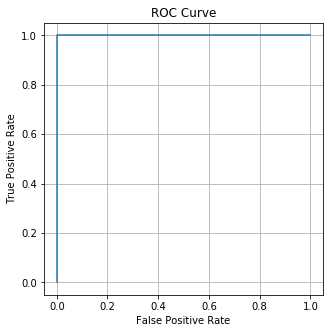

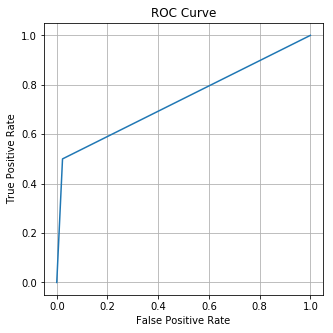

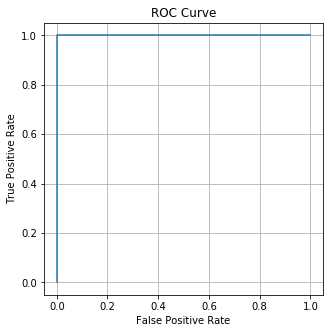

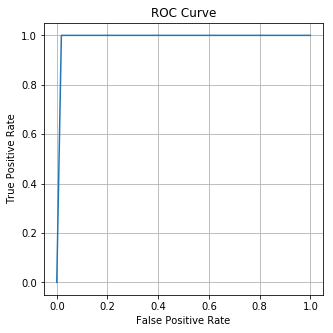

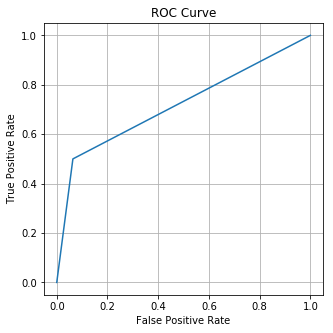

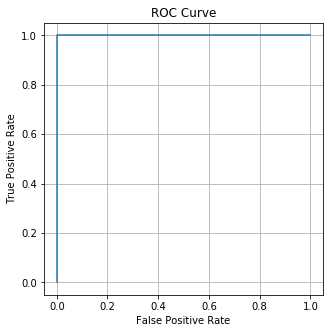

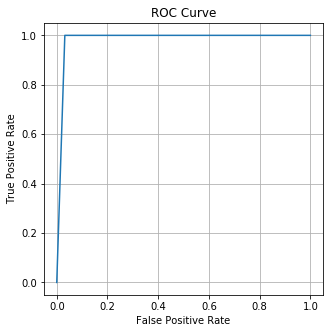

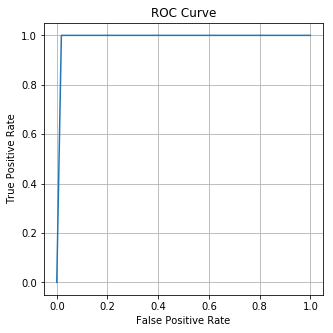

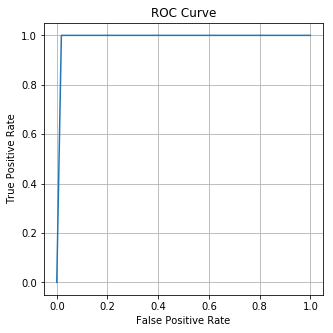

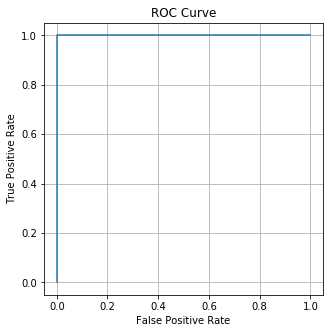

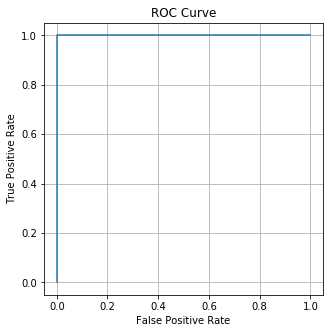

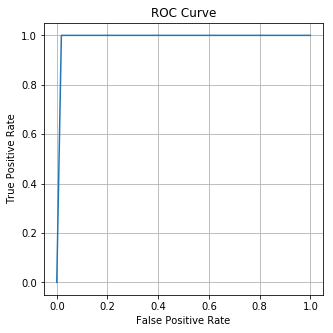

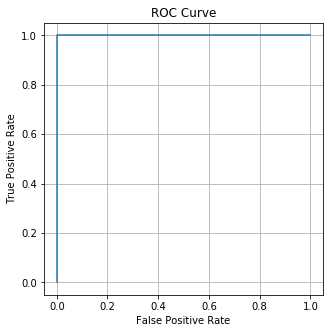

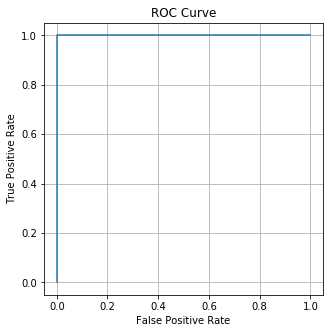

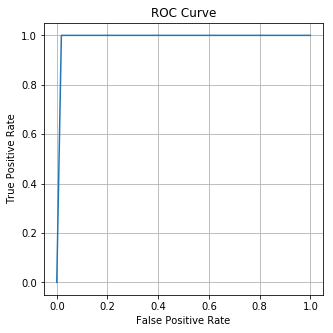

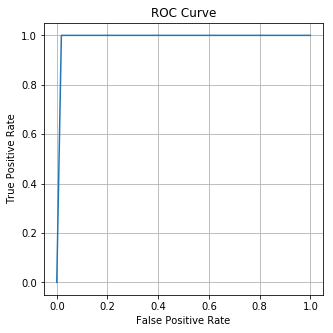

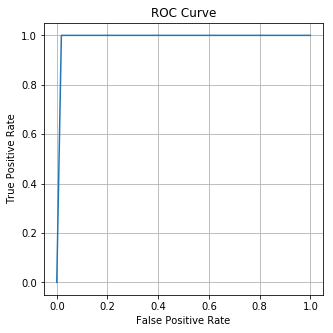

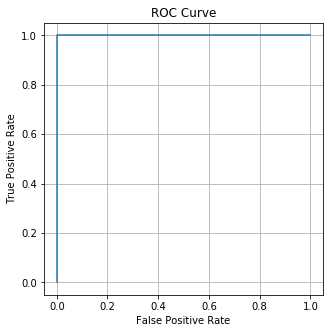

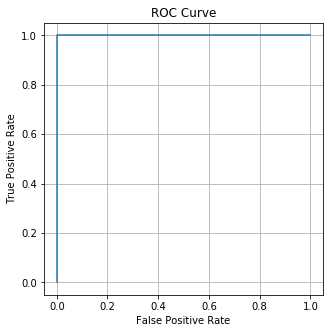

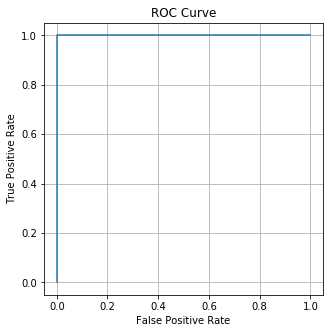

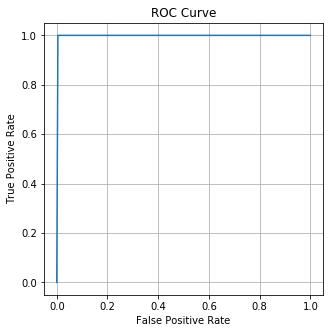

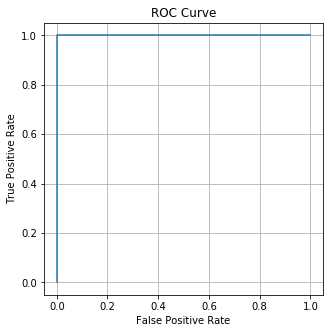

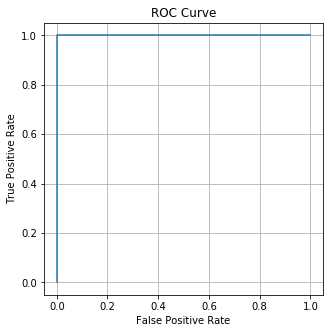

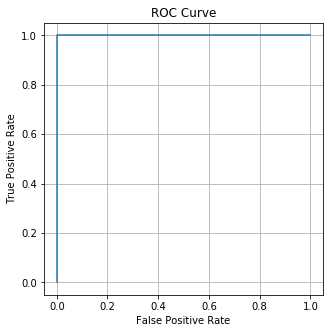

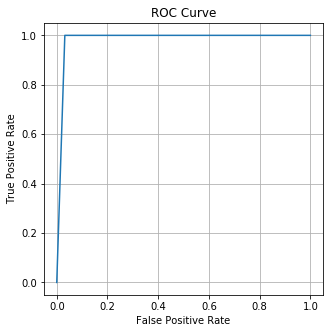

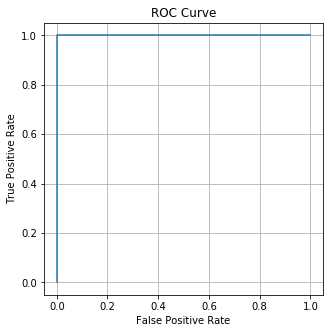

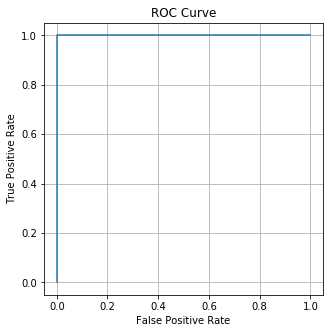

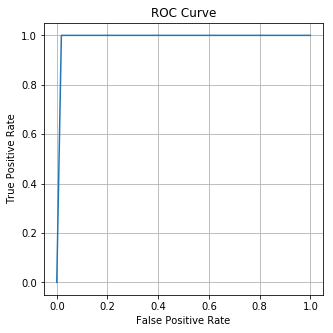

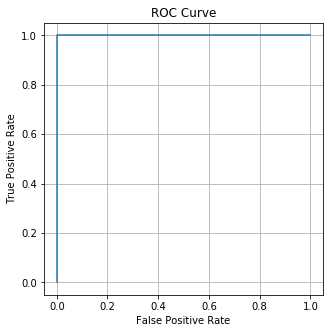

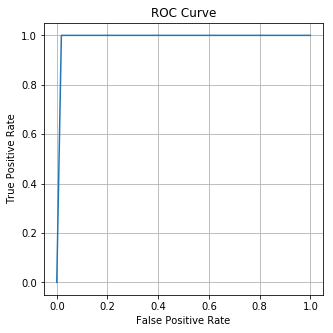

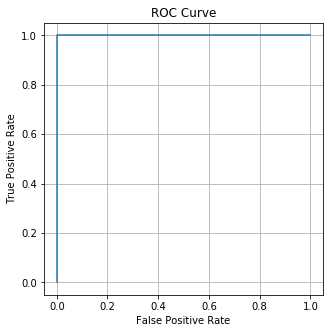

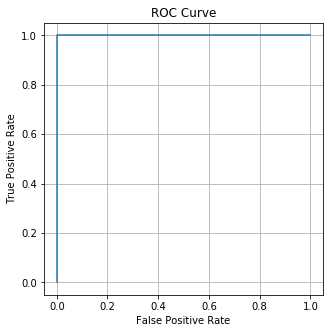

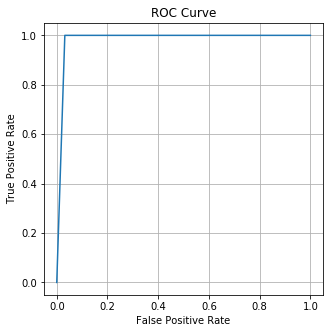

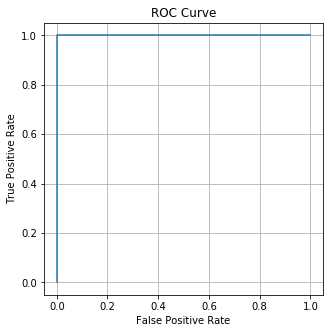

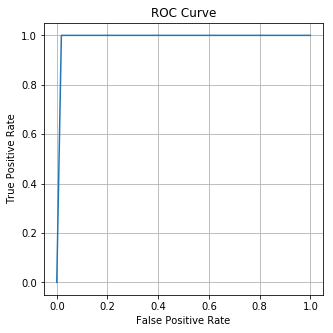

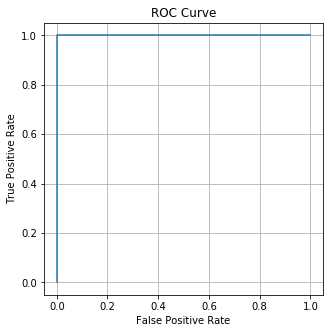

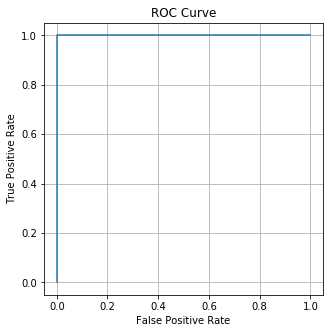

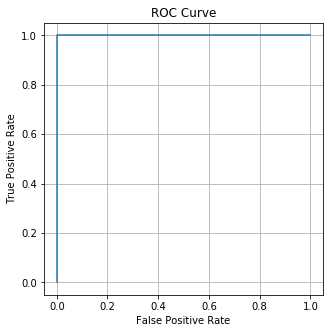

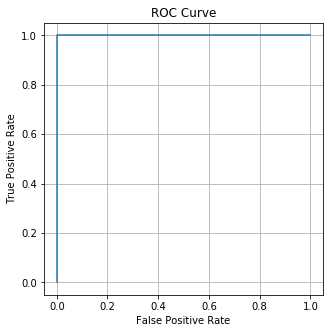

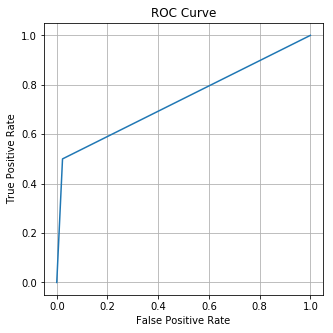

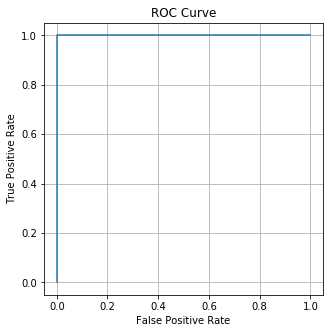

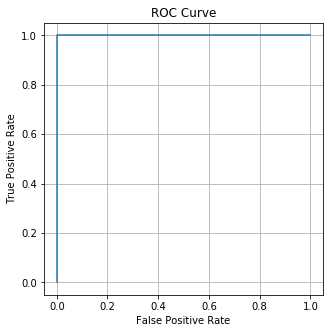

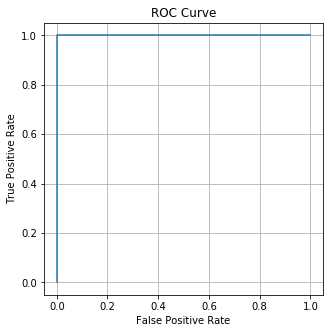

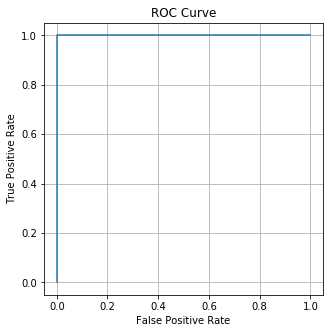

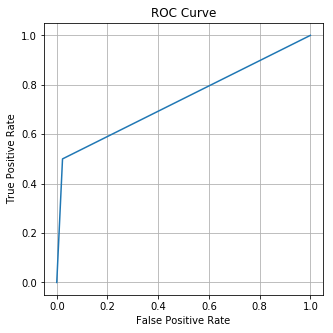

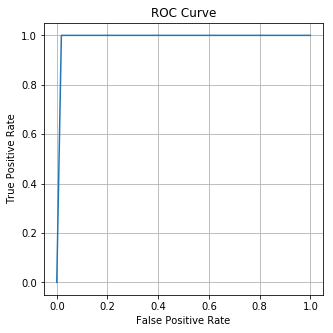

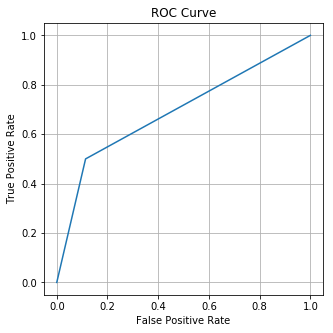

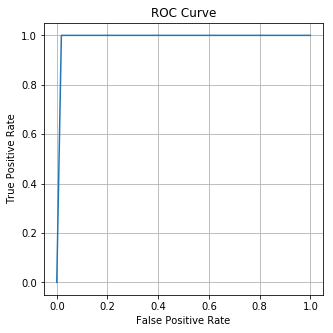

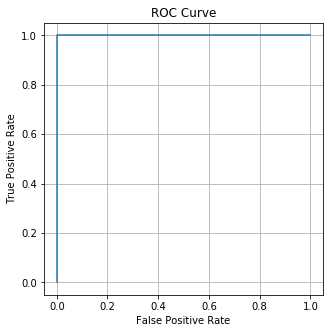

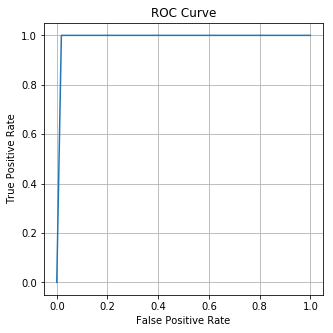

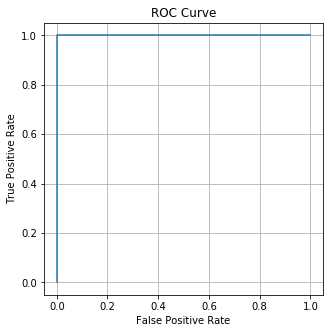

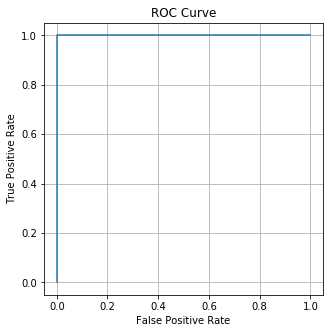

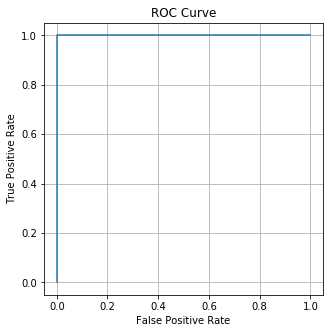

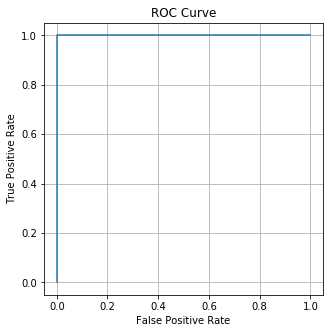

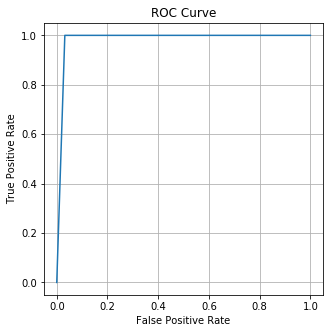

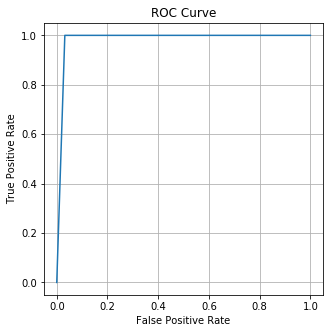

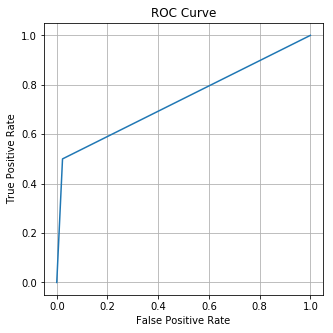

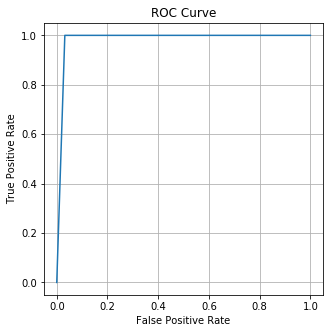

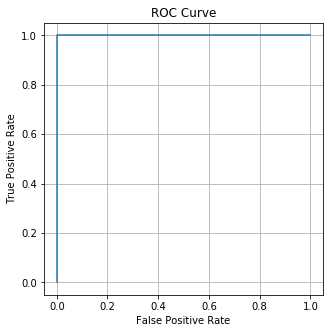

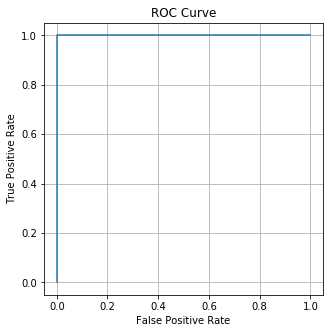

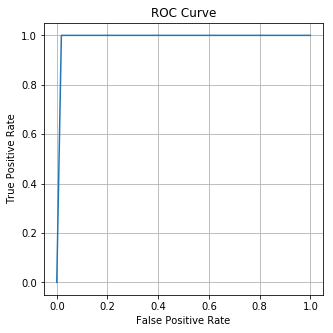

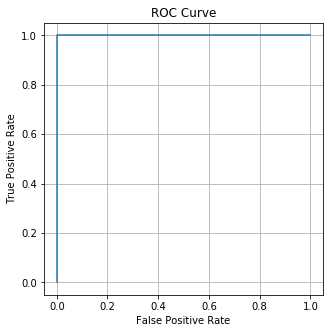

In [149]:
%time de.solve()

[1. 0. 1. 0. 0.]
g_mean:0.9839623052646977
 tnr:0.9681818181818181
 recall:1.0
 AUC:0.9840909242630005
 fbeta:0.3636363636363636
 precision:0.2222222222222222


0.01590907573699951

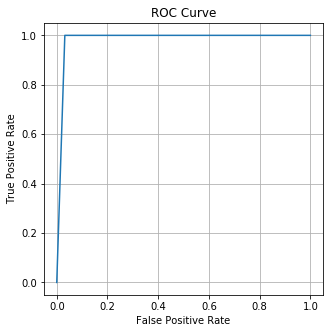

In [150]:
de.fitness(de.X_best)

# abalone-17_vs_7-8-9-10

## Read data

In [151]:
kddcup, X, y, k = read_data(
    filepath=r'abalone-17_vs_7-8-9-10/abalone_17_vs_7_8_9_10_data.txt',
    atr_num=9)

dict_items([(0, 2280), (1, 58)]) Imbalanced Ratio:39


## feature_columns

In [152]:
feature_columns = []

for header in ['Atr_' + str(i) for i in [1,2,3,4,5,6,7]]:
    feature_columns.append(tf.feature_column.numeric_column(header))

cateforical_columns = [
    tf.feature_column.categorical_column_with_vocabulary_list(
        'Atr_0', ['M', 'F', 'I'])]

onehot_columns = [tf.feature_column.indicator_column(i) for i in cateforical_columns]

feature_columns.extend(onehot_columns)

## onehot

In [165]:
X_onehot, columns_num = get_onehot(X, feature_columns)
dataframe_onehot = pd.DataFrame(np.c_[X_onehot.numpy(), y])

In [166]:
postive_frame_onehot_all = dataframe_onehot[dataframe_onehot[dataframe_onehot.columns[-1]] == 1]
negative_frame_onehot_all = dataframe_onehot[dataframe_onehot[dataframe_onehot.columns[-1]] == 0]

postive_frame_onehot, postive_frame_onehot_vala = train_test_split(postive_frame_onehot_all, test_size=0.2)
negative_frame_onehot, negative_frame_onehot_vala = train_test_split(negative_frame_onehot_all, test_size=0.2)
postive_frame_onehot_val, postive_frame_onehot_test = train_test_split(postive_frame_onehot_vala, test_size=0.5)
negative_frame_onehot_val, negative_frame_onehot_test = train_test_split(negative_frame_onehot_vala, test_size=0.5)

data_train = np.r_[postive_frame_onehot, negative_frame_onehot]
data_val = np.r_[postive_frame_onehot_val, negative_frame_onehot_val]
data_test = np.r_[postive_frame_onehot_test, negative_frame_onehot_test]

In [167]:
all_minority_sample_with_target = postive_frame_onehot

## smote

In [99]:
all_minority_sample_with_target = my_smote(postive_frame_onehot.to_numpy()[:,0:-1])
k = len(all_minority_sample_with_target)

### merge

In [168]:
new_negative = cluster_under_sample(negative_frame_onehot)

In [169]:
data_target_resample = np.r_[np.c_[new_negative, np.zeros(len(new_negative))], all_minority_sample_with_target]

In [170]:
# 随机森林
test_learner(learner_id=5)

ValueError: Number of features of the model must match the input. Model n_features is 10 and input n_features is 77 

g_mean:0.8463115231357644
 recall:0.9310344827586207
 tnr:0.769298245614035
 fbeta:0.16927899686520378
 precision:0.09310344827586207



0.8463115231357644

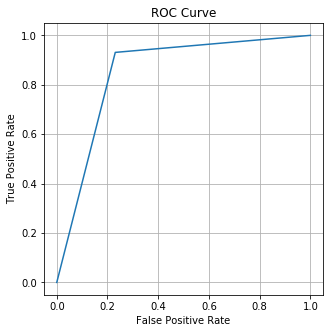

In [107]:
# 梯度提升树
test_learner(learner_id=6)

## bagging+tree

In [104]:
mybagging(data_target_resample, dataframe_onehot.to_numpy())

g_mean:0.9248043889897674
 tnr:0.8552631578947368
 recall:1.0
 AUC:0.9276316165924072
 fbeta:0.26008968609865474
 precision:0.14948453608247422


## de

In [171]:
de = DEalgorithm(5, 5, np.array([0, 0,0,0,0]),
                 np.array([2,2,3,5,2]), 6, 0.8, 0.5)
de.load_data(data_val, negative_frame_onehot, all_minority_sample_with_target)

[1. 0. 1. 3. 0.]
g_mean:0.8218507142366113
 tnr:0.6754385964912281
 recall:1.0
 AUC:0.8377193212509155
 fbeta:0.13953488372093023
 precision:0.075
[1. 1. 1. 3. 1.]
0.125 [0 0 0 0 0 0 1 1 1 1]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[1. 1. 0. 4. 1.]
0.17763161659240723 [0 0 0 1 1 1 1 1 1 1]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[1. 0. 1. 0. 1.]
g_mean:0.8191780219091253
 tnr:0.6710526315789473
 recall:1.0
 AUC:0.8355263471603394
 fbeta:0.13793103448275862
 precision:0.07407407407407407
[0. 0. 2. 0. 1.]
[0. 0. 2. 0. 1.]
g_mean:0.6839855680567694
 tnr:0.5614035087719298
 recall:0.8333333333333334
 AUC:0.6973683834075928
 fbeta:0.09009009009009009
 precision:0.047619047619047616
[0. 0. 1. 2. 0.]
g_mean:0.7173701157986271
 tnr:0.7719298245614035
 recall:0.6666666666666666
 AUC:0.7192983031272888
 fbeta:0.12903225806451613
 precision:0.07142857142857142
[1. 0. 1. 3. 0.]
g_mean:0.8191780219091253
 tnr:0.6710526315789473
 recall:1.0
 AUC:

0.19078952074050903 [0 0 0 1 0 0 1 1 0 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[1. 1. 0. 4. 1.]
0.12719297409057617 [1 0 0 0 0 0 0 0 0 1]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 1. 0. 1.]
0.15570175647735596 [0 0 0 0 0 0 1 0 0 1]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 1. 0. 1.]
0.1381579041481018 [1 0 0 0 0 0 0 0 0 1]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 0. 2. 1.]
0.09649121761322021 [0 0 0 0 1 1 0 0 0 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 1. 0. 1.]
0.1381579041481018 [0 0 0 0 0 0 0 0 0 1]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[1. 1. 0. 3. 1.]
0.09649121761322021 [0 0 0 0 0 1 0 0 0 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 0. 0. 1. 1.]
g_mean:0.893445921158683
 tnr:0.7982456140350878
 recall:1.0
 AUC:0.8991228342056274
 fbeta:0.20689655172413793
 precisi

0.09868425130844116 [0 0 0 0 1 0 1 1 0 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 0. 0. 1.]
0.1381579041481018 [0 0 0 0 0 0 0 0 0 1]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[1. 1. 0. 0. 1.]
0.12061405181884766 [0 0 0 0 0 1 0 0 0 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[1. 1. 0. 0. 1.]
0.10307013988494873 [0 0 0 0 0 1 0 0 0 1]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[1. 1. 0. 1. 1.]
0.11403506994247437 [1 0 0 1 0 1 0 0 1 1]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[1. 1. 0. 0. 1.]
0.11622810363769531 [0 0 0 0 0 1 1 0 0 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[1. 1. 0. 3. 1.]
0.12061405181884766 [0 0 0 0 0 1 0 0 0 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 1. 4. 1.]
0.12938594818115234 [0 0 0 0 0 0 0 0 1 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 1. 

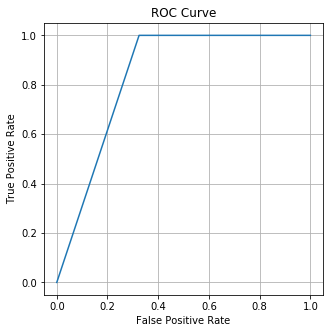

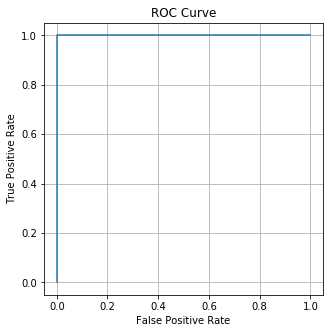

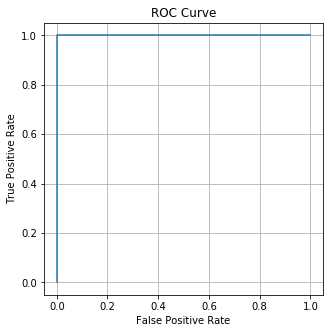

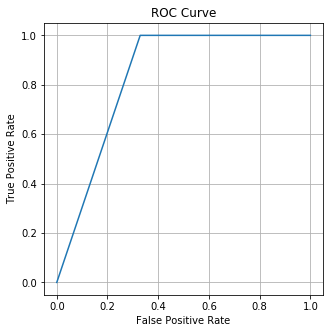

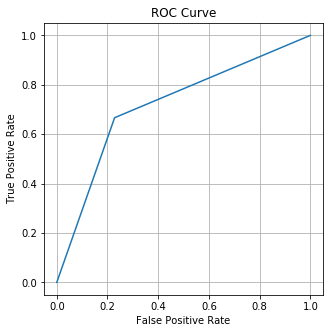

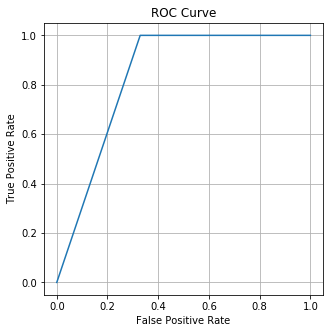

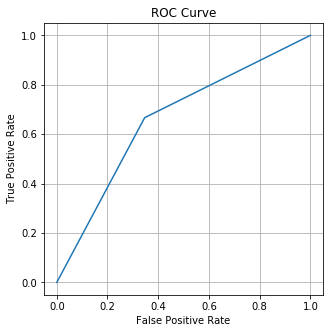

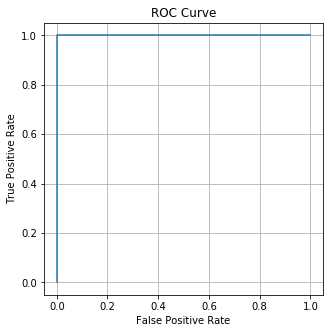

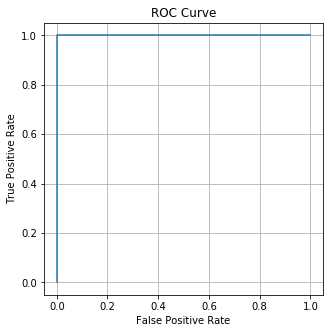

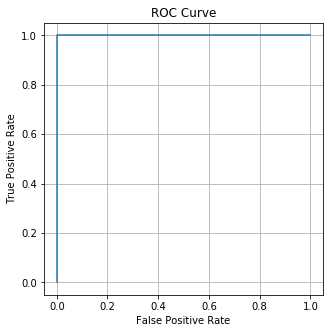

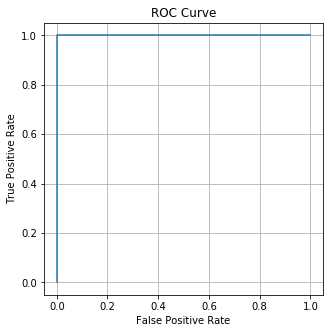

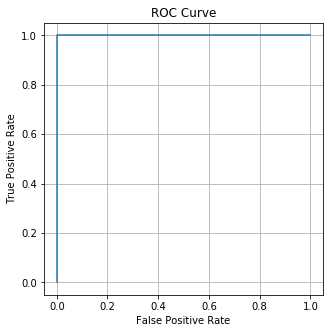

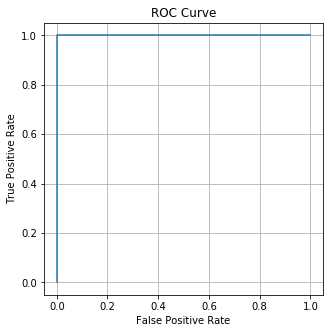

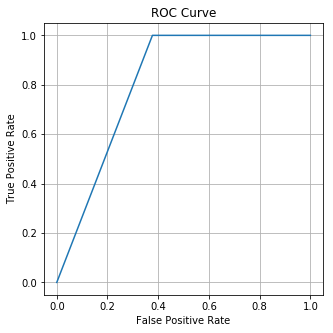

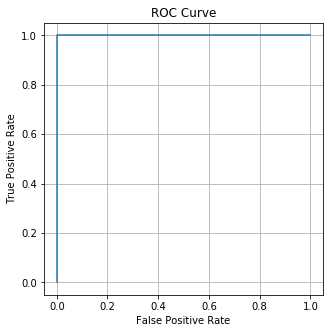

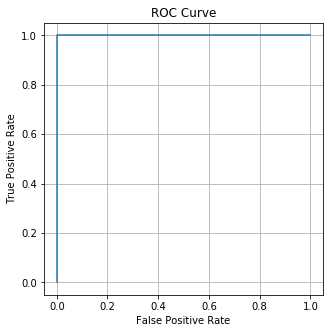

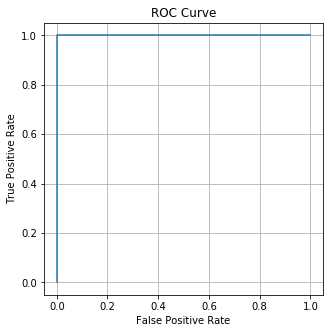

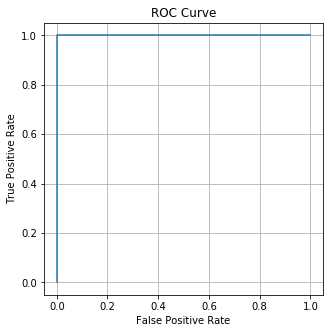

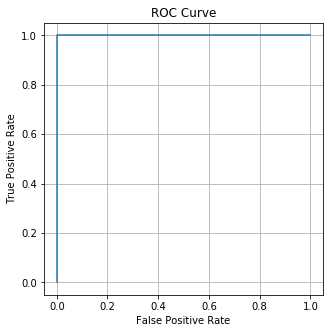

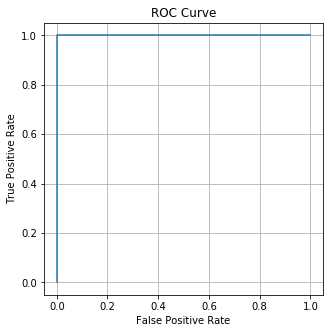

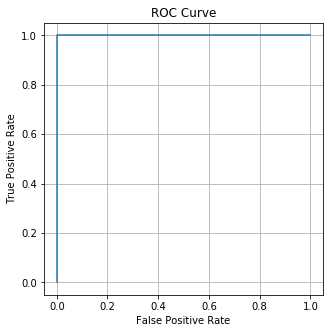

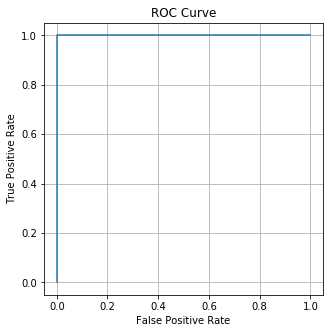

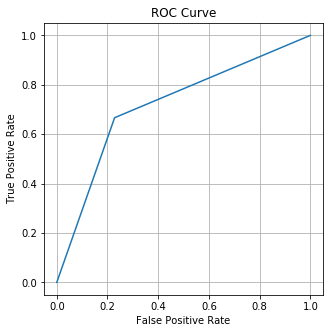

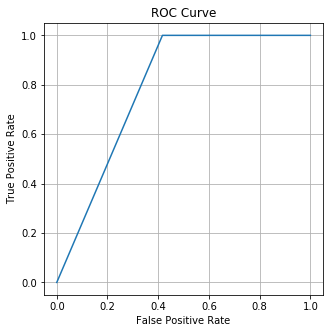

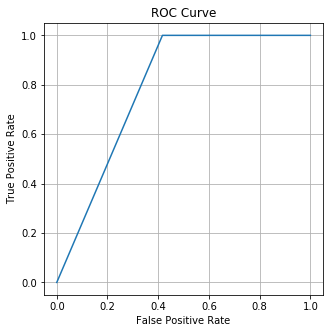

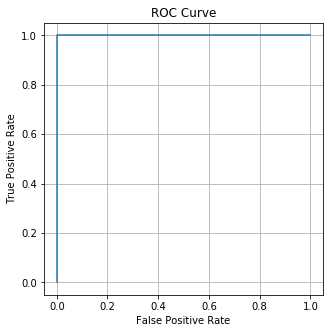

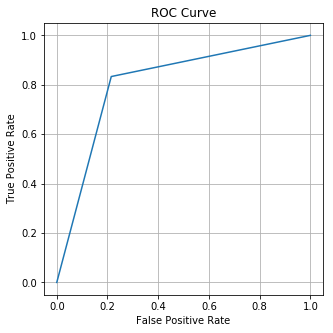

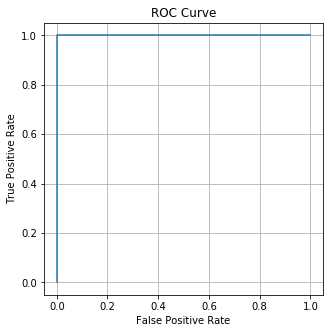

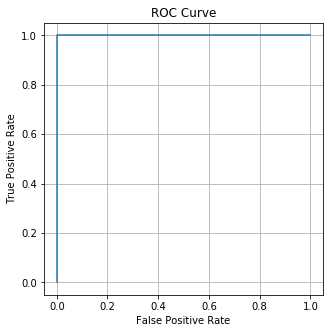

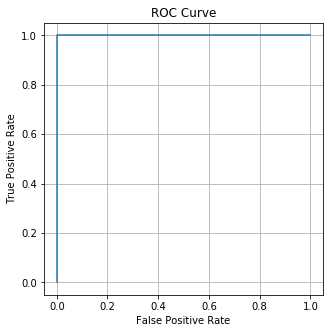

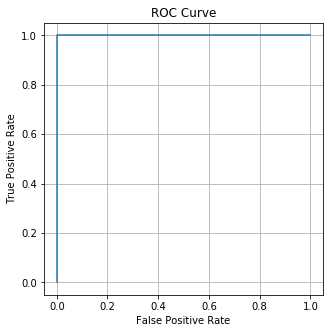

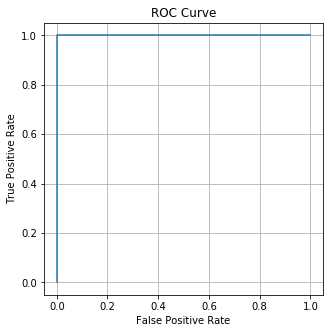

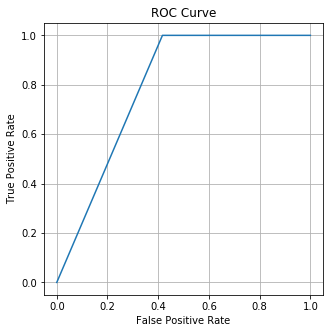

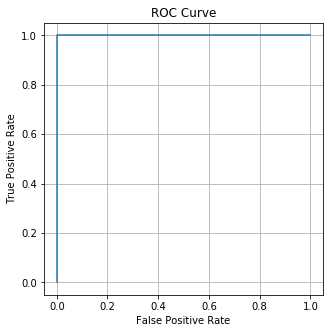

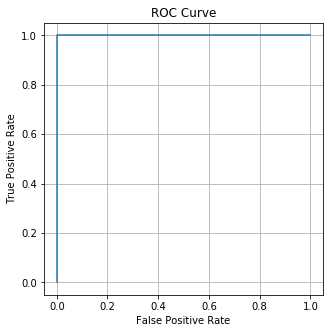

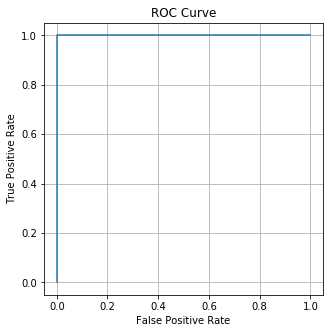

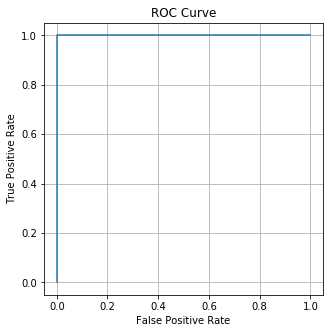

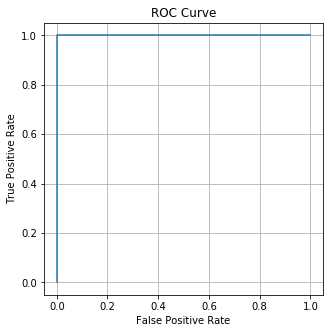

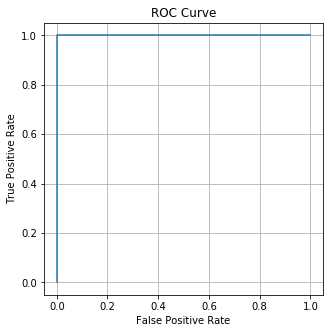

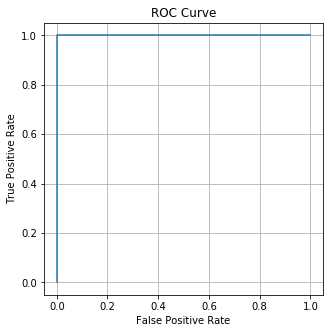

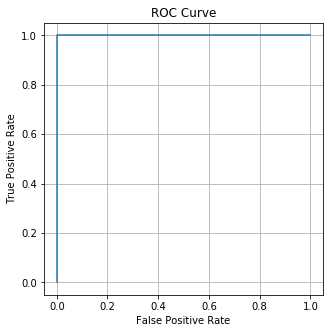

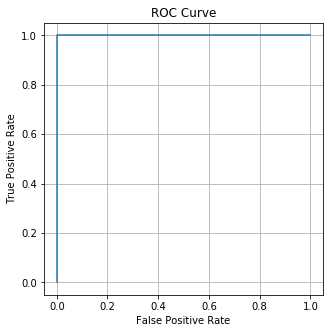

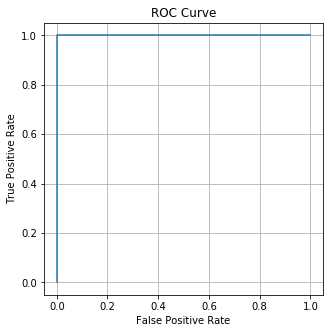

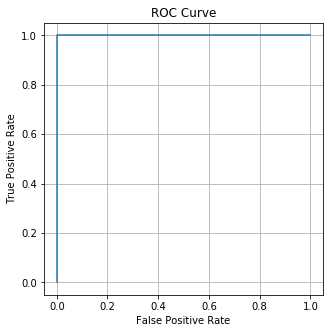

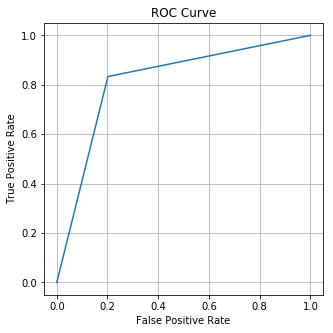

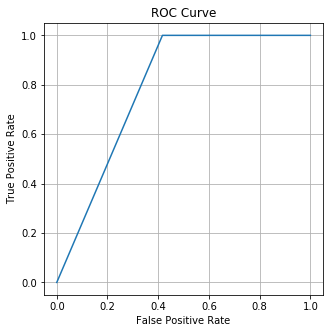

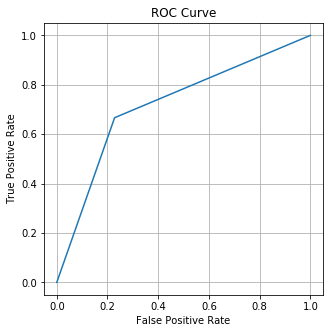

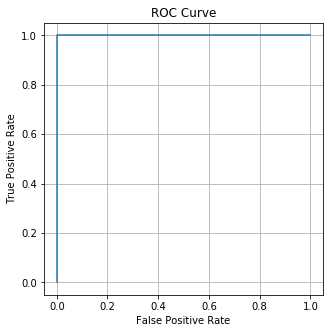

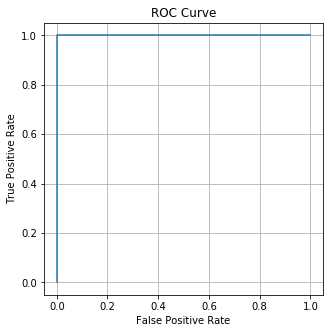

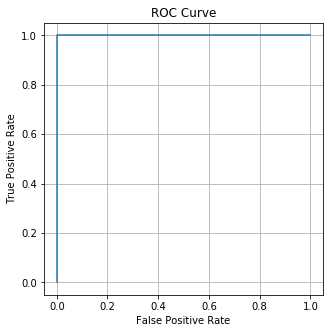

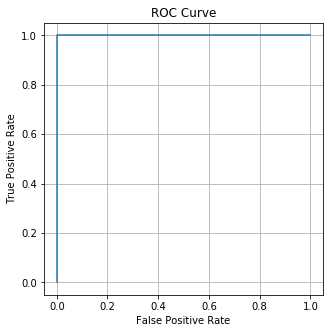

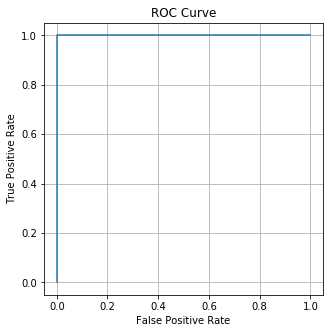

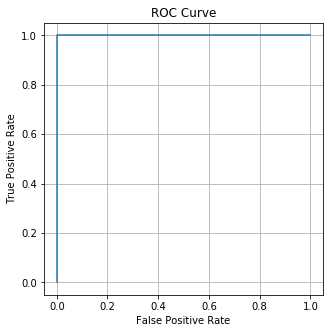

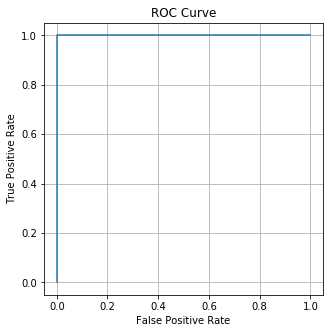

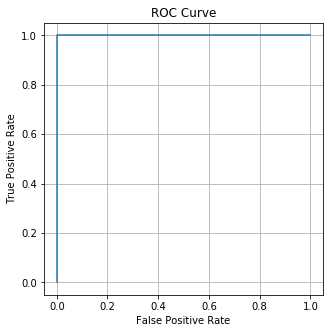

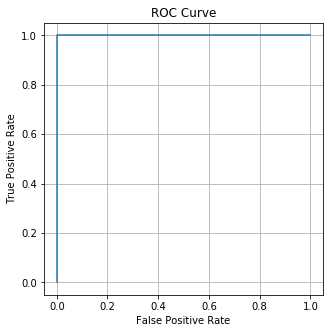

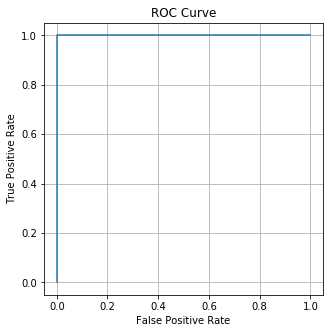

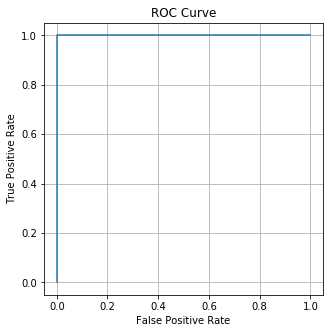

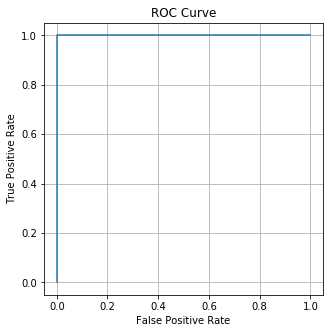

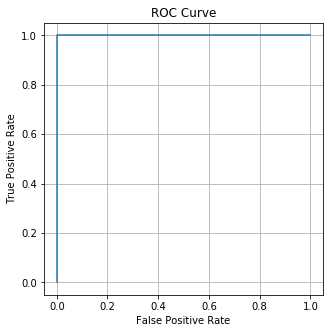

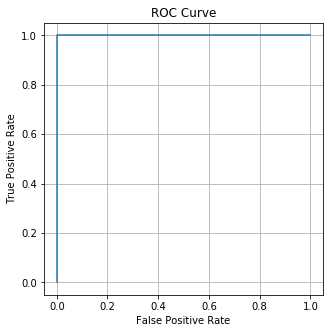

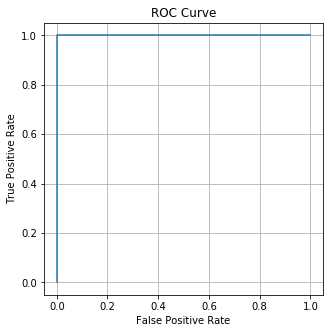

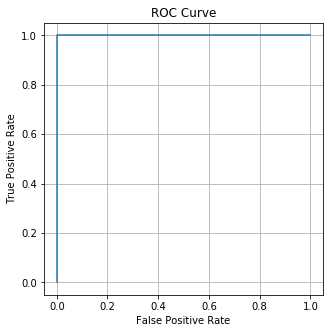

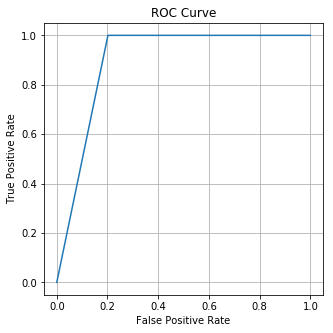

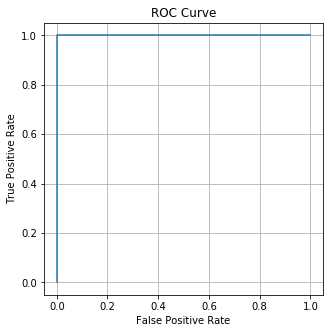

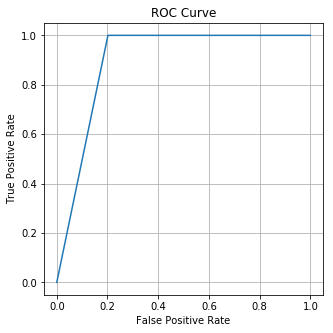

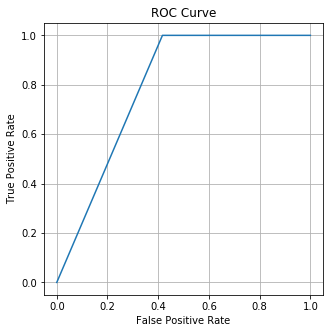

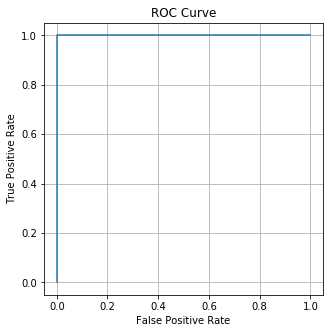

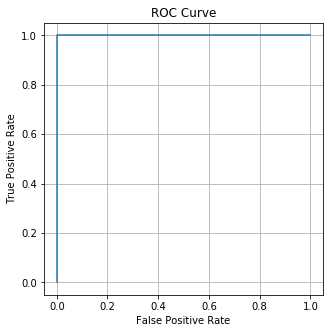

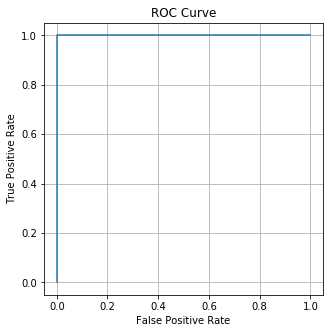

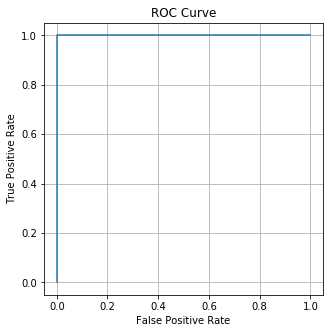

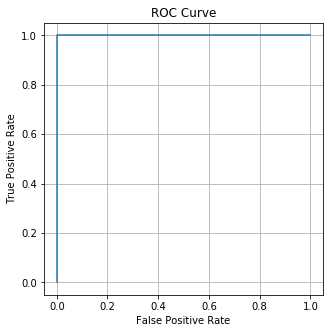

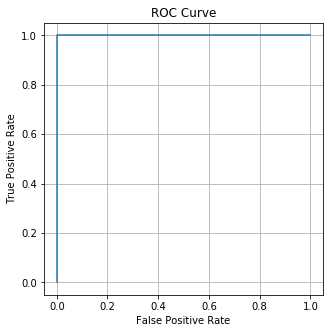

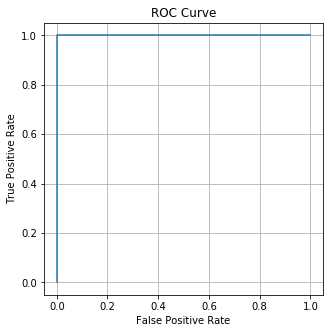

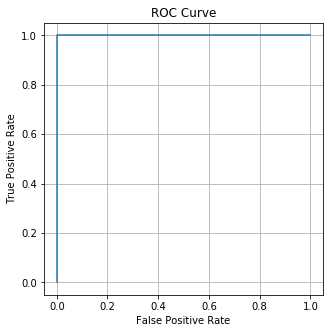

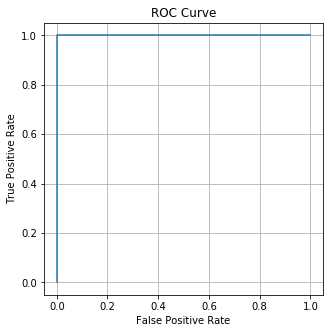

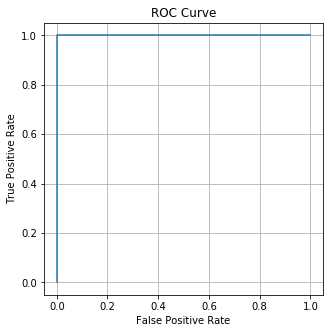

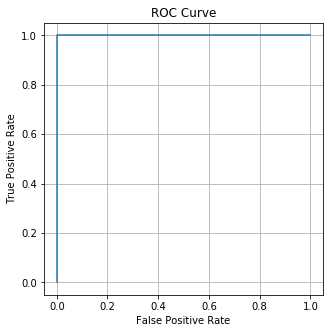

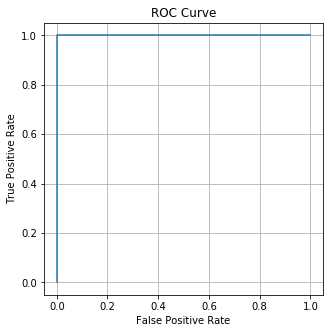

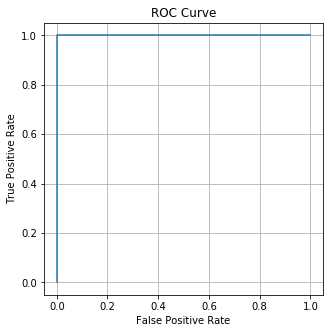

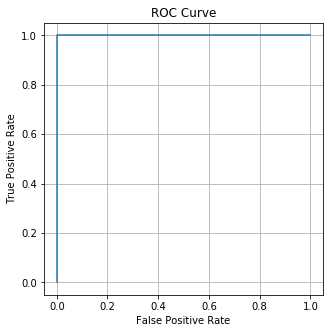

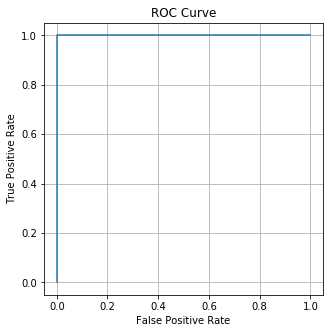

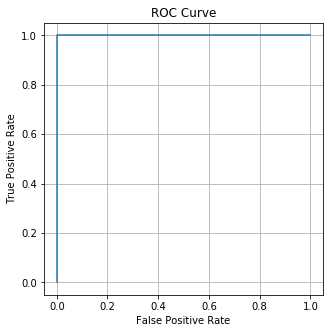

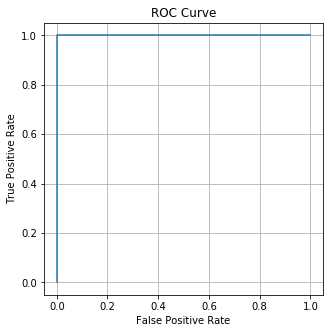

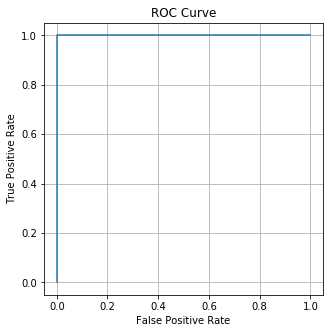

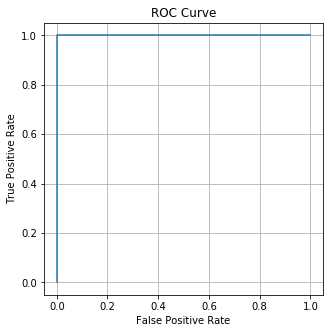

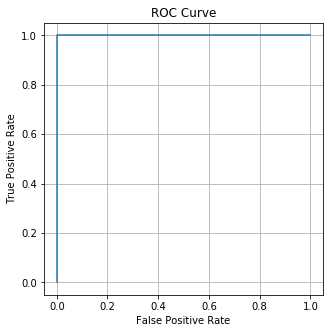

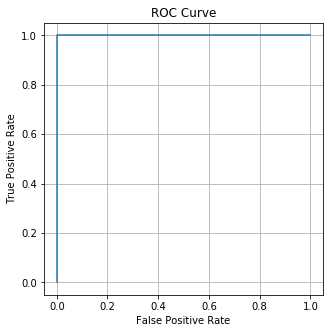

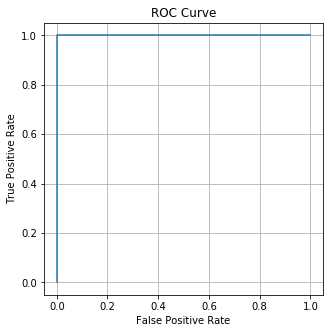

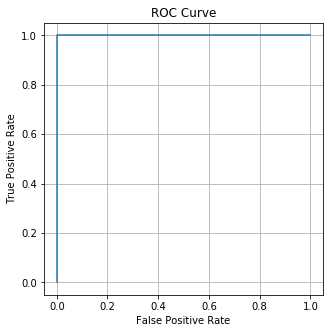

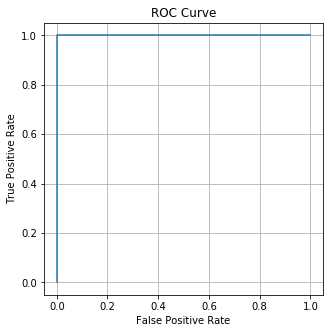

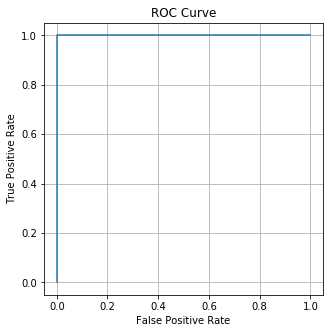

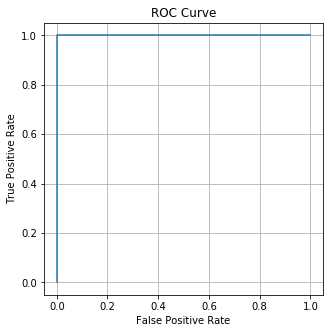

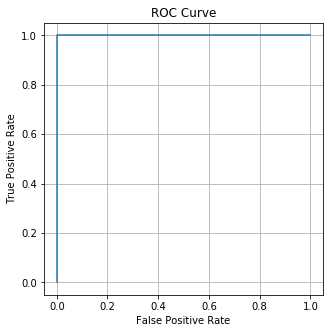

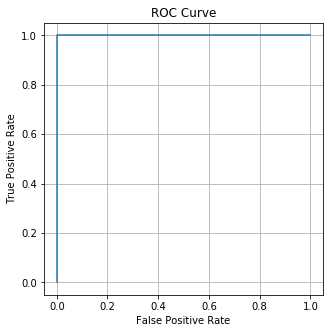

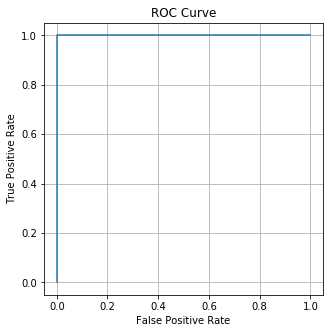

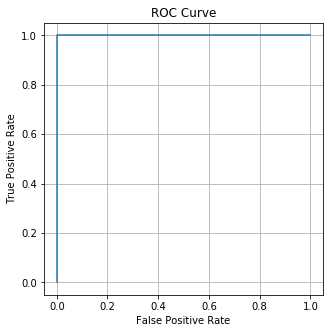

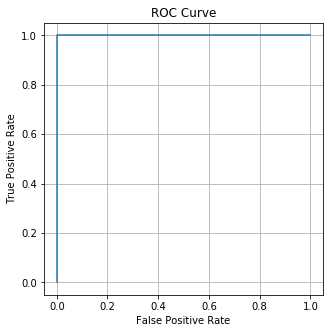

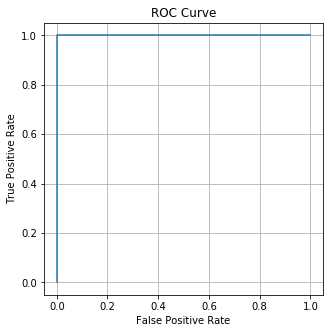

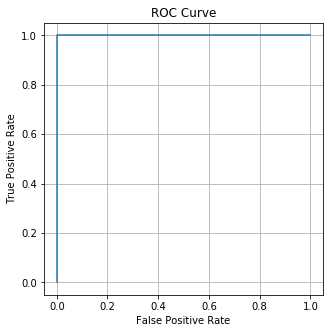

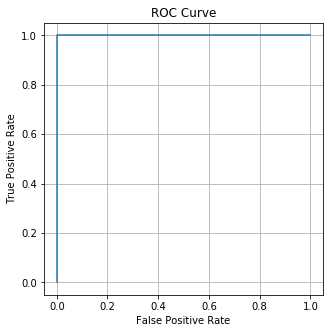

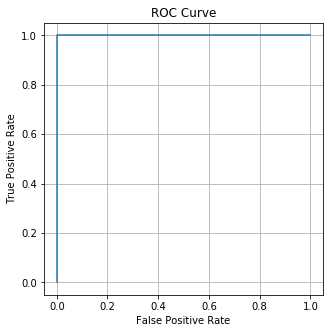

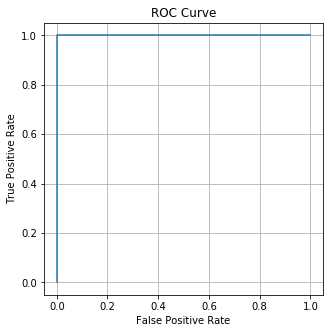

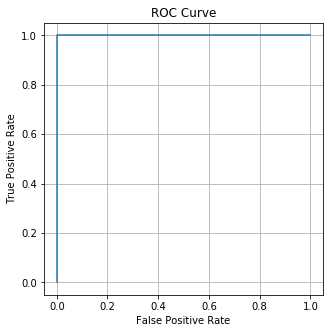

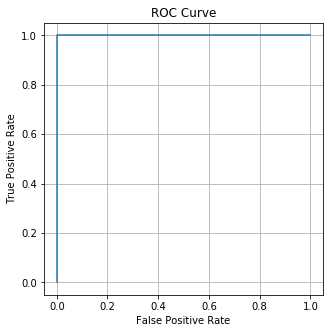

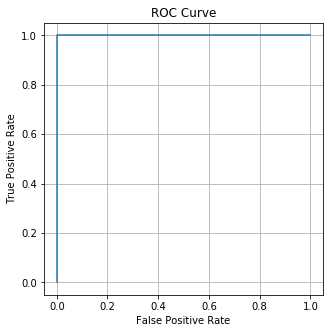

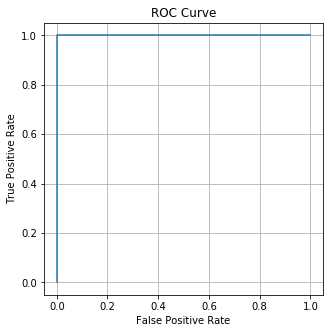

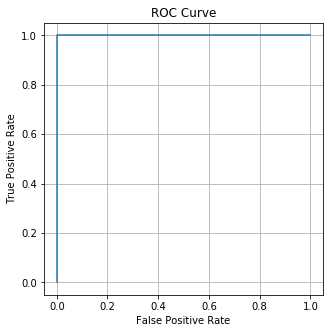

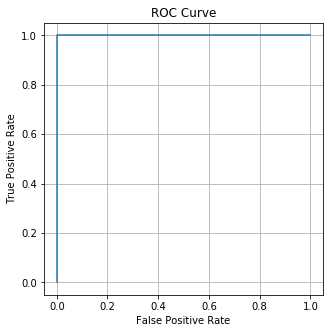

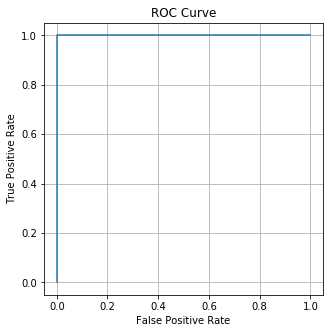

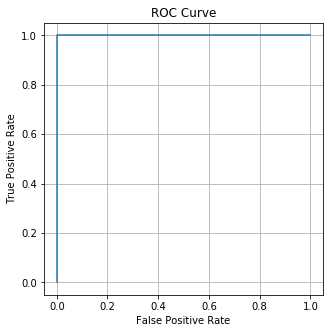

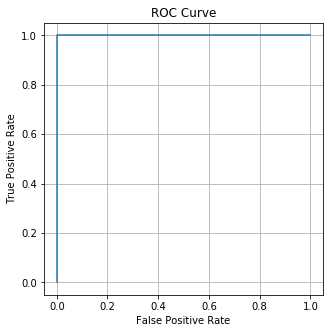

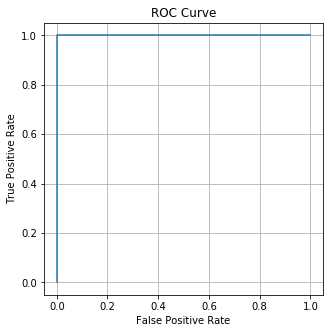

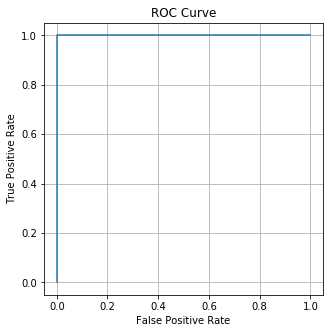

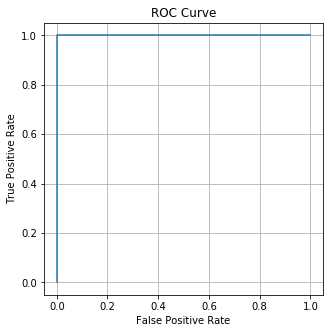

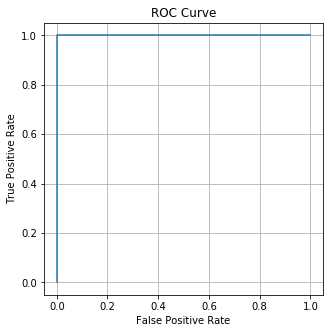

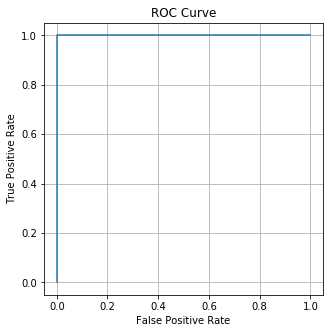

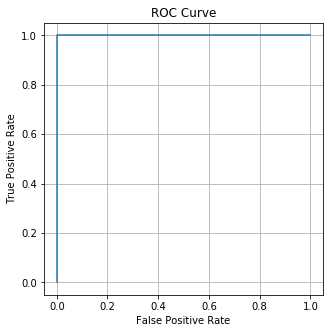

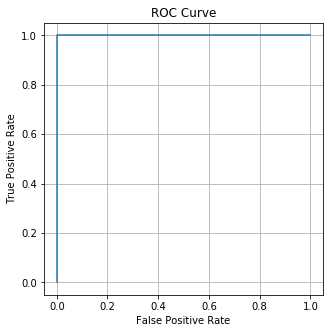

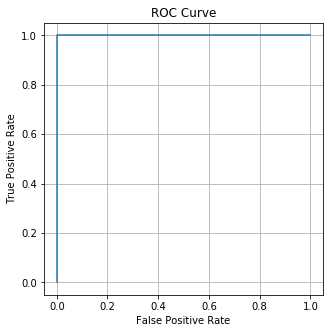

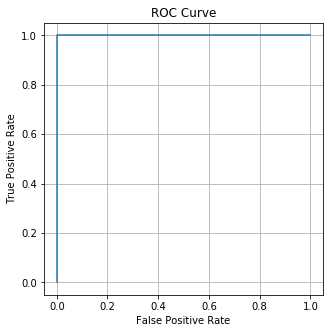

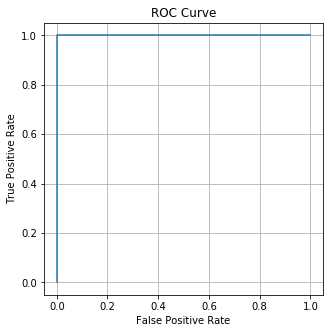

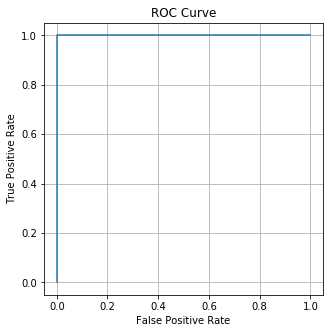

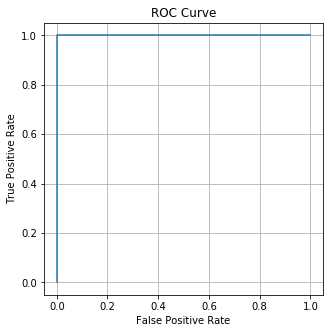

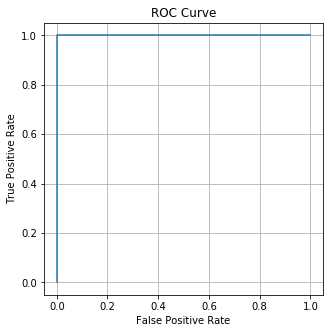

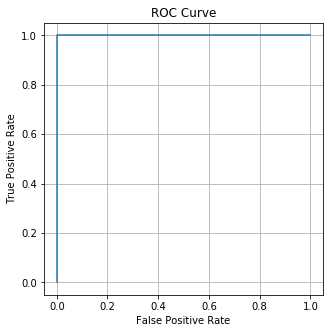

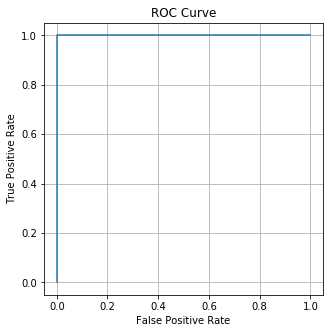

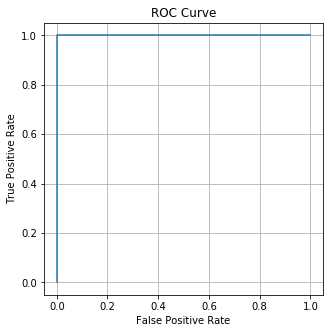

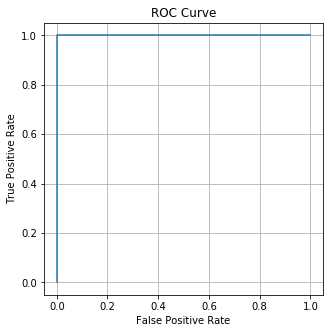

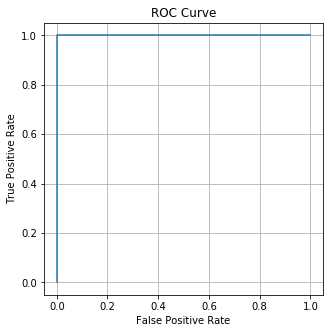

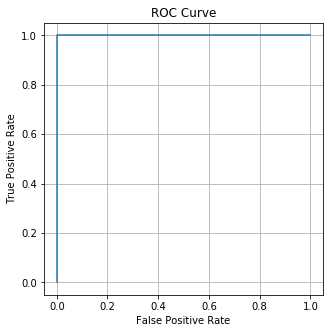

In [172]:
%time de.solve()

[0. 1. 1. 4. 1.]
0.1513158082962036 [0 0 0 1 0 0 1 1 0 1]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0


0.0

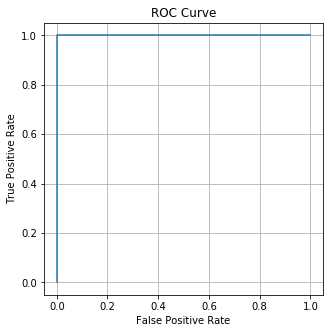

In [174]:
de.fitness(de.X_best)

# abalone19

In [108]:
kddcup, X, y, k = read_data(
    filepath=r'abalone19\abalone19_data.txt',
    atr_num=9)

dict_items([(0, 4142), (1, 32)]) Imbalanced Ratio:129


## feature columns

In [109]:
feature_columns = []

for header in ['Atr_' + str(i) for i in [1,2,3,4,5,6,7]]:
    feature_columns.append(tf.feature_column.numeric_column(header))

cateforical_columns = [
    tf.feature_column.categorical_column_with_vocabulary_list(
        'Atr_0', ['M', 'F', 'I'])]

onehot_columns = [tf.feature_column.indicator_column(i) for i in cateforical_columns]

feature_columns.extend(onehot_columns)

## onehot

In [110]:
X_onehot, columns_num = get_onehot(X, feature_columns)
dataframe_onehot = pd.DataFrame(np.c_[X_onehot.numpy(), y])

In [111]:
postive_frame_onehot = dataframe_onehot[dataframe_onehot[dataframe_onehot.columns[-1]] == 1]
negative_frame_onehot = dataframe_onehot[dataframe_onehot[dataframe_onehot.columns[-1]] == 0]

## smote

In [112]:
all_minority_sample_with_target = my_smote(postive_frame_onehot.to_numpy()[:,0:-1])
k = len(all_minority_sample_with_target)

## kmeans

### merge

In [113]:
new_negative = cluster_under_sample(k, negative_frame_onehot)

In [114]:
data_target_resample = np.r_[np.c_[new_negative, np.zeros(len(new_negative))], all_minority_sample_with_target]

## ada+bp

In [81]:
model = tf.keras.Sequential([
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.AUC(name="AUC"),
        keras.metrics.Recall(name='Recall'),
        keras.metrics.Precision(name='Precision'),
    ],
)

In [82]:
for train_index, test_index in kf.split(data_target_resample):
    train_data = data_target_resample[train_index]
    test_data = data_target_resample[test_index]
    model.fit(x=train_data[:, 0:-1],
              y=train_data[:, -1],
              validation_data=(test_data[:, 0:-1], test_data[:, -1]),
              verbose=1,
              epochs=5)

Train on 102 samples, validate on 26 samples
Epoch 1/5
102/102 [==============================] - 3s 25ms/sample - loss: 0.7084 - accuracy: 0.5196 - AUC: 0.5913 - Recall: 0.0000e+00 - Precision: 0.0000e+00 - val_loss: 0.7552 - val_accuracy: 0.4231 - val_AUC: 0.4545 - val_Recall: 0.0000e+00 - val_Precision: 0.0000e+00
Epoch 2/5
102/102 [==============================] - 0s 455us/sample - loss: 0.6874 - accuracy: 0.5196 - AUC: 0.6548 - Recall: 0.0000e+00 - Precision: 0.0000e+00 - val_loss: 0.7249 - val_accuracy: 0.4231 - val_AUC: 0.5061 - val_Recall: 0.0000e+00 - val_Precision: 0.0000e+00
Epoch 3/5
102/102 [==============================] - 0s 336us/sample - loss: 0.6768 - accuracy: 0.5196 - AUC: 0.7064 - Recall: 0.0000e+00 - Precision: 0.0000e+00 - val_loss: 0.7067 - val_accuracy: 0.4231 - val_AUC: 0.5212 - val_Recall: 0.0000e+00 - val_Precision: 0.0000e+00
Epoch 4/5
102/102 [==============================] - 0s 362us/sample - loss: 0.6701 - accuracy: 0.5686 - AUC: 0.7314 - Recall: 0.10

g_mean:0.8417001115244206
 recall:0.90625
 tnr:0.7817479478512795
 fbeta:0.06010362694300519
 precision:0.031082529474812434



0.8417001115244206

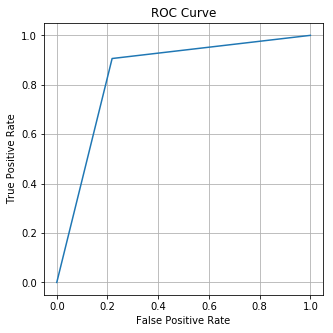

In [117]:
# 随机森林
test_learner(learner_id=5)

g_mean:0.8259562007648132
 recall:0.90625
 tnr:0.7527764365041043
 fbeta:0.05345622119815669
 precision:0.027540360873694207



0.8259562007648132

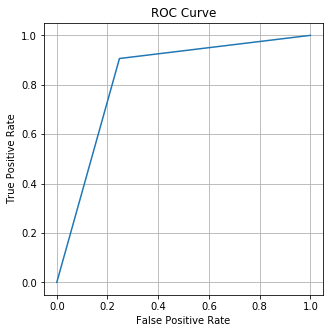

In [118]:
# 梯度提升树
test_learner(learner_id=6)

## bagging+tree

In [121]:
mybagging(data_target_resample, dataframe_onehot.to_numpy())

g_mean:0.898520700674884
 tnr:0.8073394495412844
 recall:1.0
 AUC:0.9036697149276733
 fbeta:0.07424593967517401
 precision:0.03855421686746988


## de

In [71]:
de = DEalgorithm(5, 5, np.array([0, 0,0,0,0]),
                 np.array([2,2,3,5,2]), 6, 0.8, 0.5)
de.load_data(dataframe_onehot.to_numpy(), negative_frame_onehot, all_minority_sample_with_target)

[1. 1. 2. 1. 1.]
0.21044331789016724 [0 0 0 1 1 0 1 1 1 0]
[1. 1. 2. 1. 1.]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 1. 3. 1.]
0.2974785566329956 [1 0 0 1 1 0 1 1 1 1]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 0. 3. 0.]
0.2924236059188843 [1 0 0 0 0 0 1 0 0 1]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[1. 0. 2. 4. 0.]
[1. 0. 2. 4. 0.]
g_mean:0.6913425276838239
 tnr:0.6117817479478512
 recall:0.78125
 AUC:0.6965158581733704
 fbeta:0.03003003003003003
 precision:0.015309246785058175
[1. 0. 2. 1. 1.]
[1. 0. 2. 1. 1.]
g_mean:0.866604546703381
 tnr:0.7752293577981652
 recall:0.96875
 AUC:0.8719896078109741
 fbeta:0.06237424547283702
 precision:0.032224532224532226
[0. 0. 1. 3. 1.]
g_mean:0.6274036349121014
 tnr:0.6629647513278609
 recall:0.59375
 AUC:0.6283574104309082
 fbeta:0.02626123013130615
 precision:0.01342756183745583
[1. 1. 2. 1. 1.]
0.17840111255645752 [1 1 1 1 0 0 0 1 0 1]
[1. 1. 2. 1. 1.]
g

0.12680315971374512 [0 1 0 1 0 0 0 1 1 1]
[1. 1. 2. 1. 1.]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 2. 2. 1.]
0.28288722038269043 [1 0 0 0 1 1 1 0 0 1]
[0. 1. 2. 2. 1.]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 0. 1. 0. 0.]
g_mean:0.6613636816174795
 tnr:0.5598744567841623
 recall:0.78125
 AUC:0.670562207698822
 fbeta:0.026595744680851064
 precision:0.013528138528138528
[1. 0. 1. 2. 0.]
g_mean:0.6968751387135472
 tnr:0.5755673587638822
 recall:0.84375
 AUC:0.709658682346344
 fbeta:0.02971931755641167
 precision:0.015126050420168067
[1. 0. 1. 2. 0.]
g_mean:0.6965394387709853
 tnr:0.7056977305649444
 recall:0.6875
 AUC:0.6965988874435425
 fbeta:0.03456402199528673
 precision:0.017727639000805803
[0. 1. 2. 2. 1.]
0.30017203092575073 [0 0 0 1 0 1 1 1 0 0]
[0. 1. 2. 2. 1.]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 2. 2. 1.]
0.0
[1. 1. 2. 1. 1.]
0.1607239842414856 [0 0 0 1 0 1 1 1 1 1]
[1. 1. 2. 1. 

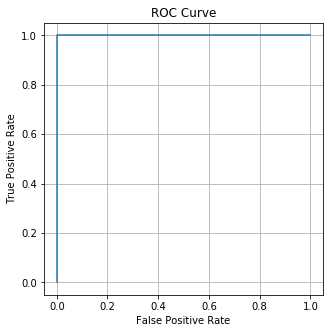

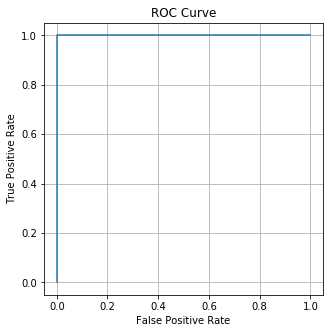

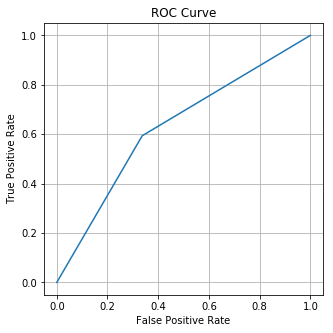

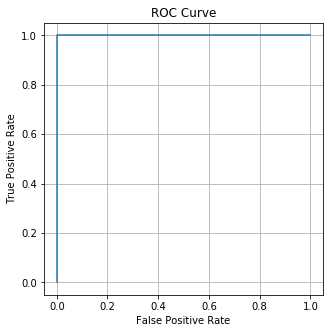

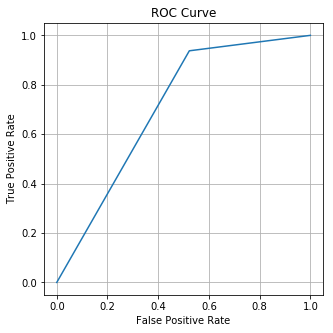

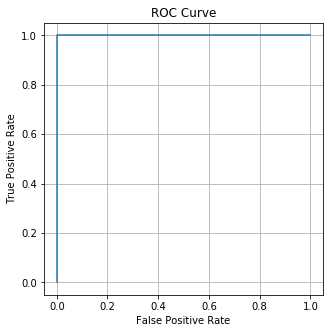

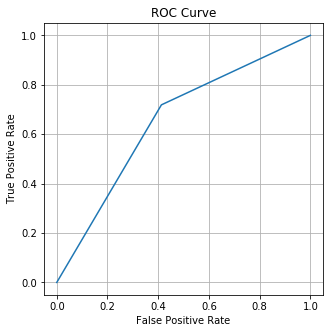

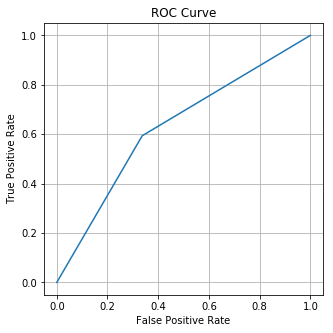

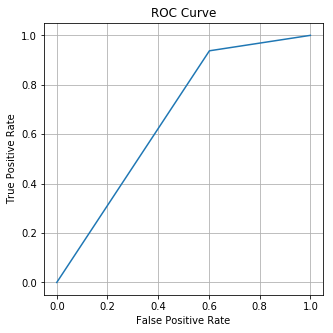

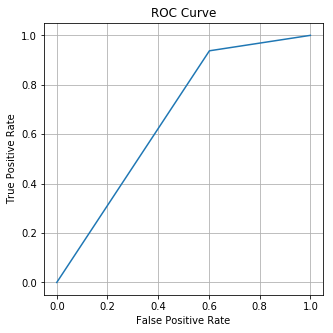

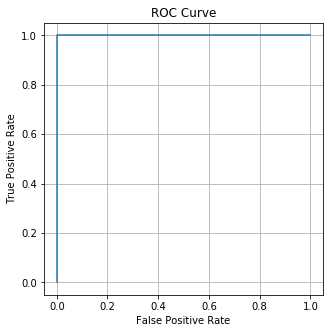

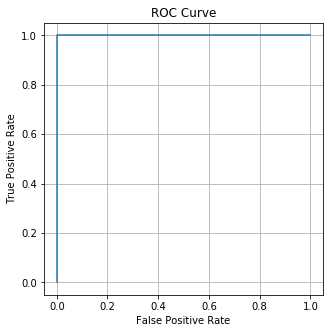

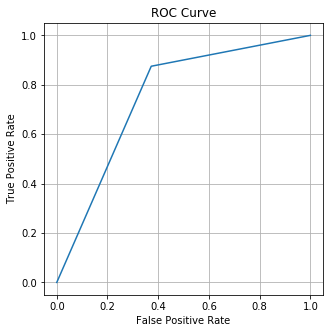

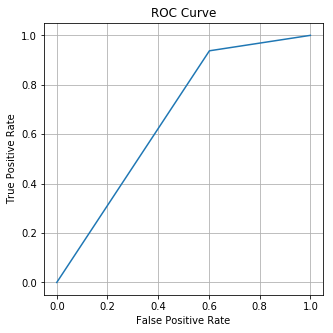

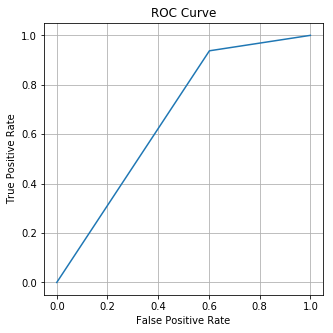

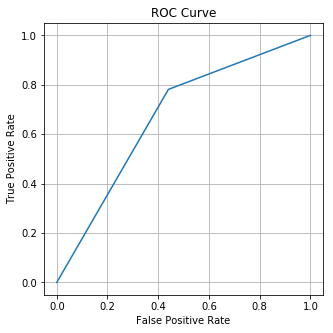

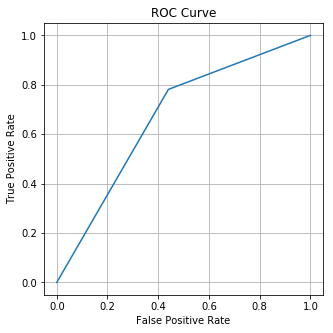

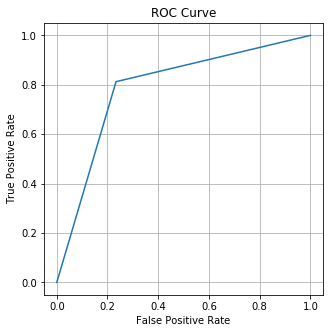

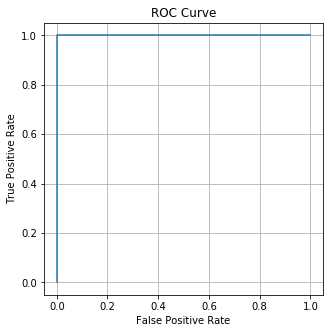

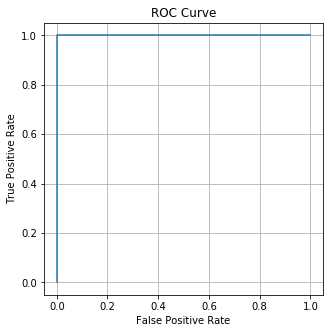

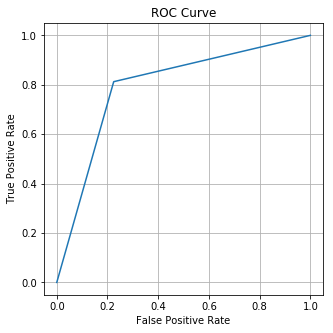

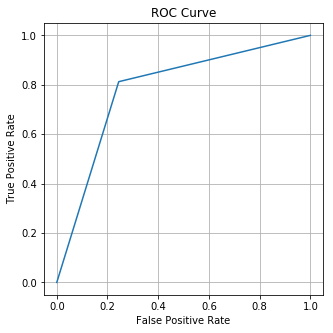

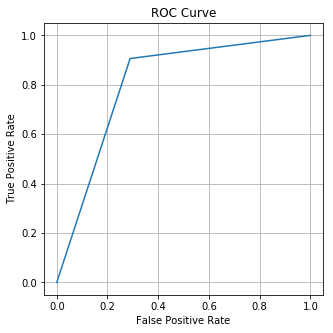

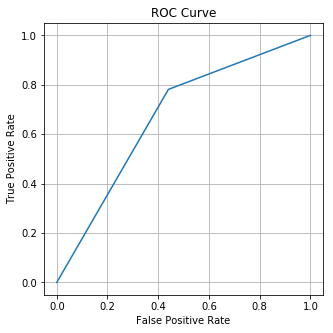

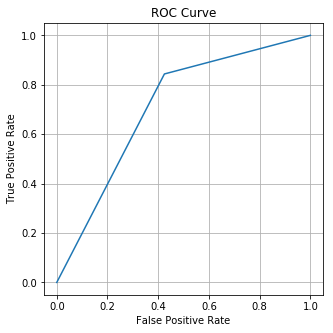

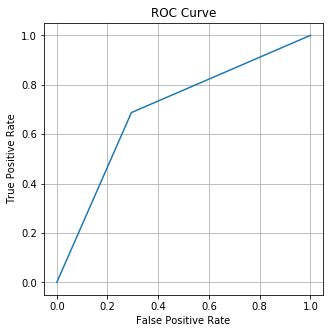

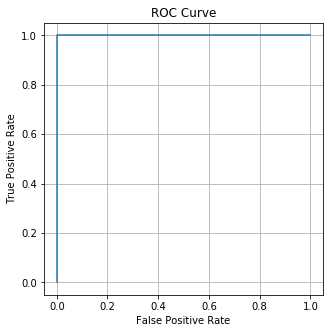

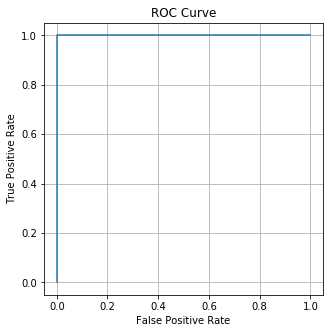

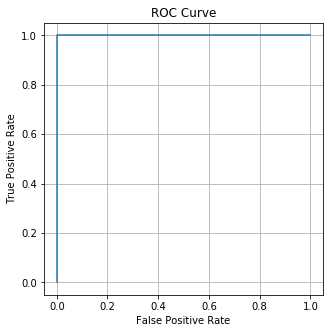

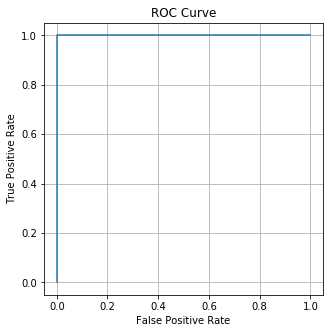

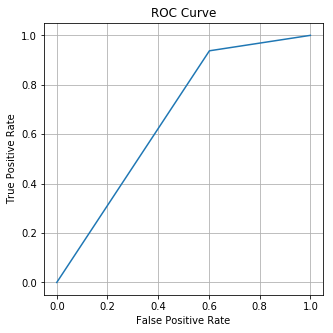

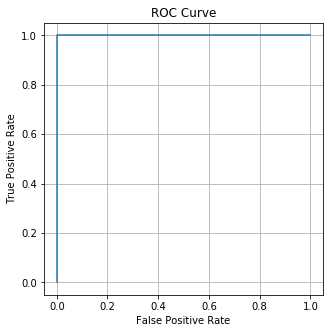

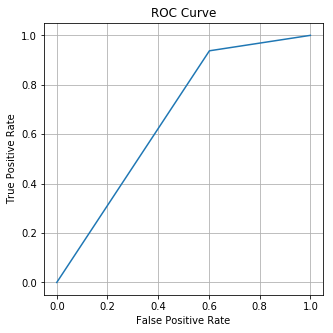

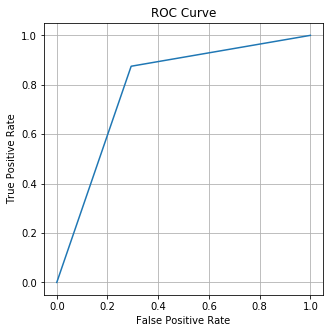

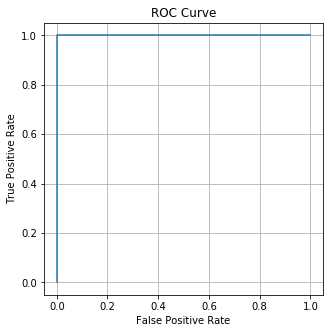

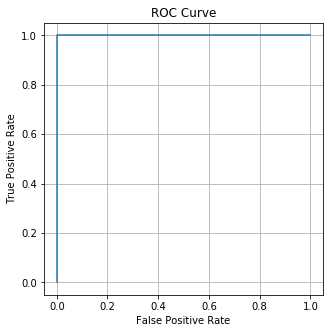

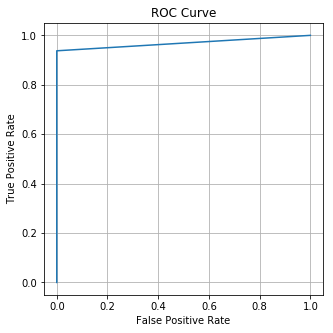

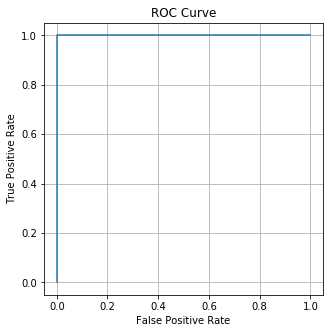

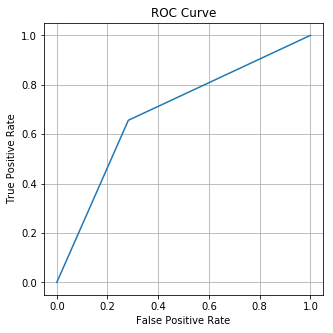

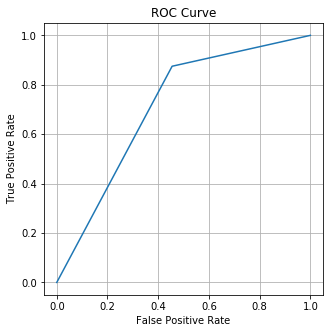

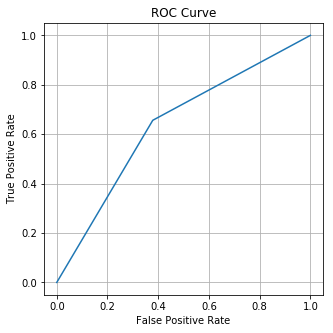

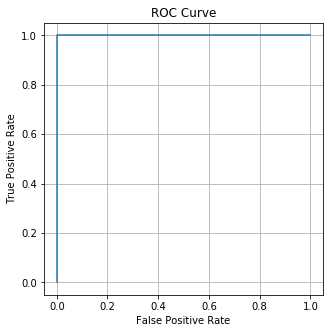

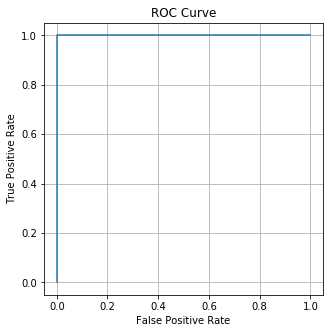

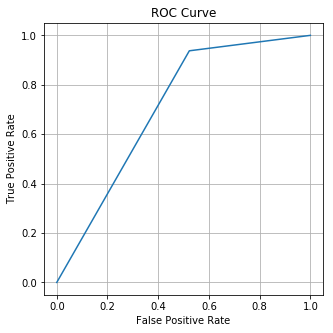

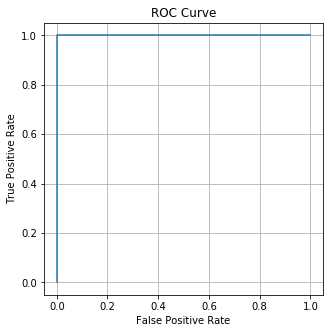

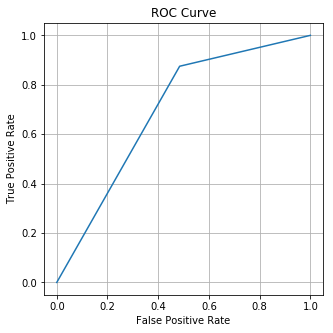

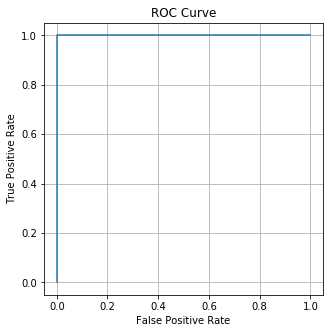

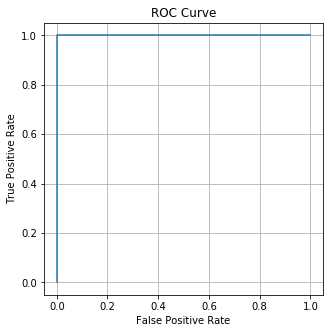

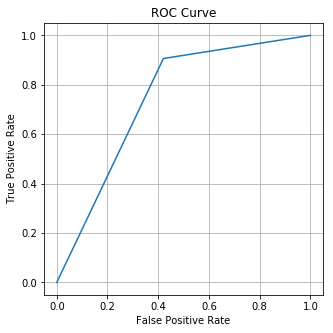

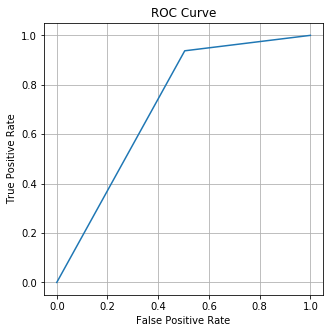

In [72]:
%time de.solve()

In [82]:
de.fitness(de.X_best)

[0. 0. 1. 1. 0.]
g_mean:0.886755379918601
 tnr:0.7863351038145824
 recall:1.0
 AUC:0.8931675553321838
 fbeta:0.06743940990516334
 precision:0.03489640130861505


d:\python\lib\site-packages\ipykernel_launcher.py:36: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
d:\python\lib\site-packages\ipykernel_launcher.py:42: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
d:\python\lib\site-packages\ipykernel_launcher.py:39: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


0.10683244466781616

# banana

In [ ]:
kddcup, X, y, k = read_data(
    filepath=r'banana\banana_data.txt',
    atr_num=2)

# Page-blocks

In [122]:
kddcup, X, y, k = read_data(
    filepath=r'page-blocks0\page-blocks0_data.txt',
    atr_num=11)

dict_items([(0, 4913), (1, 559)]) Imbalanced Ratio:8


## feature columns

In [123]:
feature_columns = []

for header in ['Atr_' + str(i) for i in [0,1,2,3,4,5,6,7]]:
    feature_columns.append(tf.feature_column.numeric_column(header))

## onehot

In [124]:
X_onehot, columns_num = get_onehot(X, feature_columns)
dataframe_onehot = pd.DataFrame(np.c_[X_onehot.numpy(), y])

In [125]:
postive_frame_onehot = dataframe_onehot[dataframe_onehot[dataframe_onehot.columns[-1]] == 1]
negative_frame_onehot = dataframe_onehot[dataframe_onehot[dataframe_onehot.columns[-1]] == 0]

## smote

In [126]:
all_minority_sample_with_target = my_smote(postive_frame_onehot.to_numpy()[:,0:-1])
k = len(all_minority_sample_with_target)

## kmeans

### merge

In [127]:
new_negative = cluster_under_sample(k, negative_frame_onehot)

In [128]:
data_target_resample = np.r_[np.c_[new_negative, np.zeros(len(new_negative))], all_minority_sample_with_target]

## ada bp

In [ ]:
model = tf.keras.Sequential([
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.AUC(name="AUC"),
        keras.metrics.Recall(name='Recall'),
        keras.metrics.Precision(name='Precision'),
    ],
)

g_mean:0.9175172819414452
 recall:0.9856887298747764
 tnr:0.8540606554040301
 fbeta:0.6031746031746031
 precision:0.43454258675078866



0.9175172819414452

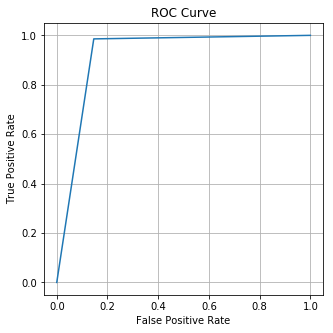

In [131]:
# 随机森林
test_learner(learner_id=5)

g_mean:0.9305141603215634
 recall:0.962432915921288
 tnr:0.8996539792387543
 fbeta:0.6767295597484276
 precision:0.521823472356935



0.9305141603215634

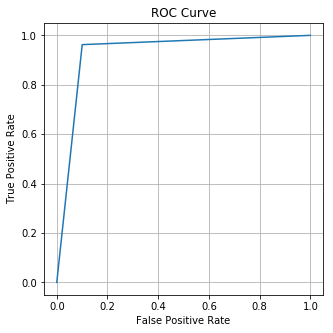

In [132]:
# 梯度提升树
test_learner(learner_id=6)

## bagging + tree

In [129]:
mybagging(data_target_resample, dataframe_onehot.to_numpy())

g_mean:0.9451688679207686
 tnr:0.8933441888866274
 recall:1.0
 AUC:0.9466720819473267
 fbeta:0.6808769792935444
 precision:0.5161588180978762


## de

In [61]:
de = DEalgorithm(5, 5, np.array([0, 0,0,0,0]),
                 np.array([2,2,3,5,2]), 6, 0.8, 0.5)
de.load_data(dataframe_onehot.to_numpy(), negative_frame_onehot, all_minority_sample_with_target)

[0. 0. 1. 2. 0.]
g_mean:0.590079497918641
 tnr:0.6423773661713821
 recall:0.5420393559928444
 AUC:0.5922083854675293
 fbeta:0.23138602520045817
 precision:0.1470873786407767
[0. 0. 2. 3. 0.]
[0. 0. 2. 3. 0.]
g_mean:4.229549340594997e-05
 tnr:1.0
 recall:1.788908762452757e-09
 AUC:0.5
 fbeta:3.57142856505102e-09
 precision:1e-06
[0. 0. 2. 2. 1.]
[0. 0. 2. 2. 1.]
g_mean:0.913000320283069
 tnr:0.8581314878892734
 recall:0.9713774597495528
 AUC:0.9147543907165527
 fbeta:0.60366870483602
 precision:0.43790322580645163
[0. 0. 0. 4. 0.]
g_mean:0.8912497429272724
 tnr:0.8827600244249949
 recall:0.8998211091234347
 AUC:0.891290545463562
 fbeta:0.6141636141636141
 precision:0.46617238183503246
[0. 0. 0. 3. 0.]
g_mean:0.9145933891811955
 tnr:0.9761856299613271
 recall:0.8568872987477638
 AUC:0.9165365099906921
 fbeta:0.8294372294372294
 precision:0.8036912751677853
[1. 0. 0. 4. 0.]
g_mean:0.8821666026292
 tnr:0.9539995929167515
 recall:0.815742397137746
 AUC:0.8848709464073181
 fbeta:0.7348912167

g_mean:0.9145933891811955
 tnr:0.9761856299613271
 recall:0.8568872987477638
 AUC:0.9165365099906921
 fbeta:0.8294372294372294
 precision:0.8036912751677853
[0. 0. 1. 3. 0.]
g_mean:0.9145933891811955
 tnr:0.9761856299613271
 recall:0.8568872987477638
 AUC:0.9165365099906921
 fbeta:0.8294372294372294
 precision:0.8036912751677853
[0. 0. 2. 1. 0.]
[0. 0. 2. 1. 0.]
g_mean:0.9521312955099742
 tnr:0.913087726440057
 recall:0.9928443649373881
 AUC:0.952966034412384
 fbeta:0.7203114860480206
 precision:0.5651731160896131
[0. 0. 2. 1. 0.]
[0. 0. 2. 1. 0.]
g_mean:0.9542754244844373
 tnr:0.9122735599430083
 recall:0.998211091234347
 AUC:0.9552423357963562
 fbeta:0.7209302325581395
 precision:0.564206268958544
[0. 0. 1. 3. 0.]
g_mean:0.9145933891811955
 tnr:0.9761856299613271
 recall:0.8568872987477638
 AUC:0.9165365099906921
 fbeta:0.8294372294372294
 precision:0.8036912751677853
[0. 0. 2. 1. 0.]
0.04781079292297363
[0. 0. 1. 2. 0.]
g_mean:0.590079497918641
 tnr:0.6423773661713821
 recall:0.5420

g_mean:0.9249635355073395
 tnr:0.9006716873600651
 recall:0.9499105545617174
 AUC:0.9252911806106567
 fbeta:0.6730038022813688
 precision:0.521099116781158
[0. 0. 2. 1. 0.]
[0. 0. 2. 1. 0.]
g_mean:0.9343734515731273
 tnr:0.8746183594545085
 recall:0.998211091234347
 AUC:0.9364147186279297
 fbeta:0.6439699942296595
 precision:0.4752981260647359
[0. 0. 1. 1. 0.]
g_mean:0.9249635355073395
 tnr:0.9006716873600651
 recall:0.9499105545617174
 AUC:0.9252911806106567
 fbeta:0.6730038022813688
 precision:0.521099116781158
[0. 0. 2. 0. 0.]
[0. 0. 2. 0. 0.]
g_mean:0.6235653010278347
 tnr:0.9879910441685325
 recall:0.3935599284436494
 AUC:0.6907755136489868
 fbeta:0.5250596658711217
 precision:0.7885304659498208
[0. 0. 1. 1. 0.]
g_mean:0.9249635355073395
 tnr:0.9006716873600651
 recall:0.9499105545617174
 AUC:0.9252911806106567
 fbeta:0.6730038022813688
 precision:0.521099116781158
[0. 0. 1. 3. 0.]
g_mean:0.9145933891811955
 tnr:0.9761856299613271
 recall:0.8568872987477638
 AUC:0.9165365099906921

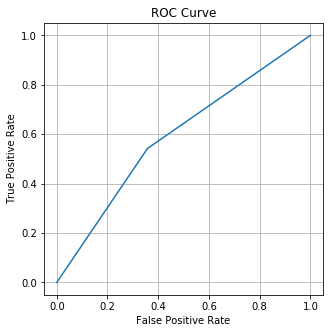

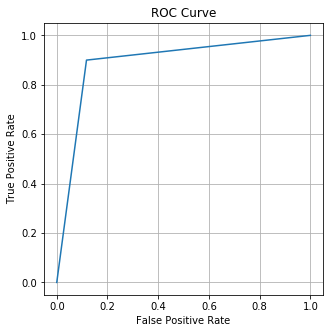

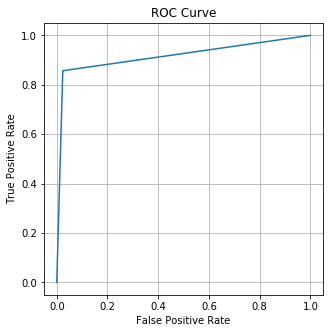

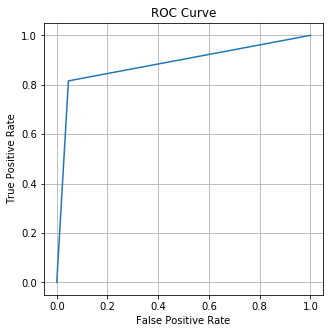

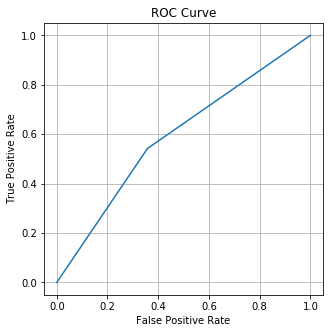

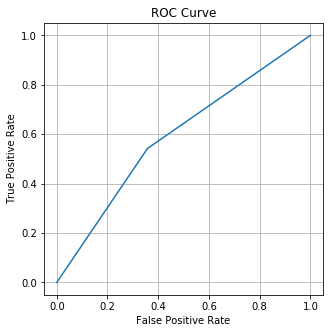

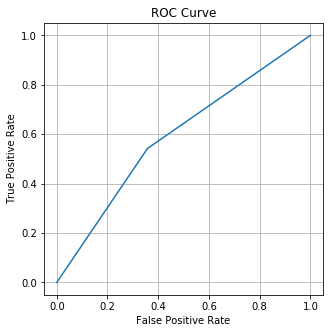

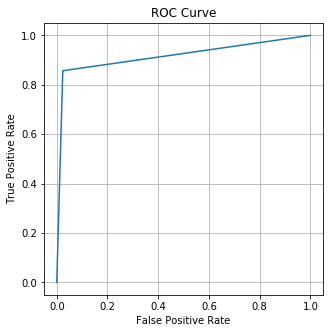

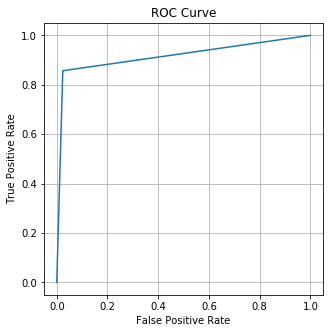

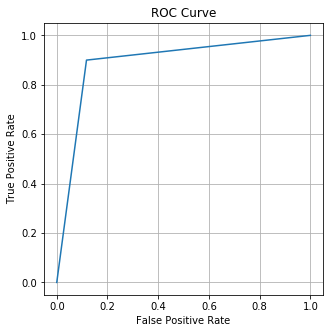

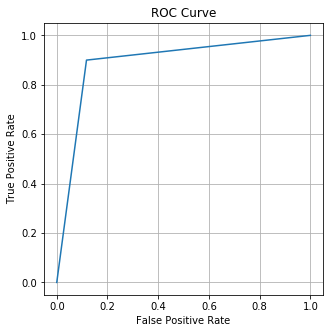

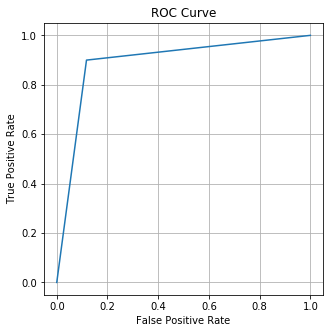

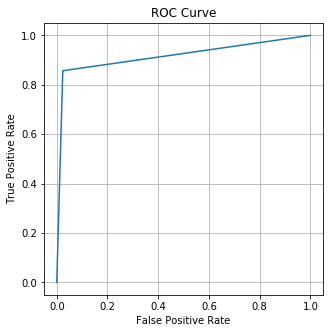

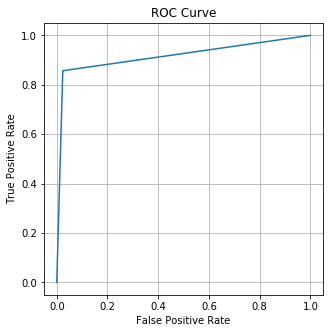

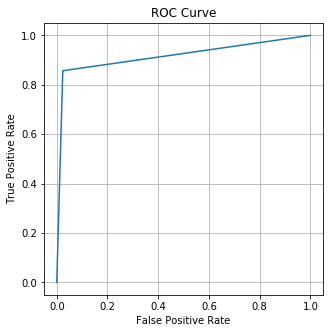

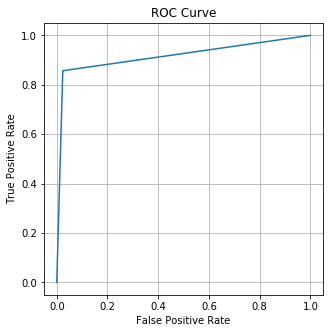

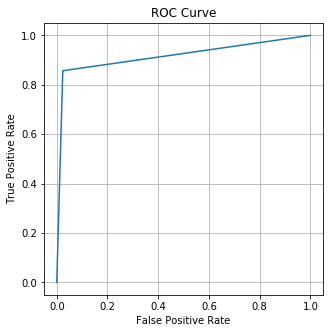

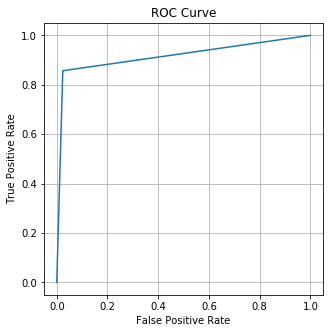

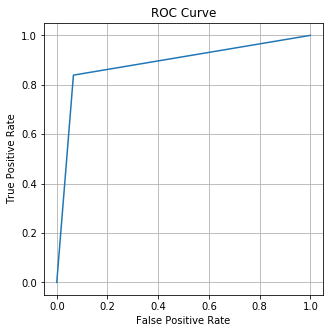

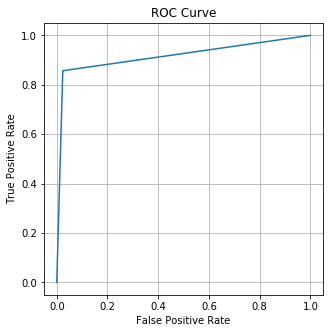

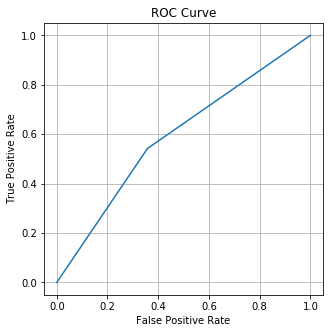

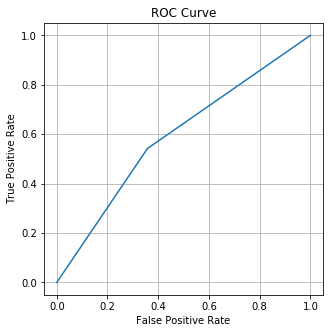

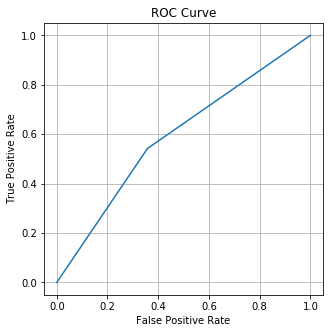

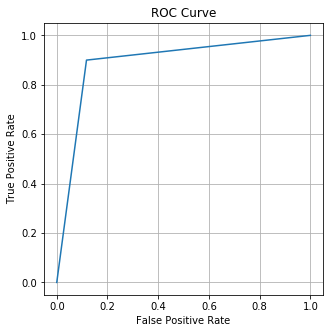

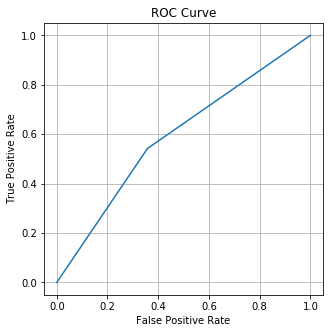

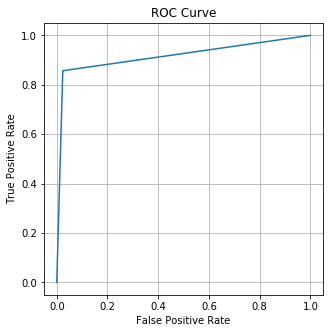

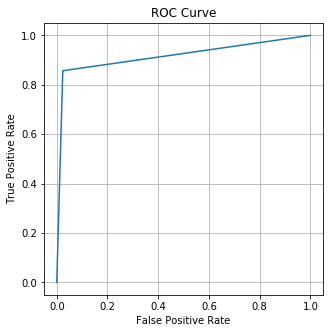

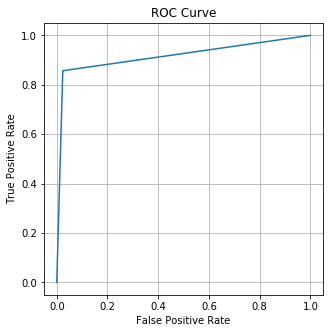

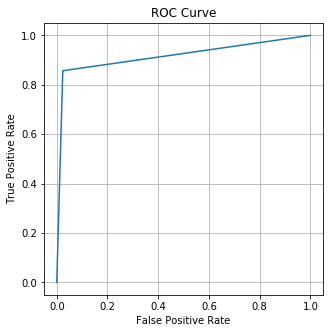

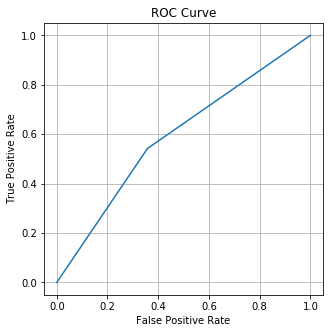

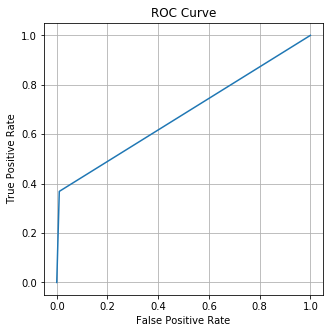

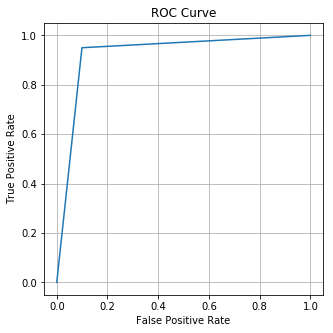

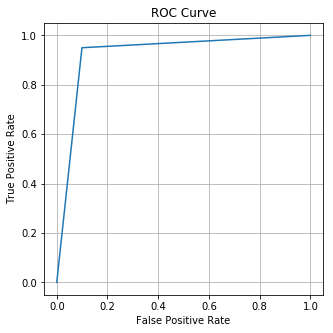

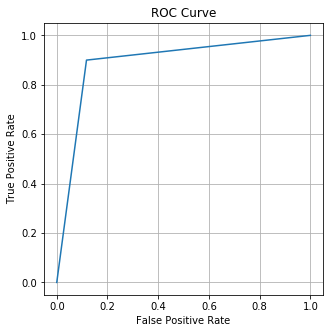

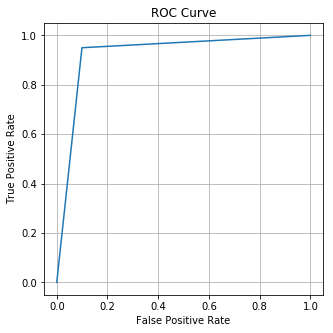

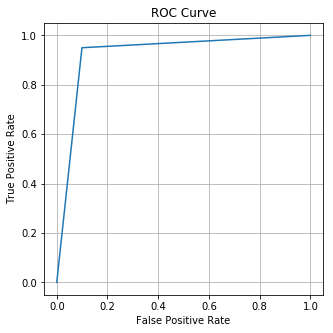

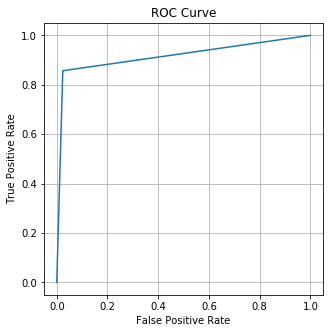

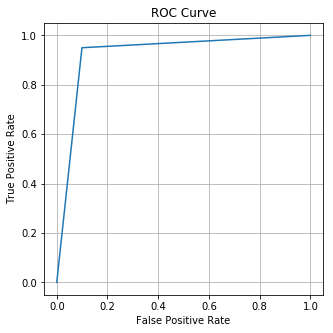

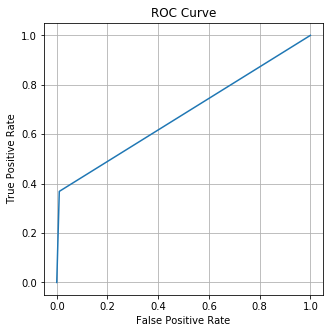

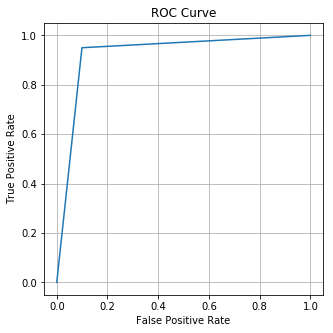

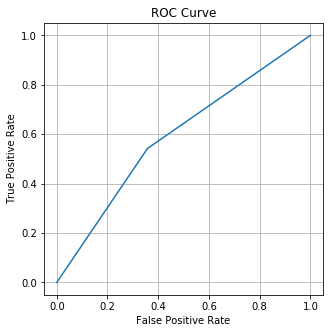

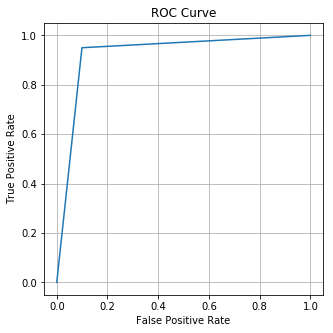

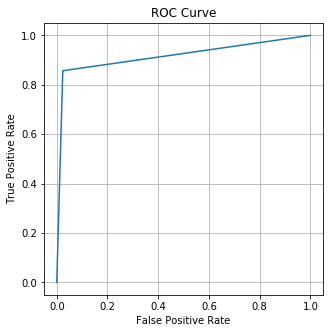

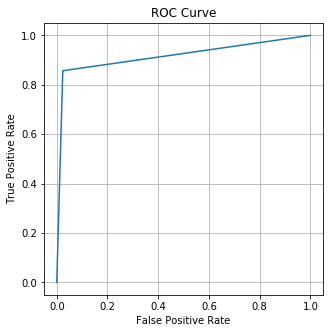

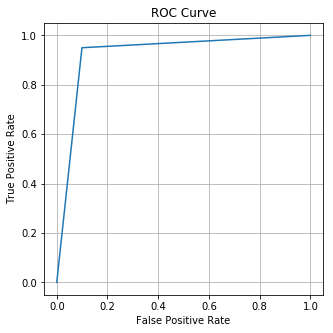

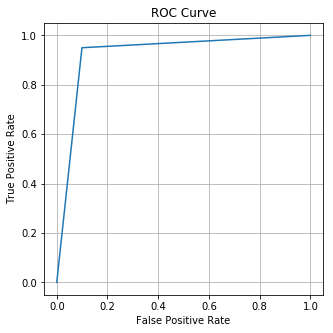

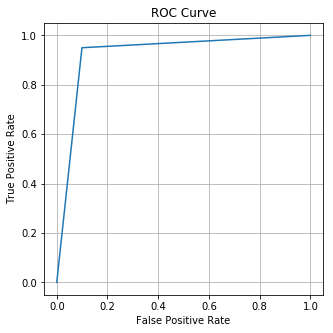

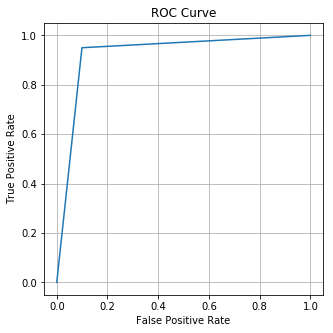

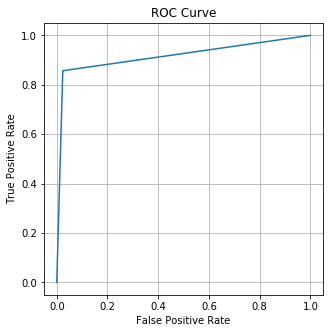

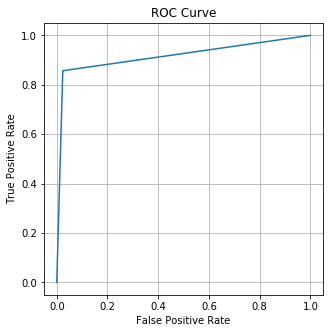

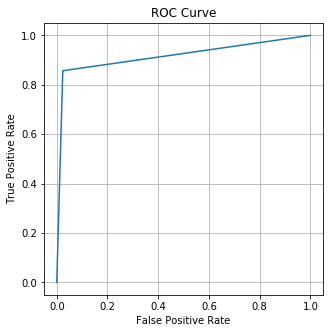

In [62]:
%time de.solve()

In [64]:
de.fitness(de.X_best)

[0. 0. 2. 1. 0.]
[0. 0. 2. 1. 0.]
g_mean:0.9581001910145626
 tnr:0.9196010584164461
 recall:0.998211091234347
 AUC:0.9589061141014099
 fbeta:0.7380952380952381
 precision:0.5855194123819517


0.04109388589859009

# segment0

In [133]:
kddcup, X, y, k = read_data(
    filepath=r'segment0\segment0_data.txt',
    atr_num=20)

dict_items([(0, 1979), (1, 329)]) Imbalanced Ratio:6


## feature columns

In [134]:
feature_columns = []

for header in ['Atr_' + str(i) for i in range(0,19)]:
    feature_columns.append(tf.feature_column.numeric_column(header))

## onehot

In [135]:
X_onehot, columns_num = get_onehot(X, feature_columns)
dataframe_onehot = pd.DataFrame(np.c_[X_onehot.numpy(), y])

In [136]:
postive_frame_onehot = dataframe_onehot[dataframe_onehot[dataframe_onehot.columns[-1]] == 1]
negative_frame_onehot = dataframe_onehot[dataframe_onehot[dataframe_onehot.columns[-1]] == 0]

## smote

In [137]:
all_minority_sample_with_target = my_smote(postive_frame_onehot.to_numpy()[:,0:-1])
k = len(all_minority_sample_with_target)

## kmeans

### merge

In [138]:
new_negative = cluster_under_sample(k, negative_frame_onehot)

In [139]:
data_target_resample = np.r_[np.c_[new_negative, np.zeros(len(new_negative))], all_minority_sample_with_target]

## ada bp

g_mean:0.9967101011681336
 recall:1.0
 tnr:0.9934310257705912
 fbeta:0.9806259314456036
 precision:0.9619883040935673



0.9967101011681336

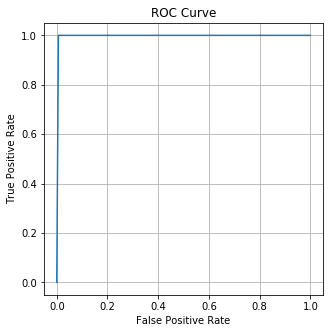

In [141]:
# 随机森林
test_learner(learner_id=5)

g_mean:0.9944261030267662
 recall:1.0
 tnr:0.9888832743810005
 fbeta:0.9676470588235295
 precision:0.9373219373219374



0.9944261030267662

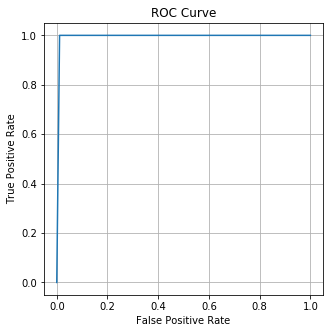

In [142]:
# 梯度提升树
test_learner(learner_id=6)

## bagging + tree

In [143]:
mybagging(data_target_resample, dataframe_onehot.to_numpy())

g_mean:0.9964565821252006
 tnr:0.9929257200606367
 recall:1.0
 AUC:0.9964628219604492
 fbeta:0.9791666666666666
 precision:0.9591836734693877


## de

In [87]:
de = DEalgorithm(5, 5, np.array([0, 0,0,0,0]),
                 np.array([2,2,3,5,2]), 6, 0.8, 0.5)
de.load_data(dataframe_onehot.to_numpy(), negative_frame_onehot, all_minority_sample_with_target)

[1. 0. 0. 0. 0.]
g_mean:0.9075337952679966
 tnr:0.8337544214249621
 recall:0.9878419452887538
 AUC:0.910798192024231
 fbeta:0.6612410986775178
 precision:0.4969418960244648
[0. 1. 2. 4. 1.]
0.00303572416305542 [1 1 1 1 0 0 0 1 1 1 1 0 0 1 0 1 0 0 1]
[0. 1. 2. 4. 1.]
g_mean:0.9644123523733685
 tnr:1.0
 recall:0.9300911854103343
 AUC:0.9650455713272095
 fbeta:0.9637795275590552
 precision:1.0
[1. 0. 0. 4. 0.]
g_mean:0.9928974250076419
 tnr:0.9979787771601819
 recall:0.9878419452887538
 AUC:0.9929103851318359
 fbeta:0.9878419452887538
 precision:0.9878419452887538
[1. 1. 1. 0. 0.]
0.05482947826385498 [0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[1. 1. 1. 4. 0.]
0.0060790181159973145 [0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 0 1 0 1]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[1. 1. 0. 0. 0.]
0.04198259115219116 [0 0 1 0 0 1 1 0 0 1 1 0 0 1 0 0 0 0 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.

0.025782108306884766 [1 1 0 0 0 1 0 0 0 1 1 0 1 0 0 0 1 0 1]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 0. 0. 0.]
0.029085755348205566 [1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 1. 0. 0.]
0.023783981800079346 [1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 0. 0. 0.]
0.02681189775466919 [0 0 0 0 0 1 0 1 0 1 1 0 1 0 1 0 0 0 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[1. 1. 0. 0. 0.]
0.02554863691329956 [0 0 1 0 0 1 0 0 0 1 1 1 1 0 0 0 0 0 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 0. 0. 0.]
0.027581393718719482 [0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 0. 0. 0.]
0.03894305229187012 [0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1

g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 0. 0. 0.]
0.02503180503845215 [1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 0. 0. 0.]
0.055606722831726074 [1 0 1 0 1 1 0 1 0 1 0 0 1 1 0 0 0 0 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 0. 0. 0.]
0.02680426836013794 [1 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 0. 0. 0.]
0.07355266809463501 [1 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 1]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 0. 0. 0.]
0.059400320053100586 [0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 0 0 0 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 0. 0. 0.]
0.033633530139923096 [0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 0. 0. 0.]
0.028833091259002686 [0 0 0 0 0 1 0 0 0 1 1 0 0 0

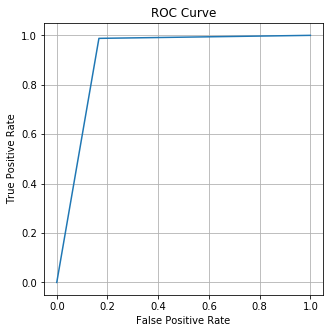

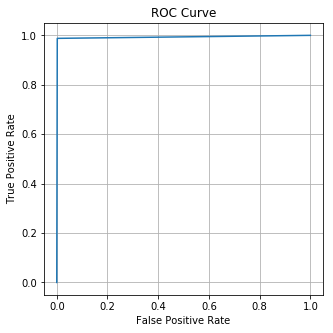

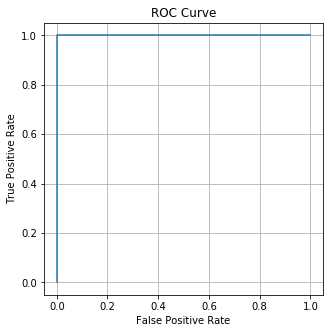

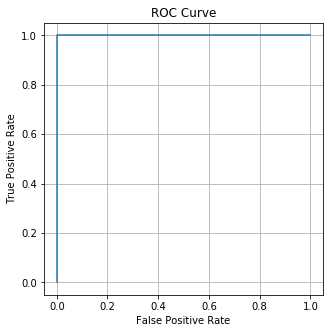

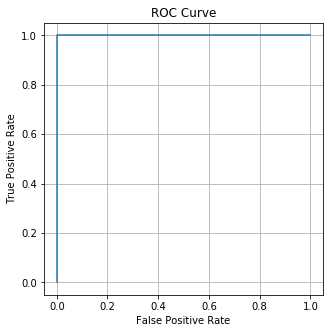

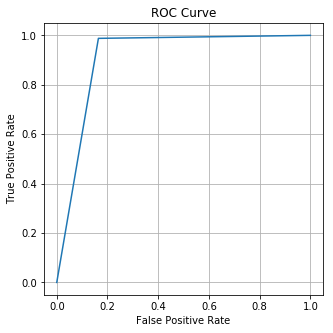

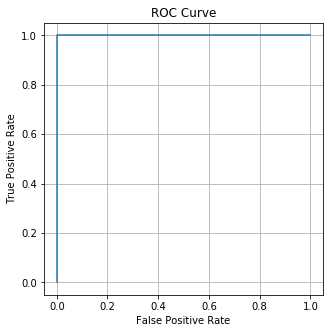

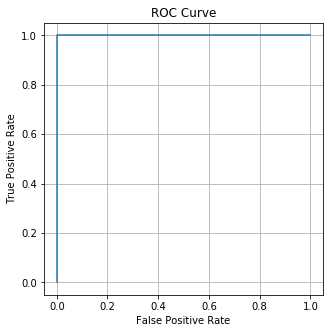

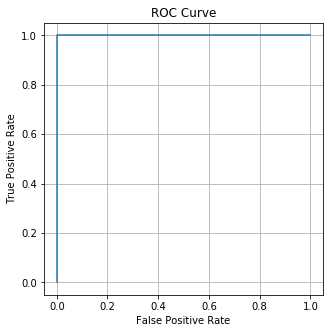

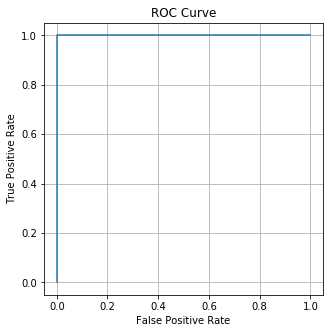

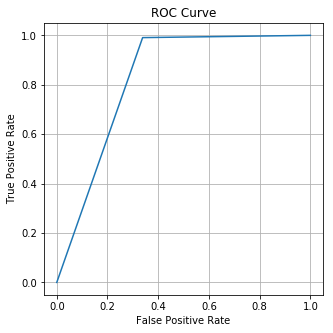

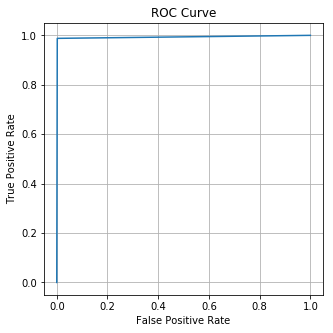

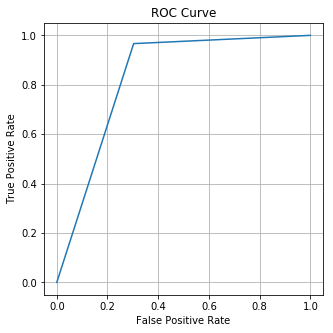

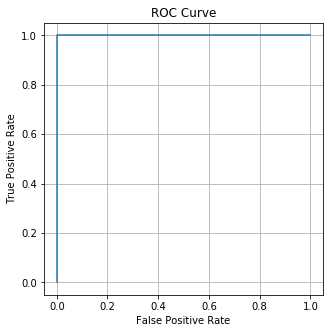

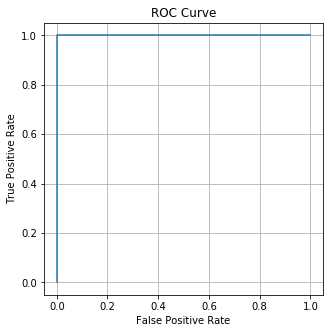

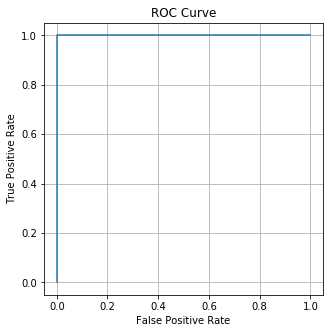

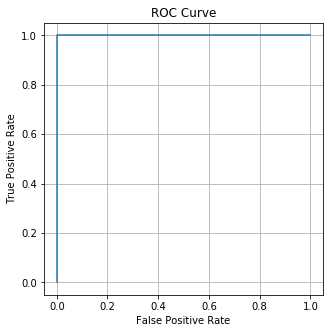

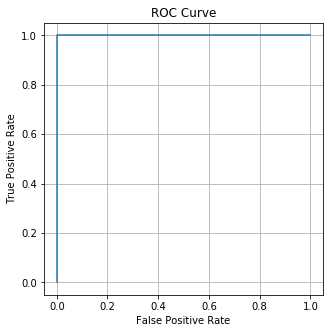

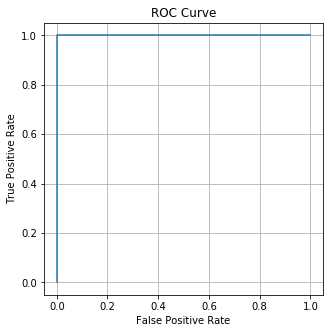

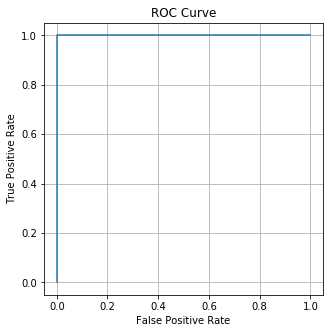

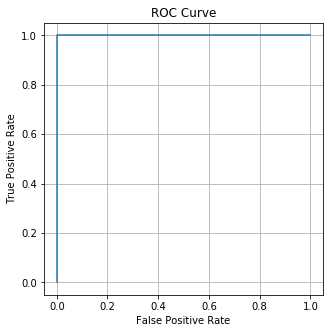

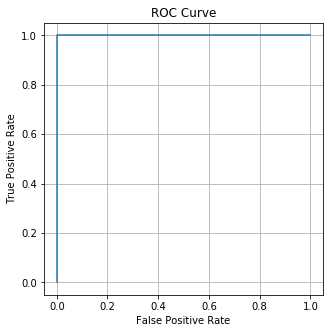

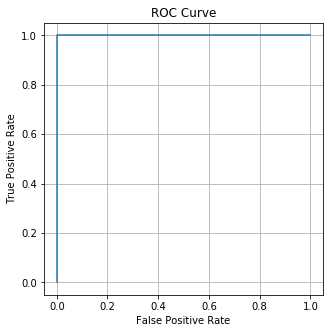

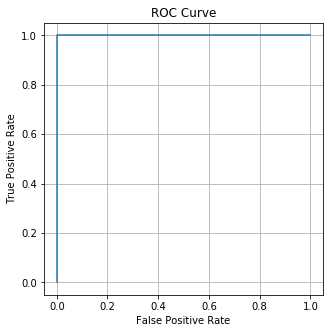

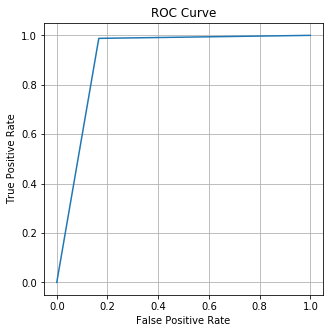

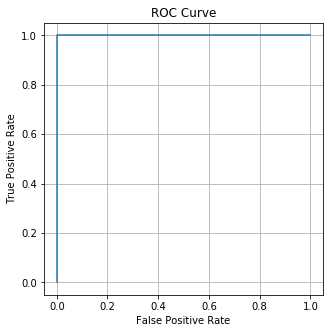

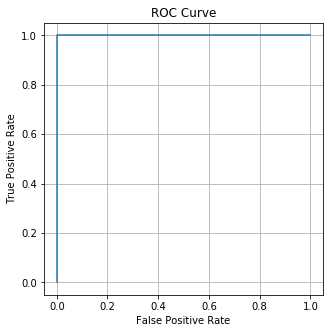

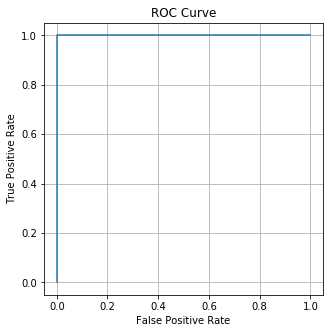

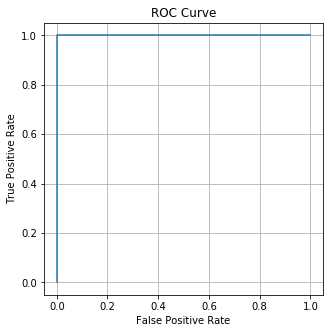

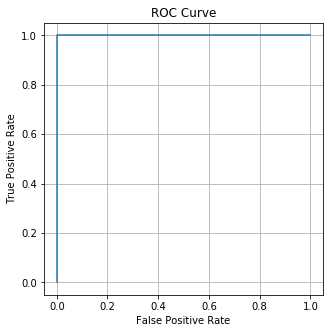

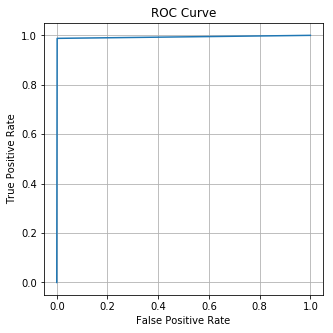

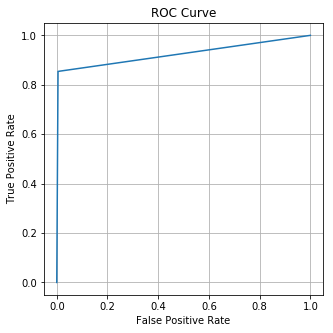

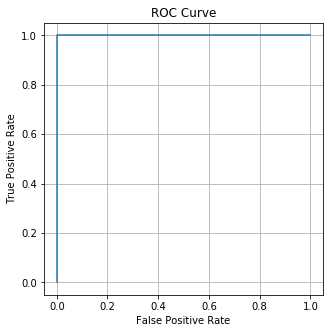

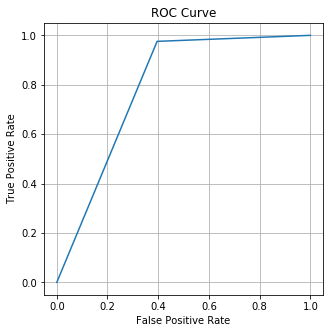

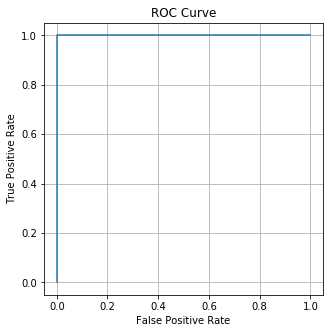

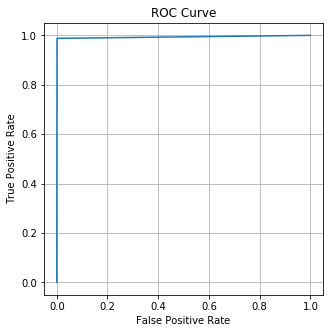

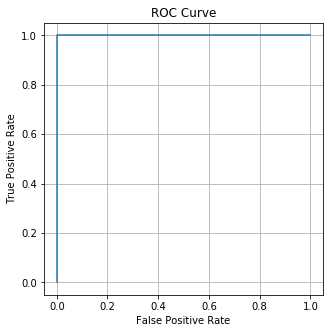

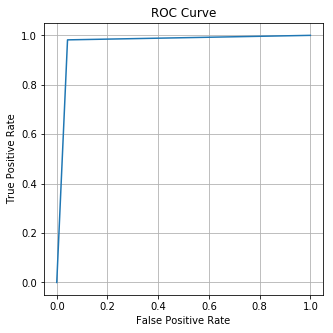

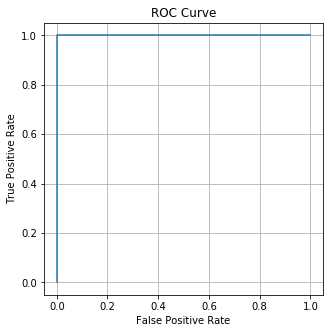

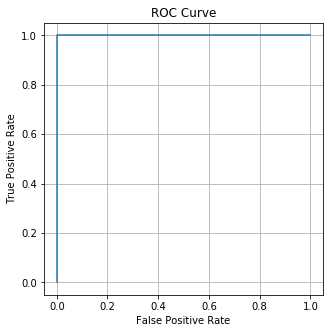

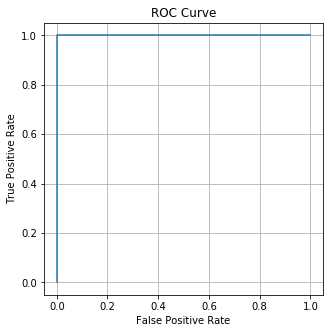

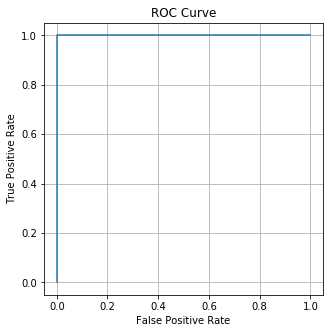

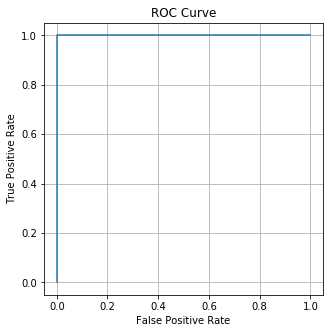

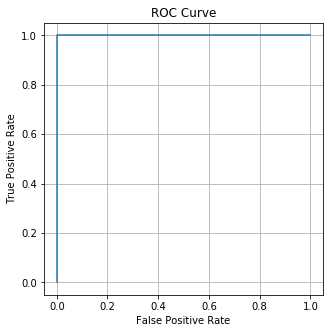

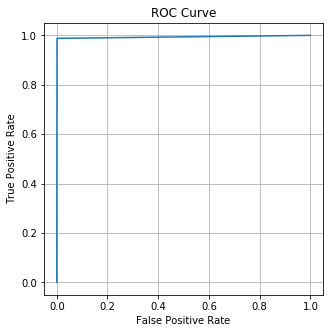

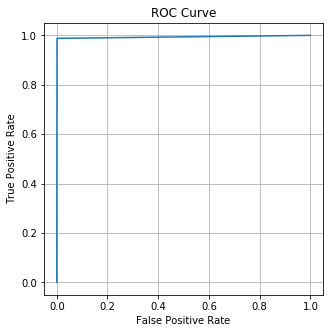

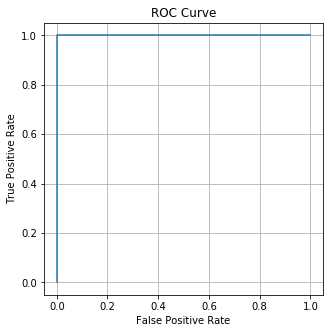

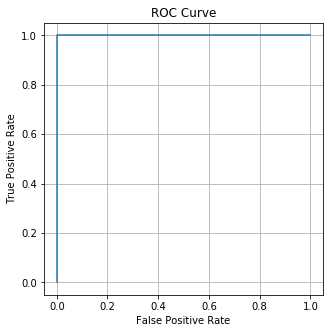

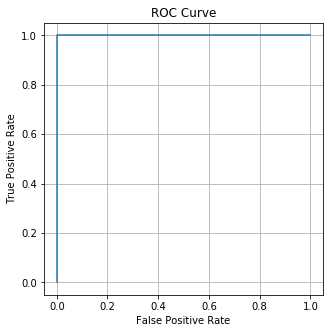

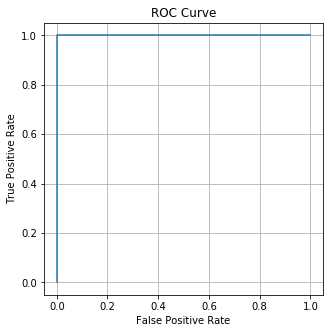

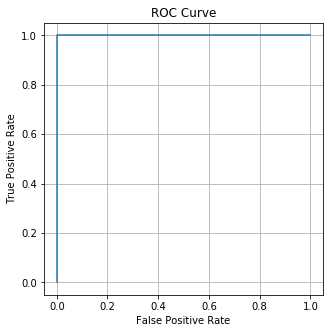

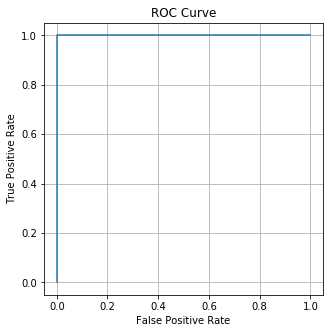

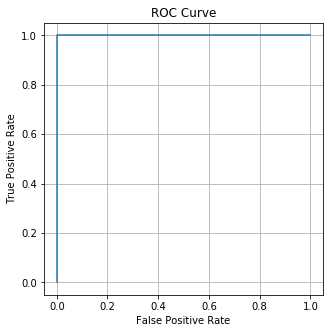

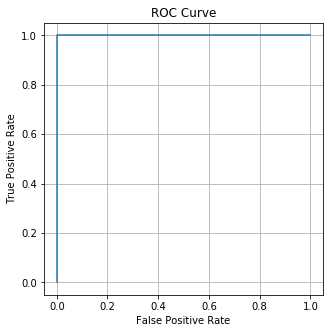

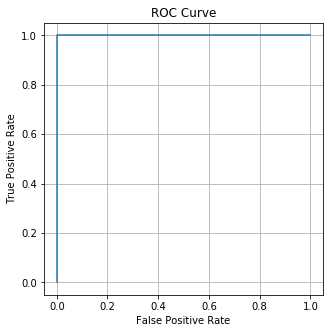

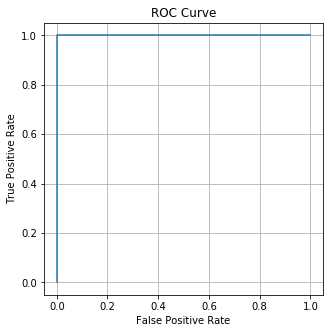

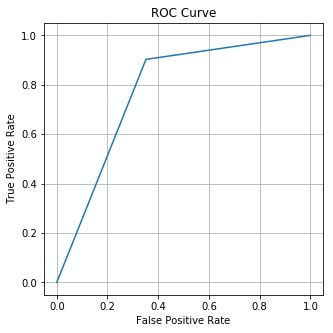

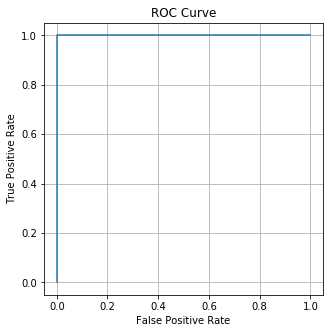

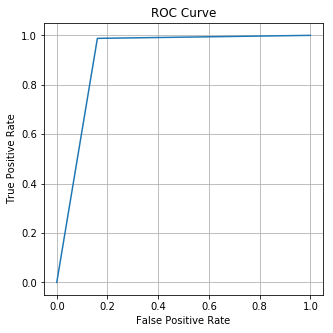

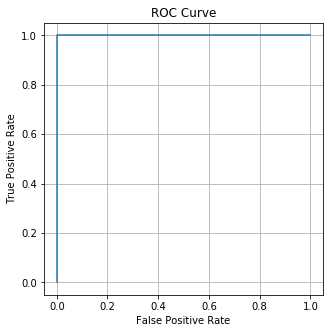

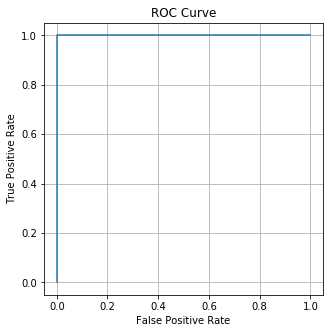

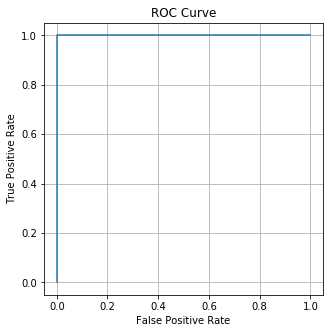

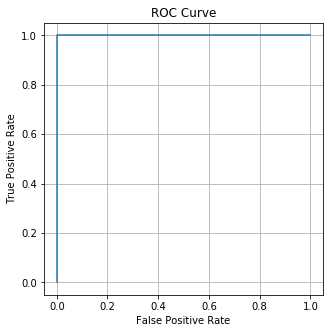

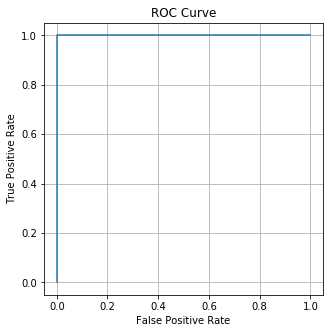

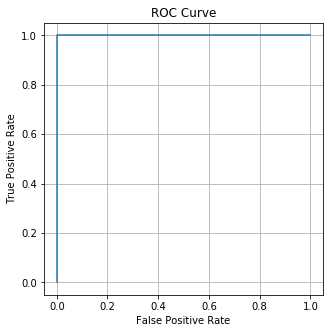

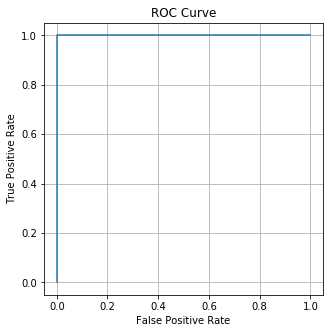

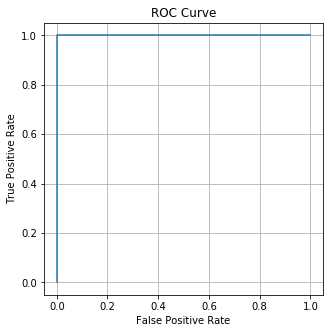

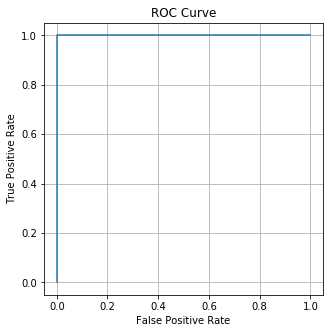

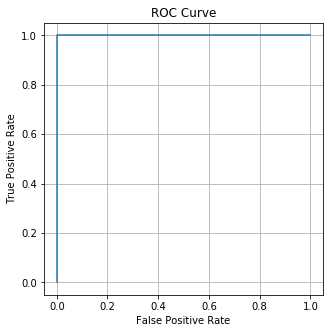

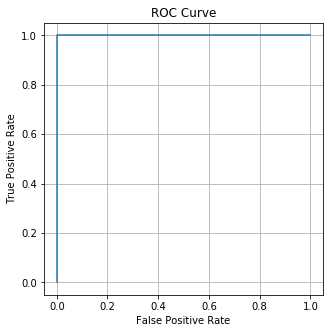

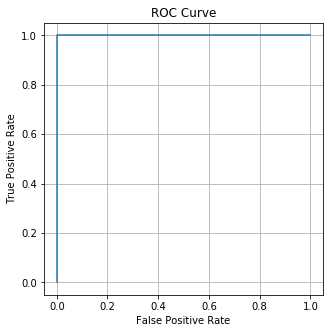

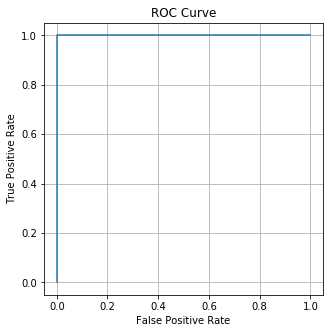

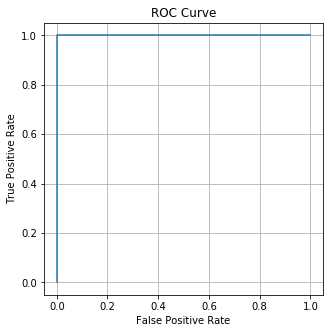

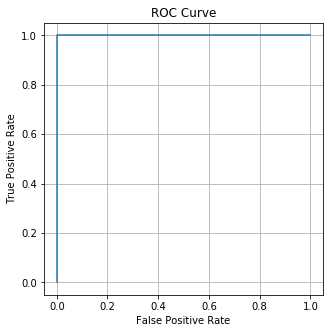

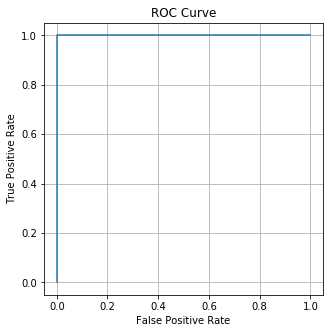

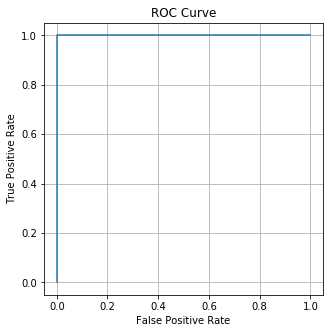

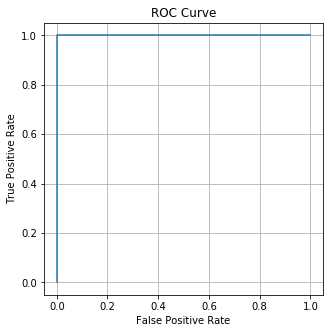

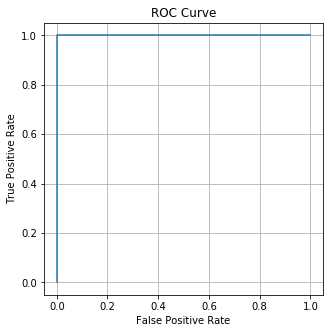

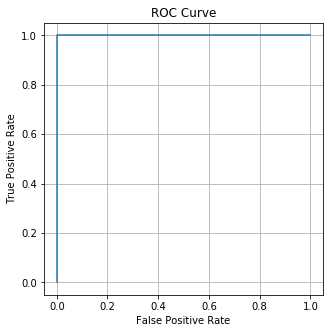

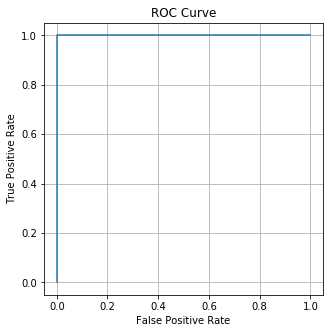

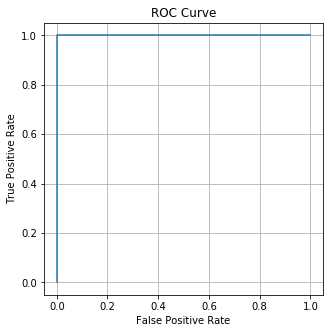

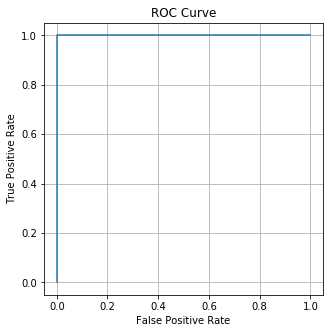

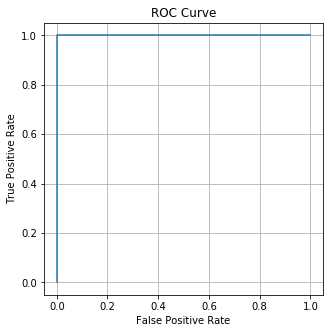

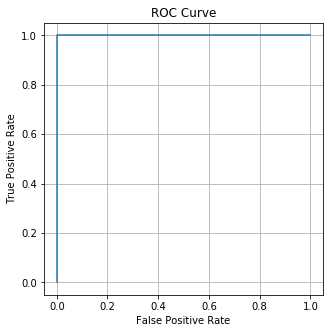

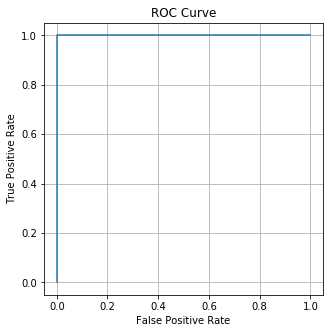

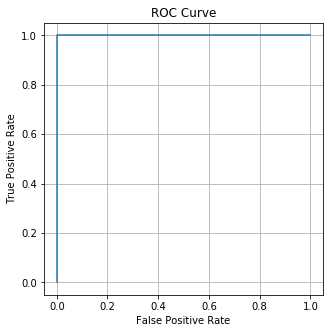

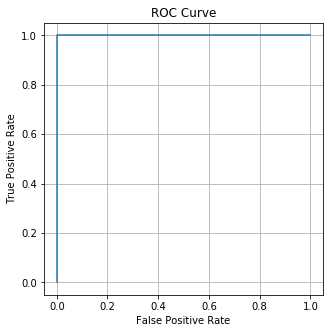

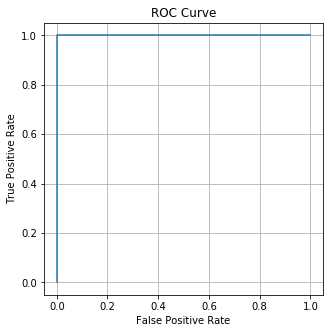

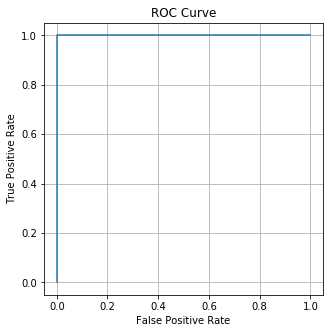

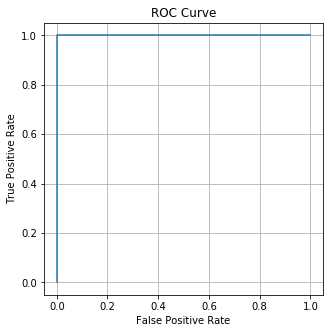

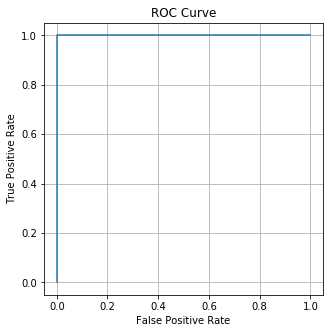

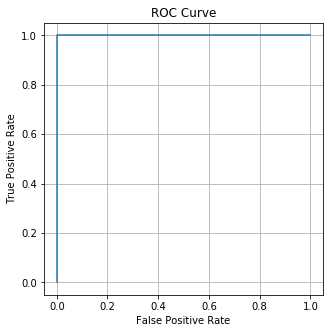

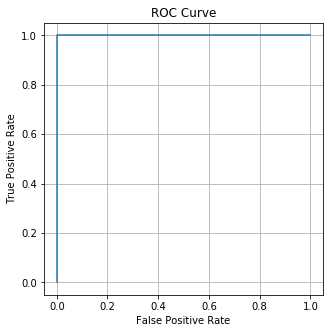

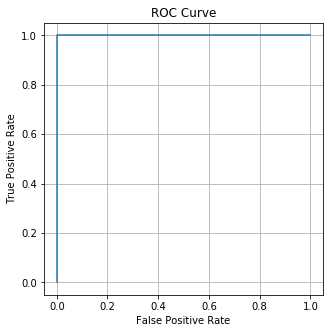

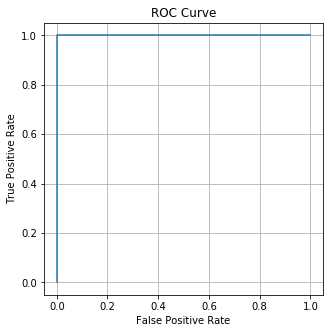

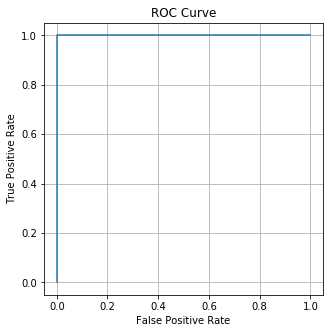

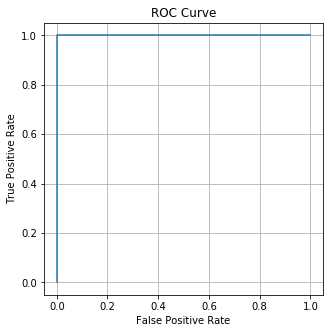

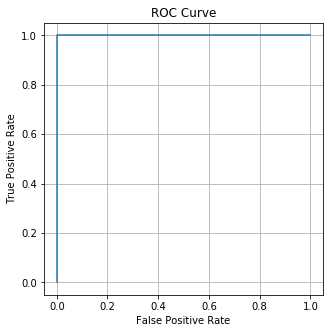

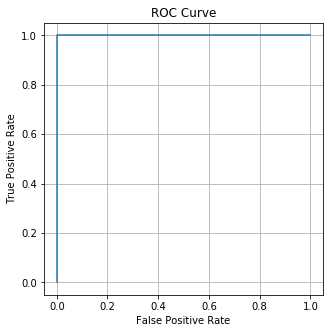

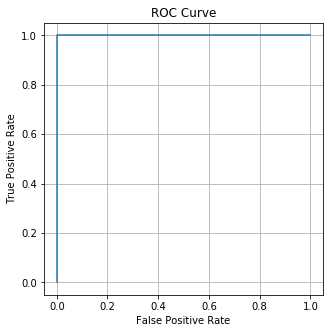

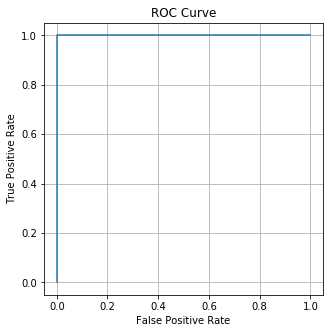

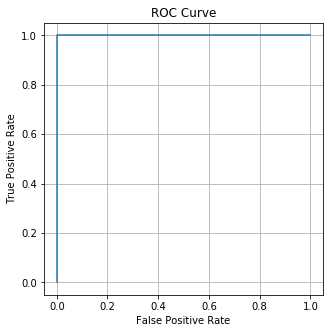

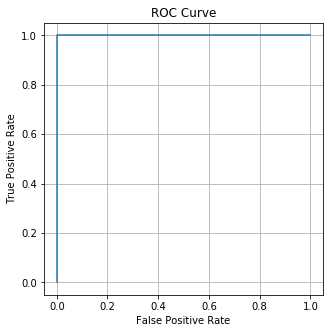

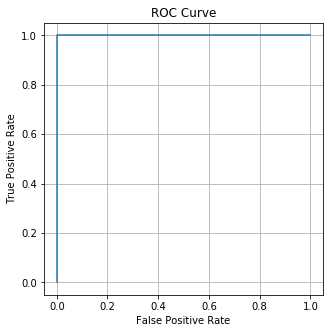

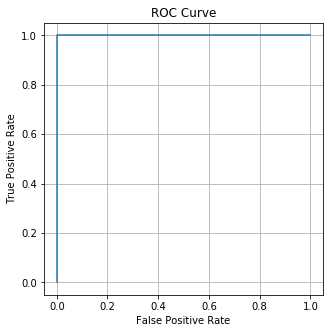

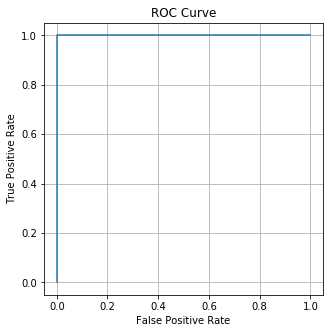

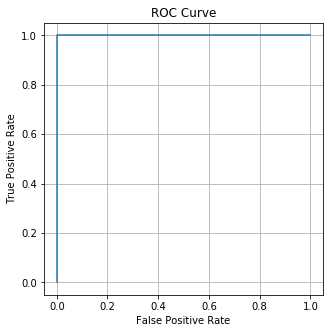

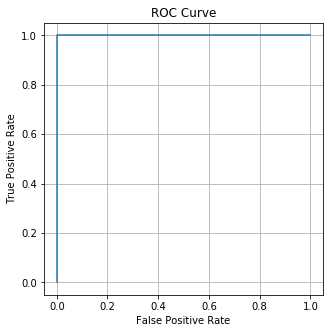

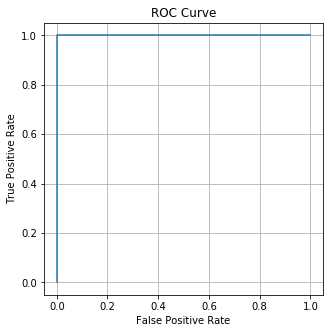

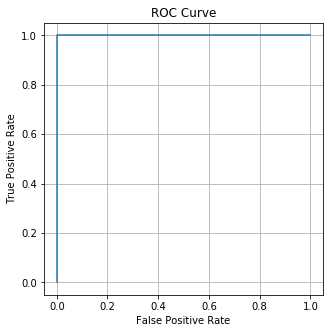

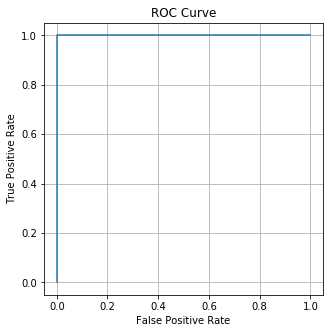

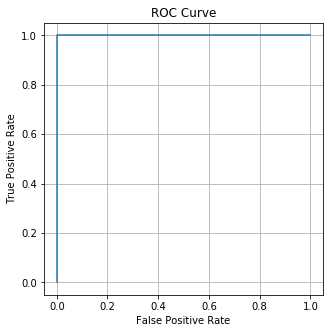

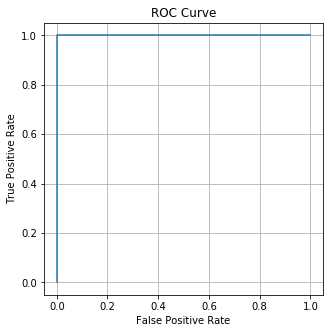

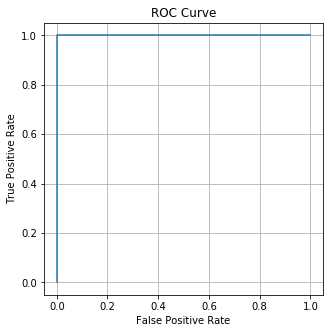

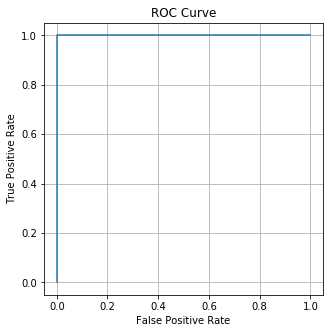

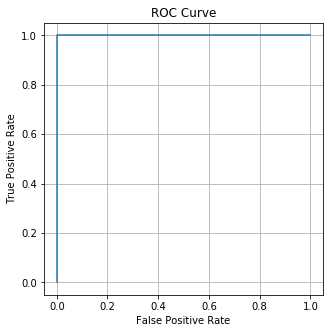

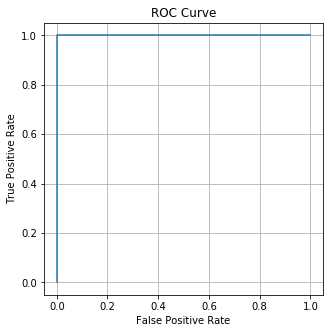

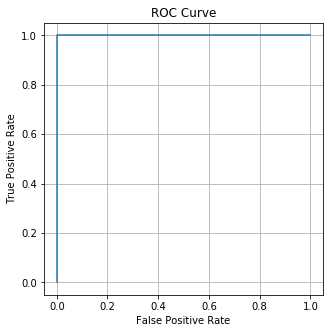

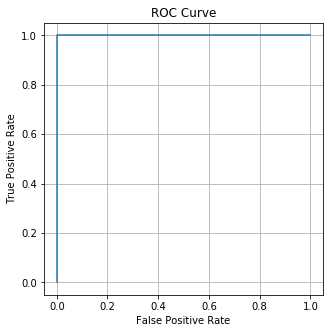

In [88]:
%time de.solve()

[0. 1. 0. 0. 0.]
0.06014668941497803 [0 0 0 0 0 1 1 1 0 1 0 0 1 0 0 1 0 0 1]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0


0.0

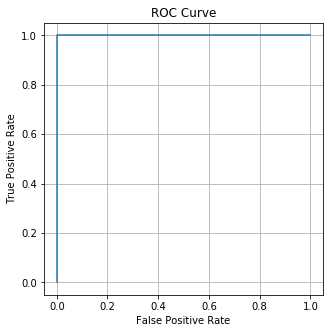

In [89]:
de.fitness(de.X_best)

# shuttle-c0-vs-c4

In [144]:
kddcup, X, y, k = read_data(
    filepath=r'shuttle-c0-vs-c4\shuttle-c0-vs-c4_data.txt',
    atr_num=10)

dict_items([(0, 1706), (1, 123)]) Imbalanced Ratio:13


## feature columns

In [145]:
feature_columns = []

for header in ['Atr_' + str(i) for i in [0,1,2,3,4,5,6,7,8]]:
    feature_columns.append(tf.feature_column.numeric_column(header))

## onehot

In [146]:
X_onehot, columns_num = get_onehot(X, feature_columns)
dataframe_onehot = pd.DataFrame(np.c_[X_onehot.numpy(), y])

In [147]:
postive_frame_onehot = dataframe_onehot[dataframe_onehot[dataframe_onehot.columns[-1]] == 1]
negative_frame_onehot = dataframe_onehot[dataframe_onehot[dataframe_onehot.columns[-1]] == 0]

## smote

In [148]:
all_minority_sample_with_target = my_smote(postive_frame_onehot.to_numpy()[:,0:-1])
k = len(all_minority_sample_with_target)

## kmeans

### merge

In [149]:
new_negative = cluster_under_sample(k, negative_frame_onehot)

In [150]:
data_target_resample = np.r_[np.c_[new_negative, np.zeros(len(new_negative))], all_minority_sample_with_target]

## ada bp

g_mean:1.0
 recall:1.0
 tnr:1.0
 fbeta:1.0
 precision:1.0



1.0

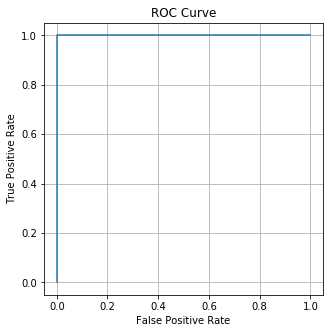

In [152]:
# 随机森林
test_learner(learner_id=5)

g_mean:1.0
 recall:1.0
 tnr:1.0
 fbeta:1.0
 precision:1.0



1.0

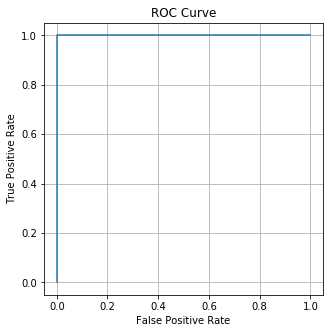

In [153]:
# 梯度提升树
test_learner(learner_id=6)

## bagging + tree

In [155]:
mybagging(data_target_resample, dataframe_onehot.to_numpy())

g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0


## de

In [99]:
de = DEalgorithm(5, 5, np.array([0, 0,0,0,0]),
                 np.array([2,2,3,5,2]), 6, 0.8, 0.5)
de.load_data(dataframe_onehot.to_numpy(), negative_frame_onehot, all_minority_sample_with_target)

[0. 1. 2. 2. 0.]
0.0 [1 1 1 1 0 1 1 1 1]
[0. 1. 2. 2. 0.]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[1. 0. 2. 2. 0.]
[1. 0. 2. 2. 0.]
g_mean:0.9994136616323814
 tnr:0.9988276670574443
 recall:1.0
 AUC:0.9994138479232788
 fbeta:0.9919354838709677
 precision:0.984
[0. 0. 0. 1. 1.]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[1. 1. 1. 4. 0.]
0.0 [1 0 0 0 1 0 1 1 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[1. 0. 1. 2. 1.]
g_mean:0.997358762812309
 tnr:0.9947245017584995
 recall:1.0
 AUC:0.9973622560501099
 fbeta:0.9647058823529412
 precision:0.9318181818181818
[1. 0. 2. 3. 1.]
[1. 0. 2. 3. 1.]
g_mean:0.0
 tnr:0.0
 recall:1.0
 AUC:0.5
 fbeta:0.12602459016393444
 precision:0.06724986331328595
[0. 1. 2. 2. 0.]
0.0 [1 0 1 0 0 1 0 0 1]
[0. 1. 2. 2. 0.]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 0. 3. 0.]
0.0 [1 0 0 0 0 0 1 1 1]
g_mean:0.9672237011981444
 tnr:0.9355216881594373
 recall:1.0
 

[0. 0. 2. 4. 0.]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 0. 2. 4. 0.]
[0. 0. 2. 4. 0.]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 1. 4. 0.]
0.0 [1 0 1 1 0 0 1 1 1]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 0. 2. 4. 0.]
[0. 0. 2. 4. 0.]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 0. 0. 1. 1.]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 0. 2. 1. 0.]
[0. 0. 2. 1. 0.]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 0. 2. 1. 0.]
[0. 0. 2. 1. 0.]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 0. 2. 4. 0.]
[0. 0. 2. 4. 0.]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 0. 2. 1. 0.]
[0. 0. 2. 1. 0.]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 0. 1. 4. 0.]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 0. 1. 3. 0.]
g_mean:0.97112791

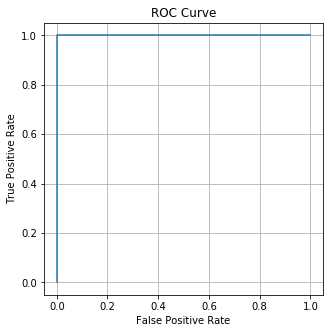

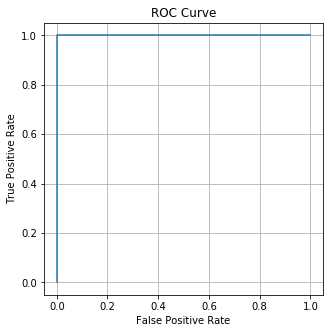

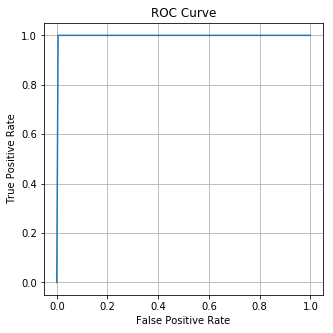

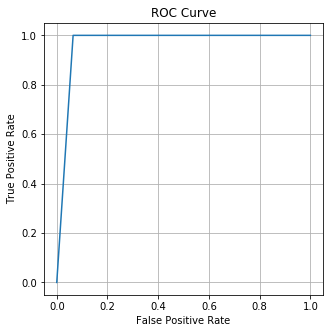

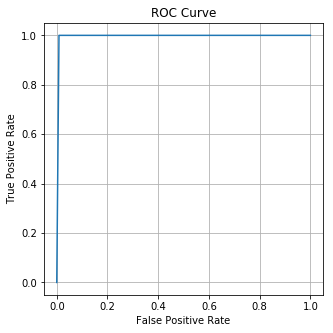

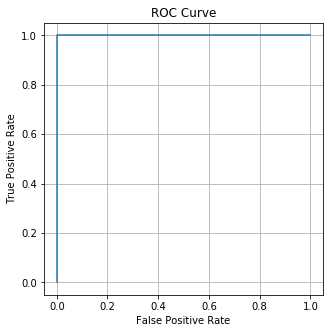

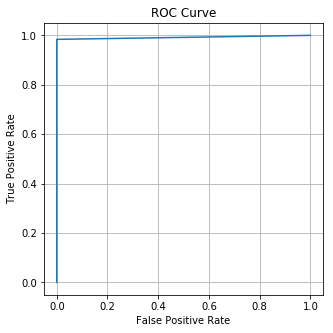

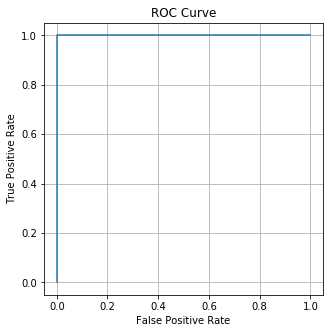

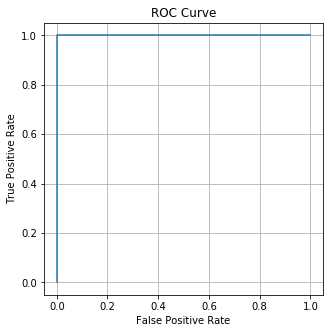

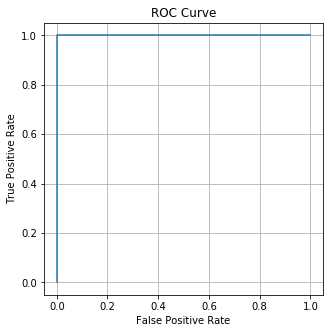

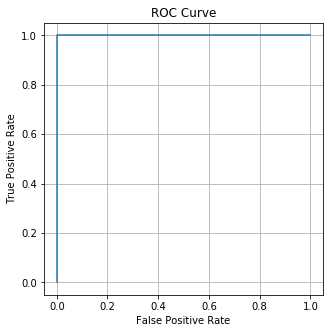

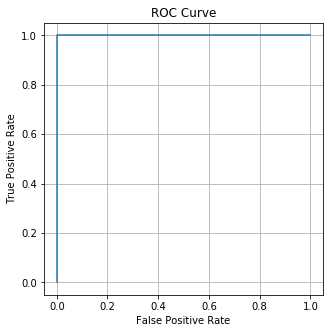

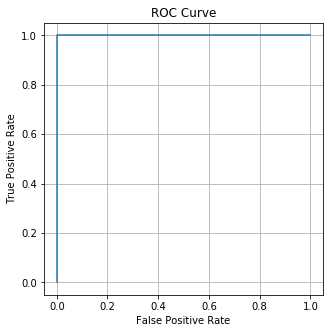

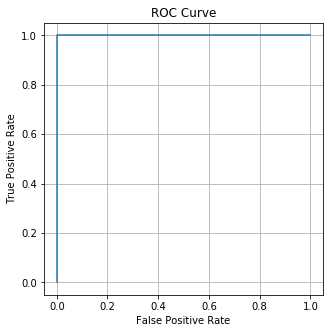

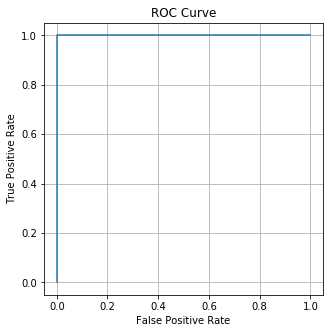

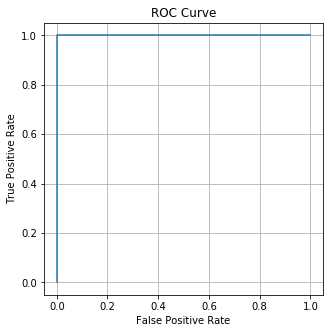

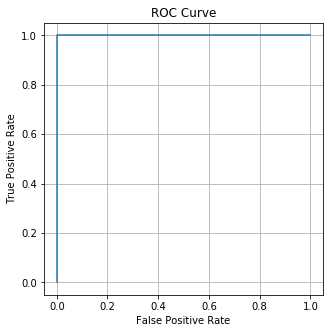

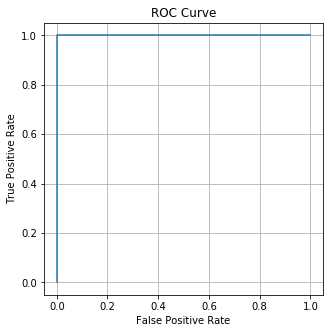

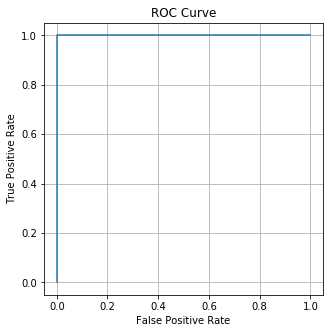

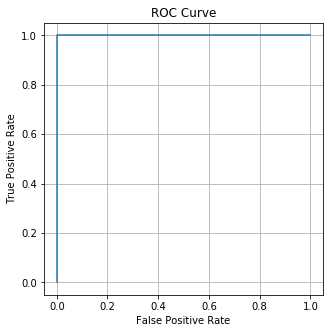

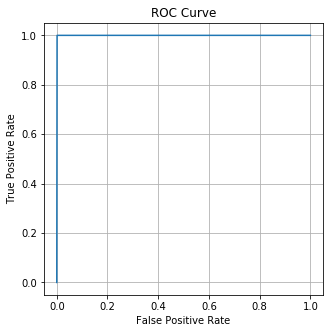

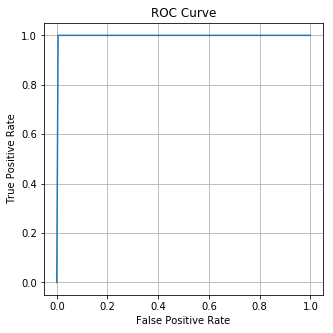

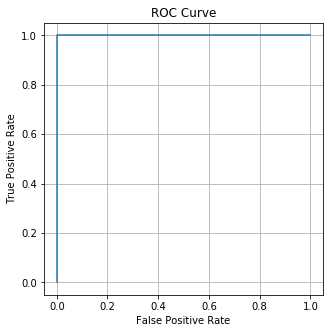

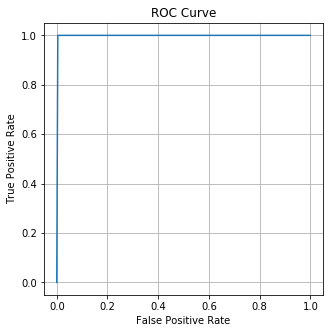

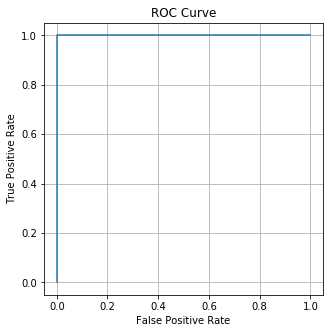

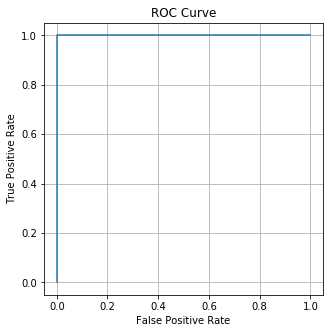

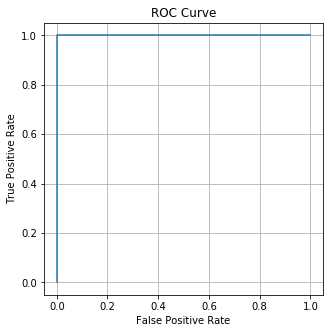

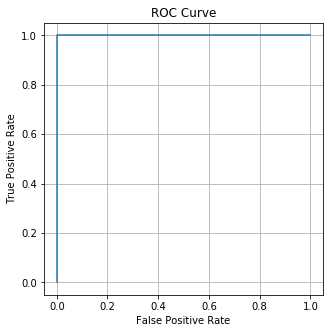

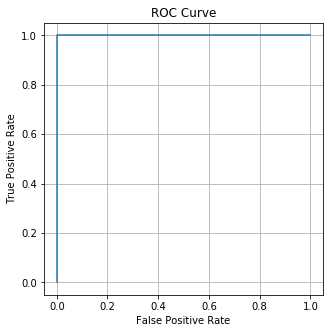

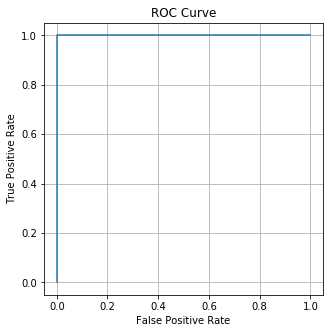

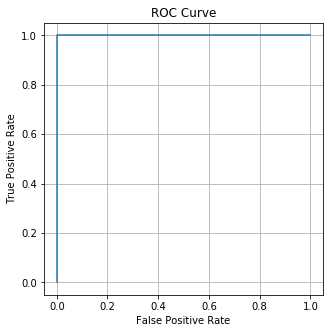

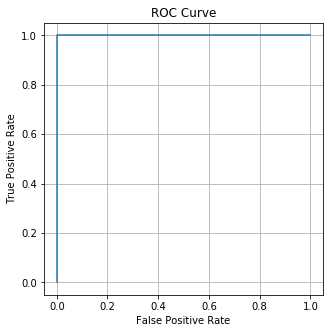

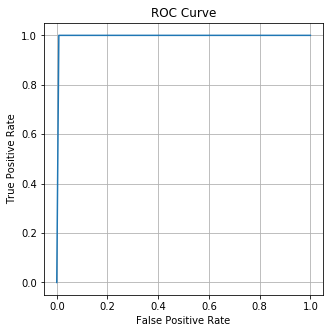

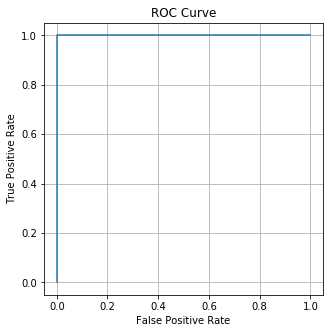

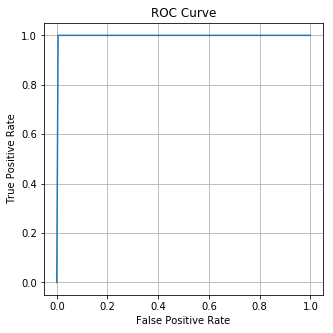

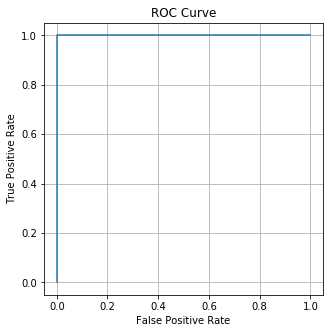

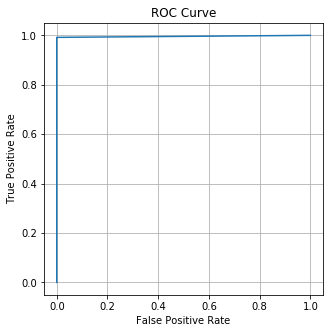

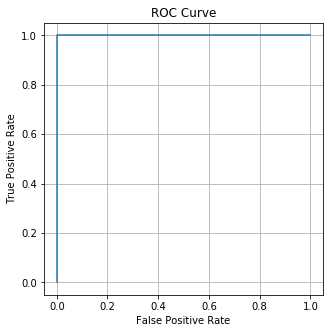

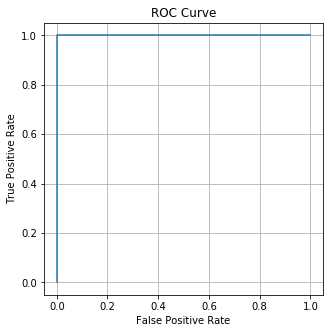

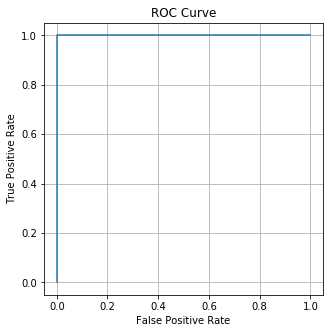

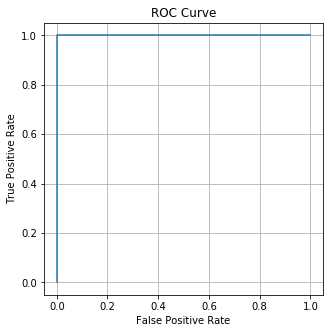

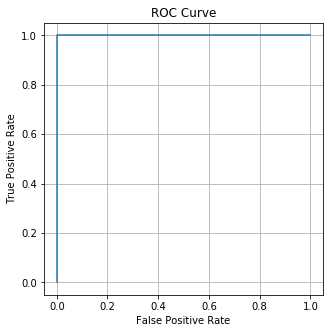

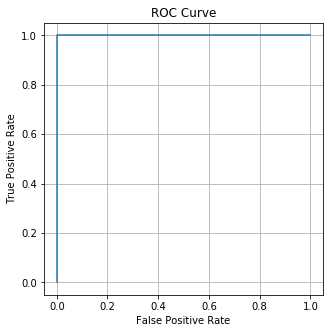

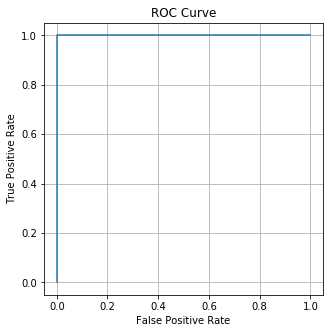

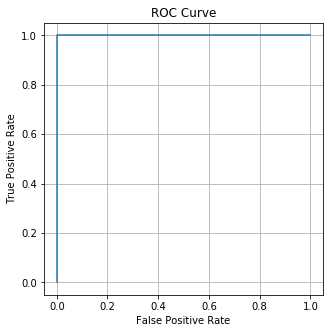

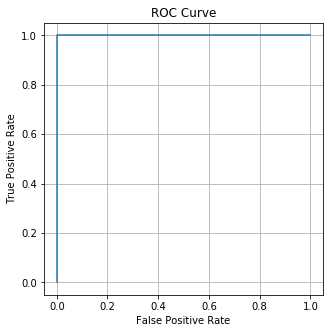

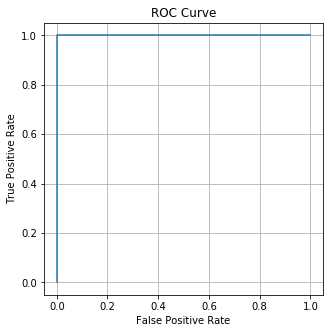

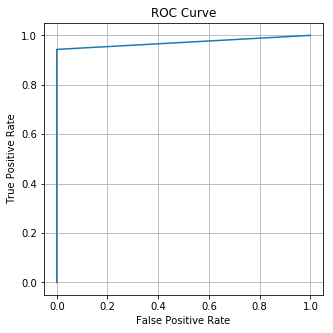

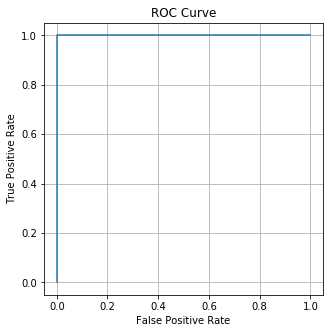

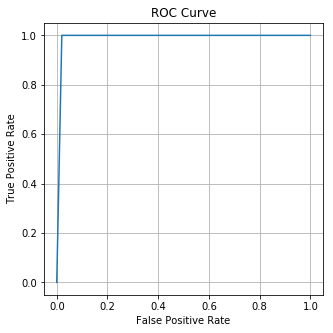

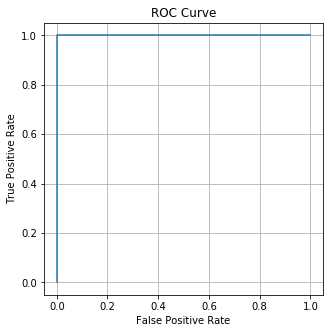

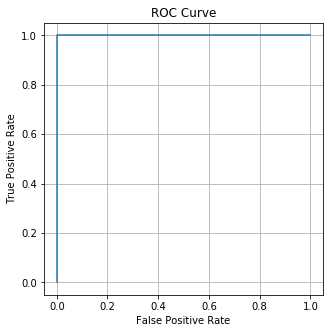

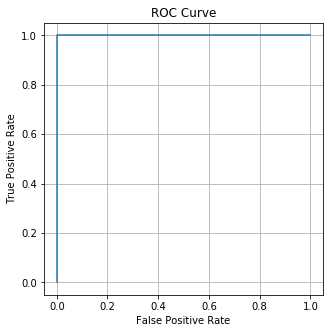

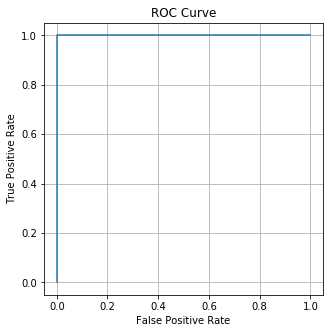

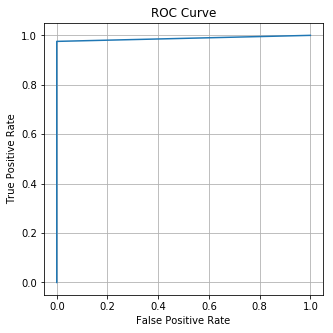

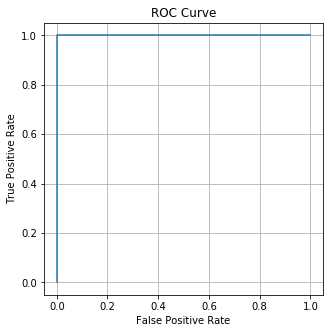

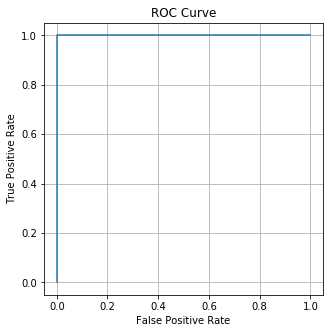

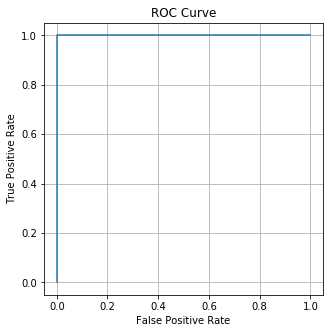

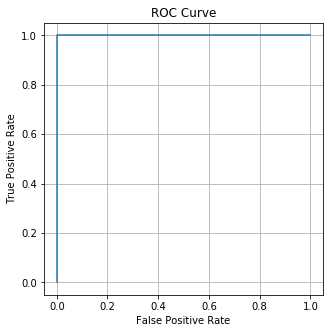

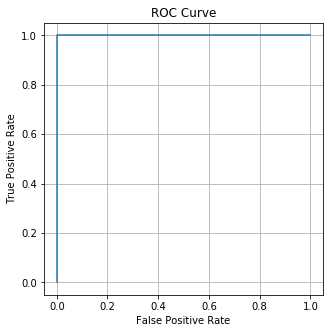

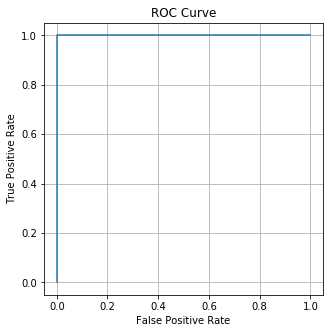

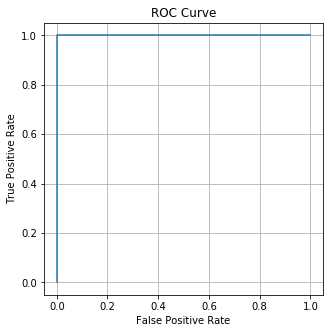

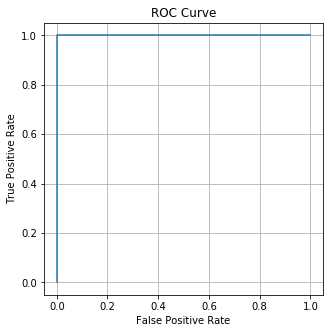

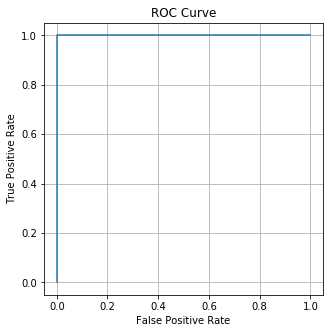

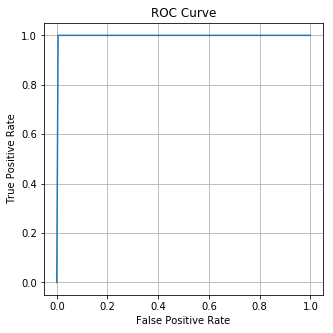

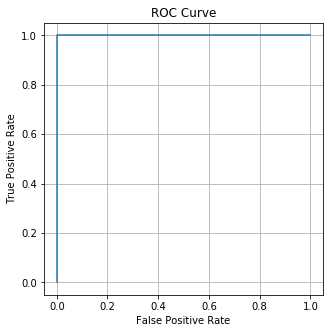

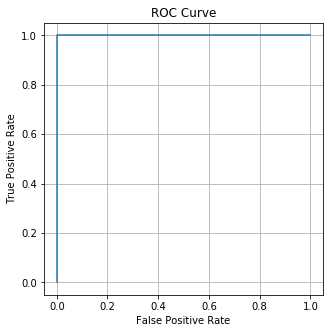

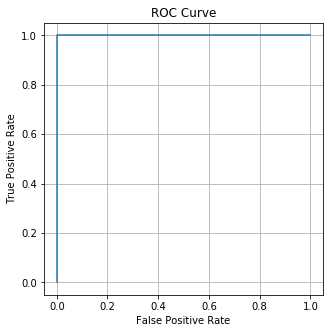

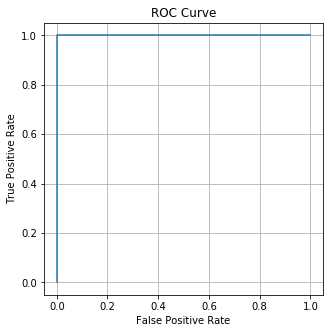

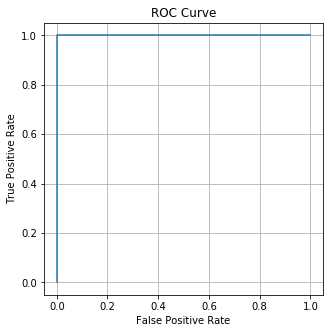

In [100]:
%time de.solve()

[0. 0. 0. 4. 0.]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0


0.0

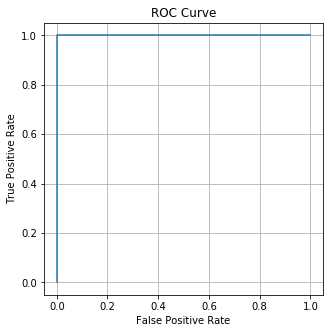

In [101]:
de.fitness(de.X_best)

# yeast-0-2-5-6_vs_3-7-8-9

In [156]:
kddcup, X, y, k = read_data(
    filepath=r'yeast-0-2-5-6_vs_3-7-8-9\yeast-0-2-5-6_vs_3-7-8-9_data.txt',
    atr_num=9)

dict_items([(0, 905), (1, 99)]) Imbalanced Ratio:9


## feature columns

In [157]:
feature_columns = []

for header in ['Atr_' + str(i) for i in [0,1,2,3,4,5,6,7]]:
    feature_columns.append(tf.feature_column.numeric_column(header))

## onehot

In [158]:
X_onehot, columns_num = get_onehot(X, feature_columns)
dataframe_onehot = pd.DataFrame(np.c_[X_onehot.numpy(), y])

In [159]:
postive_frame_onehot = dataframe_onehot[dataframe_onehot[dataframe_onehot.columns[-1]] == 1]
negative_frame_onehot = dataframe_onehot[dataframe_onehot[dataframe_onehot.columns[-1]] == 0]

## smote

In [160]:
all_minority_sample_with_target = my_smote(postive_frame_onehot.to_numpy()[:,0:-1])
k = len(all_minority_sample_with_target)

## kmeans

### merge

In [161]:
new_negative = cluster_under_sample(k, negative_frame_onehot)

In [162]:
data_target_resample = np.r_[np.c_[new_negative, np.zeros(len(new_negative))], all_minority_sample_with_target]

## ada bp

g_mean:0.8234454395250159
 recall:0.797979797979798
 tnr:0.8497237569060774
 fbeta:0.5031847133757962
 precision:0.3674418604651163



0.8234454395250159

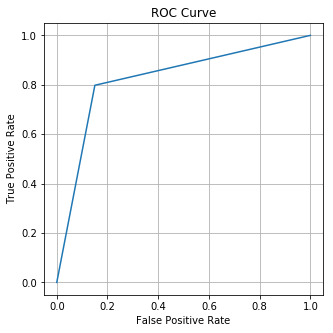

In [165]:
# 随机森林
test_learner(learner_id=5)

g_mean:0.8272117362894141
 recall:0.7878787878787878
 tnr:0.8685082872928177
 fbeta:0.527027027027027
 precision:0.39593908629441626



0.8272117362894141

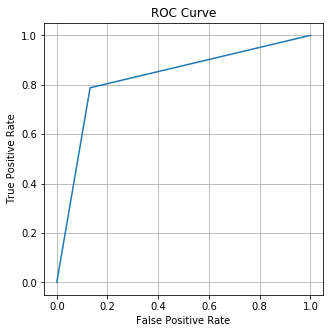

In [166]:
# 梯度提升树
test_learner(learner_id=6)

## bagging + tree

In [163]:
mybagging(data_target_resample, dataframe_onehot.to_numpy())

g_mean:0.9024215427858412
 tnr:0.8143646408839779
 recall:1.0
 AUC:0.9071823358535767
 fbeta:0.5409836065573771
 precision:0.3707865168539326


## de

In [110]:
de = DEalgorithm(5, 5, np.array([0, 0,0,0,0]),
                 np.array([2,2,3,5,2]), 6, 0.8, 0.5)
de.load_data(dataframe_onehot.to_numpy(), negative_frame_onehot, all_minority_sample_with_target)

[0. 0. 1. 0. 1.]
g_mean:0.7715286331177347
 tnr:0.8795580110497238
 recall:0.6767676767676768
 AUC:0.7781628370285034
 fbeta:0.48727272727272725
 precision:0.3806818181818182
[1. 1. 2. 1. 0.]
0.18190187215805054 [1 0 0 0 0 1 0 0]
[1. 1. 2. 1. 0.]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[1. 1. 2. 2. 0.]
0.18340307474136353 [1 1 0 1 0 1 0 0]
[1. 1. 2. 2. 0.]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[1. 1. 2. 2. 1.]
0.19366037845611572 [1 1 0 0 0 1 1 1]
[1. 1. 2. 2. 1.]
g_mean:0.9871092803184501
 tnr:0.994475138121547
 recall:0.9797979797979798
 AUC:0.9871365427970886
 fbeta:0.9651741293532337
 precision:0.9509803921568627
[1. 0. 1. 2. 0.]
g_mean:0.5201664489964077
 tnr:0.8640883977900552
 recall:0.31313131313131315
 AUC:0.5886098742485046
 fbeta:0.2450592885375494
 precision:0.2012987012987013
[1. 1. 0. 0. 1.]
0.23106759786605835 [1 0 0 0 1 0 0 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 0. 1. 0. 1.]
g_mea

g_mean:0.7715286331177347
 tnr:0.8795580110497238
 recall:0.6767676767676768
 AUC:0.7781628370285034
 fbeta:0.48727272727272725
 precision:0.3806818181818182
[1. 1. 2. 2. 0.]
0.18916231393814087 [1 1 0 0 0 1 1 1]
[1. 1. 2. 2. 0.]
g_mean:0.994459791164577
 tnr:0.988950276243094
 recall:1.0
 AUC:0.9944751262664795
 fbeta:0.9519230769230769
 precision:0.908256880733945
[0. 0. 1. 1. 1.]
g_mean:0.8064282169610631
 tnr:0.825414364640884
 recall:0.7878787878787878
 AUC:0.8066465854644775
 fbeta:0.46567164179104475
 precision:0.3305084745762712
[0. 0. 2. 1. 0.]
[0. 0. 2. 1. 0.]
g_mean:0.8893589359342874
 tnr:0.8419889502762431
 recall:0.9393939393939394
 AUC:0.8906914591789246
 fbeta:0.555223880597015
 precision:0.3940677966101695
[0. 0. 0. 0. 1.]
g_mean:0.7715286331177347
 tnr:0.8795580110497238
 recall:0.6767676767676768
 AUC:0.7781628370285034
 fbeta:0.48727272727272725
 precision:0.3806818181818182
[0. 0. 1. 1. 1.]
g_mean:0.8064282169610631
 tnr:0.825414364640884
 recall:0.7878787878787878

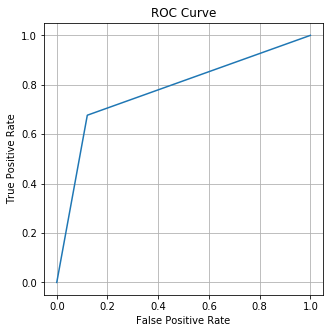

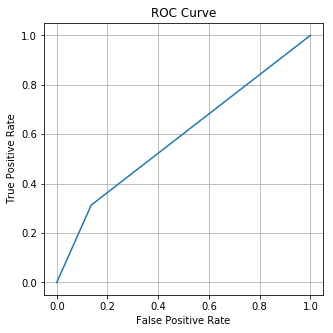

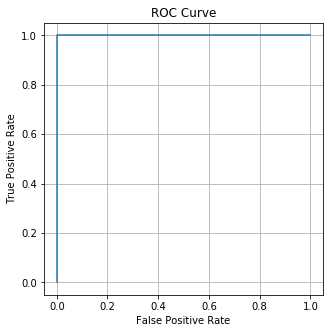

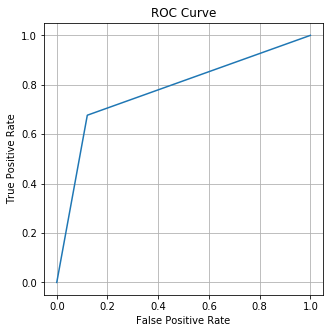

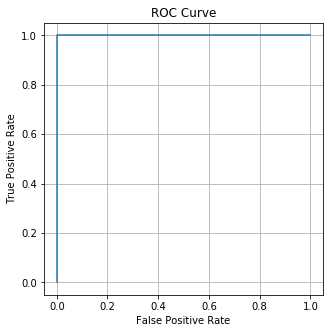

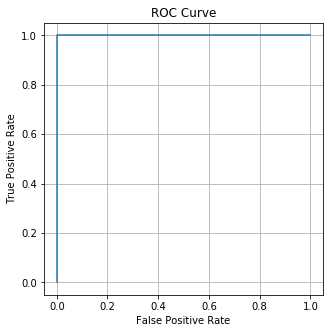

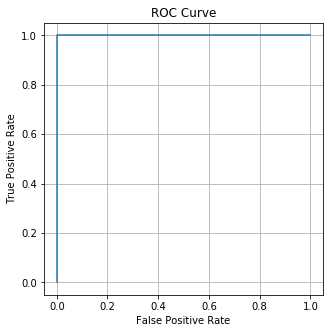

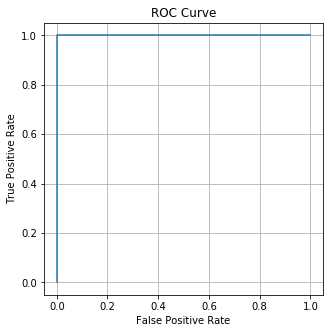

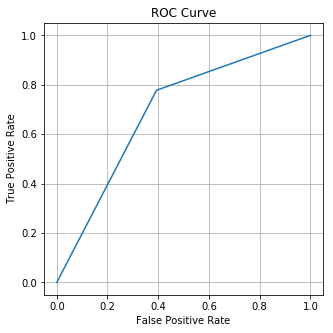

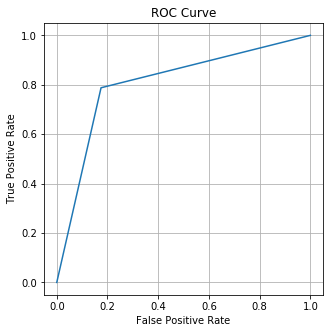

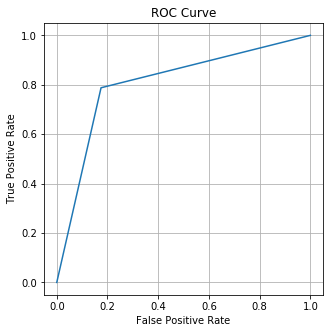

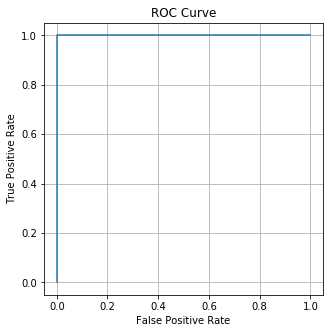

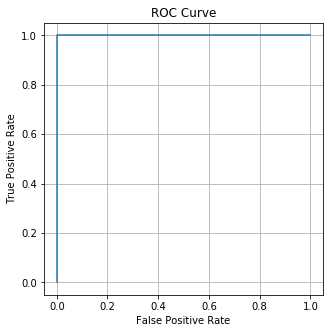

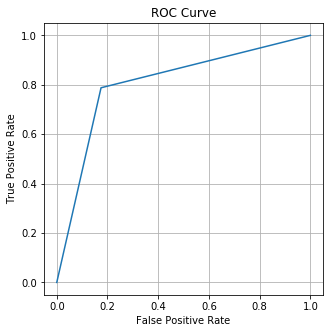

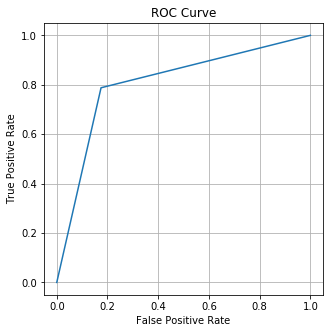

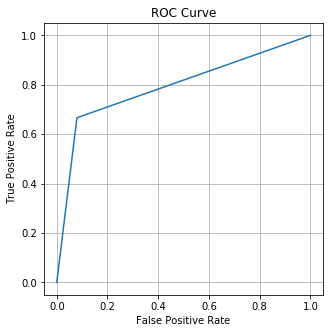

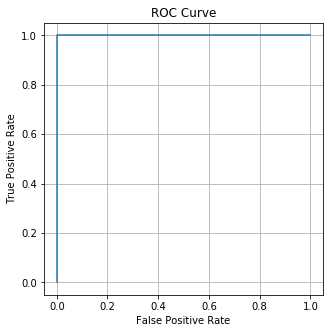

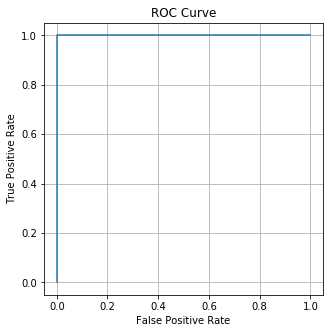

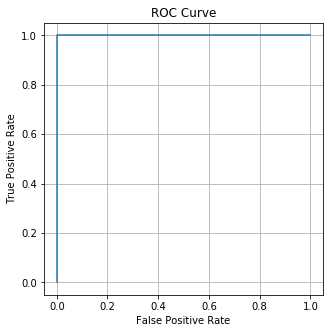

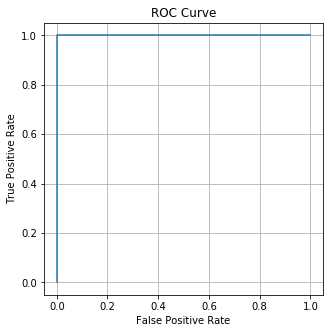

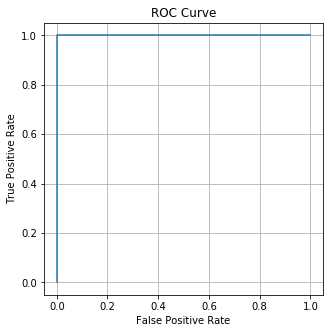

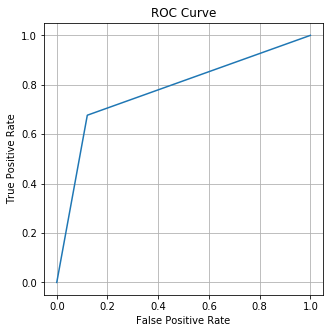

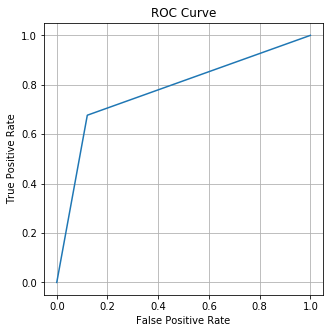

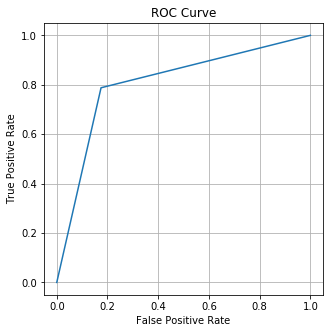

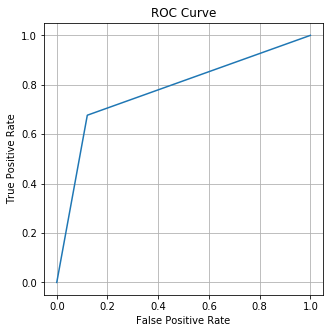

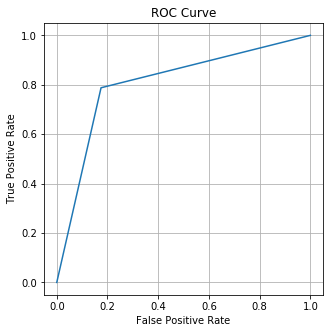

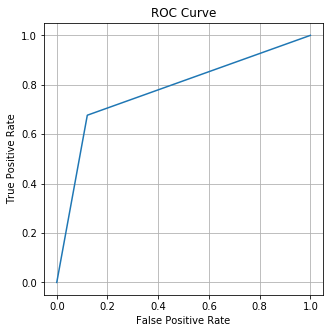

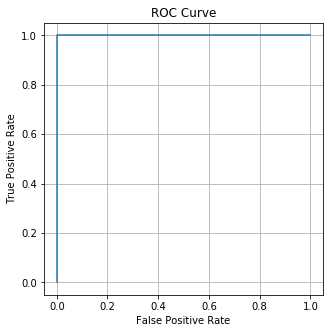

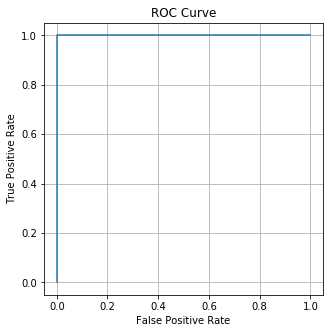

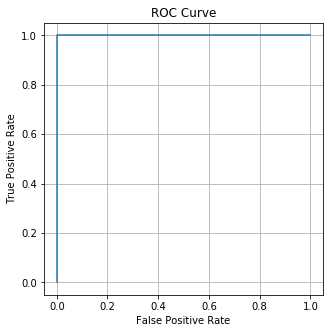

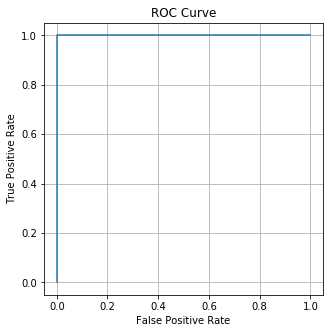

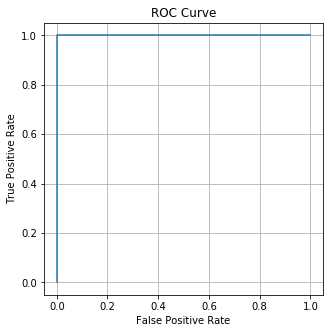

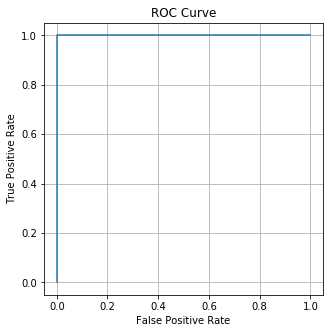

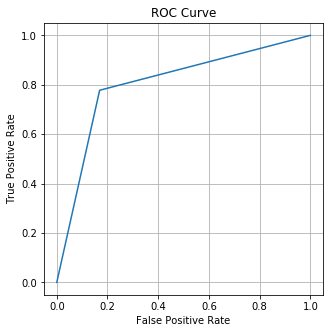

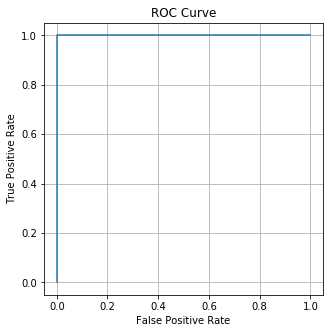

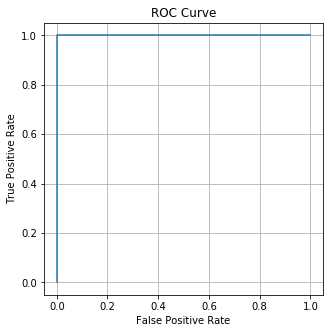

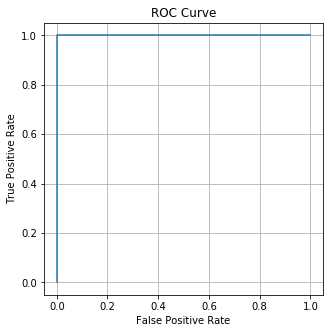

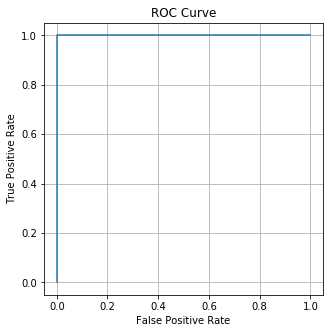

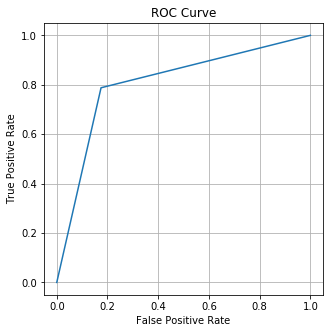

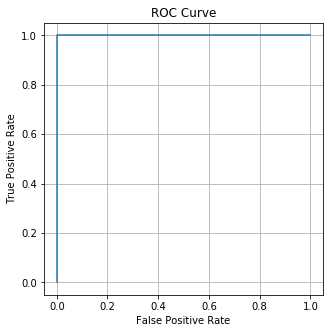

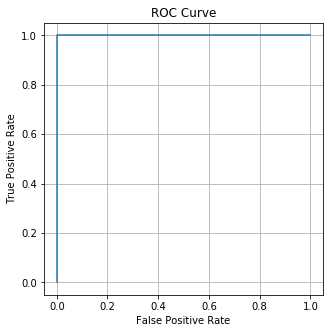

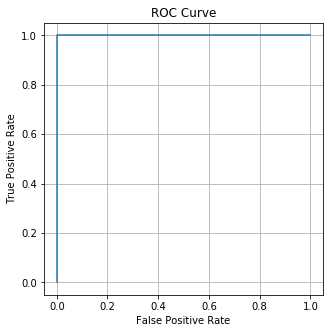

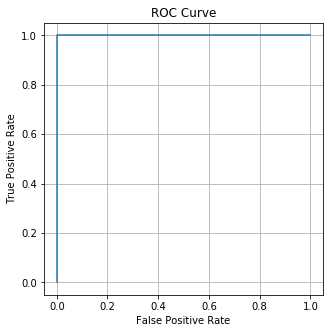

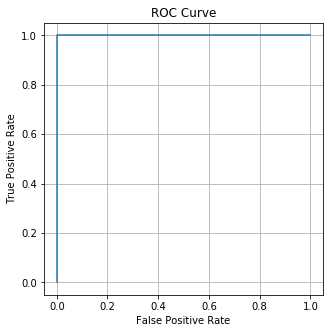

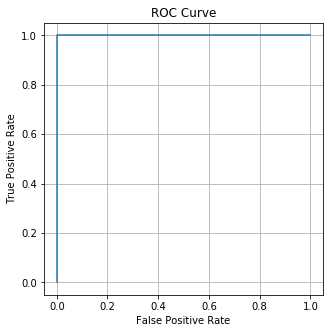

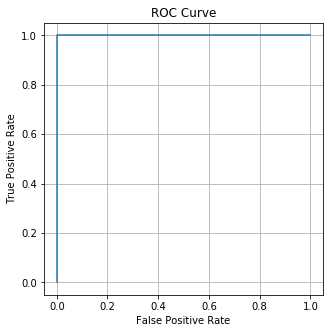

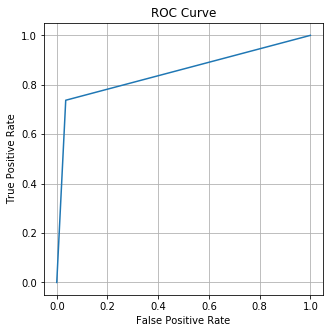

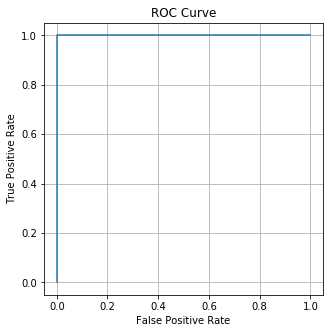

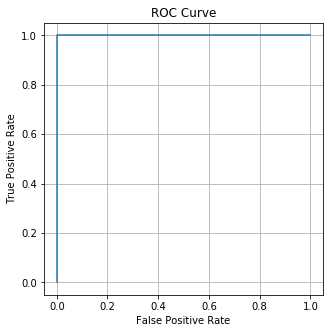

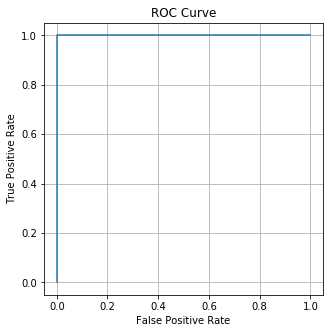

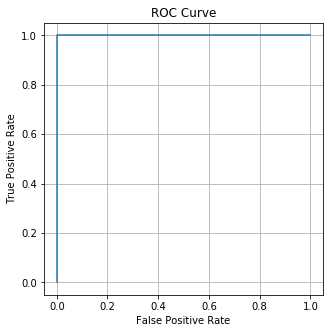

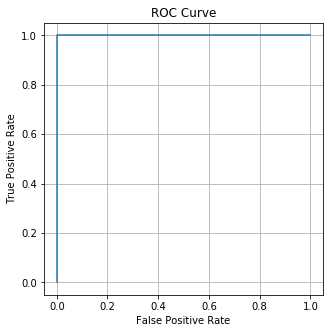

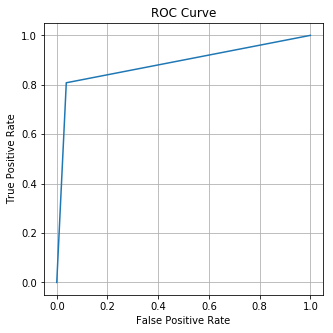

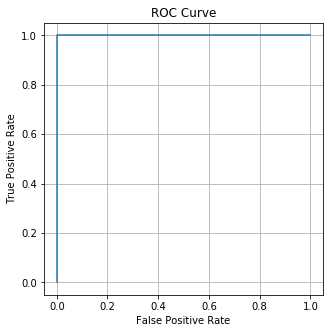

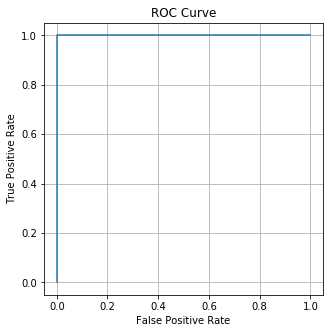

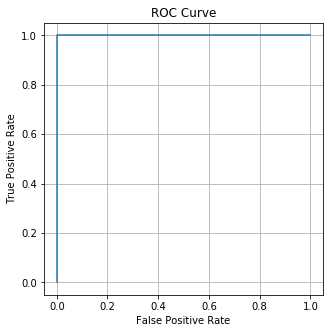

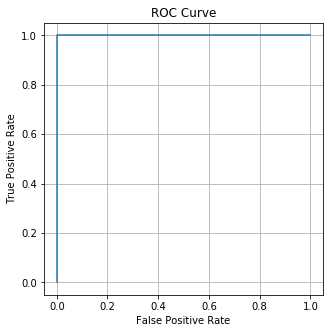

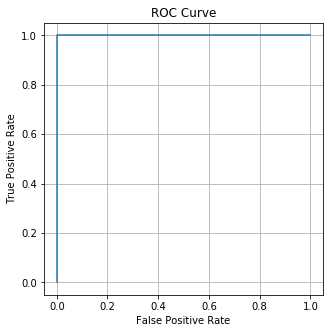

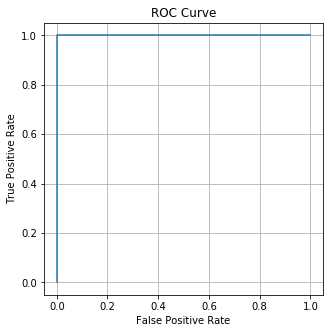

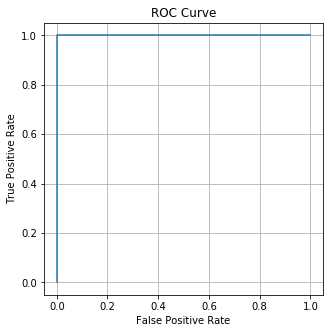

In [111]:
%time de.solve()

In [112]:
de.fitness(de.X_best)

[1. 1. 2. 1. 0.]
0.165885329246521 [1 0 0 1 0 1 1 1]
[1. 1. 2. 1. 0.]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0


0.0

# yeast3

In [167]:
kddcup, X, y, k = read_data(
    filepath=r'yeast3\yeast3_data.txt',
    atr_num=9)

dict_items([(0, 1321), (1, 163)]) Imbalanced Ratio:8


## feature columns

In [168]:
feature_columns = []

for header in ['Atr_' + str(i) for i in [0,1,2,3,4,5,6,7]]:
    feature_columns.append(tf.feature_column.numeric_column(header))

## onehot

In [169]:
X_onehot, columns_num = get_onehot(X, feature_columns)
dataframe_onehot = pd.DataFrame(np.c_[X_onehot.numpy(), y])

In [170]:
postive_frame_onehot = dataframe_onehot[dataframe_onehot[dataframe_onehot.columns[-1]] == 1]
negative_frame_onehot = dataframe_onehot[dataframe_onehot[dataframe_onehot.columns[-1]] == 0]

## smote

In [171]:
all_minority_sample_with_target = my_smote(postive_frame_onehot.to_numpy()[:,0:-1])
k = len(all_minority_sample_with_target)

## kmeans

### merge

In [172]:
new_negative = cluster_under_sample(k, negative_frame_onehot)

In [173]:
data_target_resample = np.r_[np.c_[new_negative, np.zeros(len(new_negative))], all_minority_sample_with_target]

## ada bp

g_mean:0.9379241214031552
 recall:0.9447852760736196
 tnr:0.93111279333838
 fbeta:0.7549019607843138
 precision:0.6285714285714286



0.9379241214031552

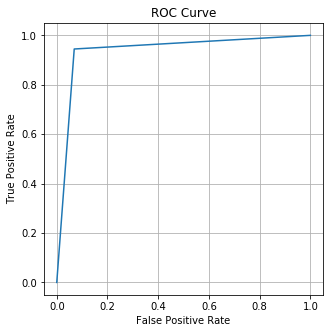

In [176]:
# 随机森林
test_learner(learner_id=5)

g_mean:0.956020788509441
 recall:0.9815950920245399
 tnr:0.93111279333838
 fbeta:0.7729468599033815
 precision:0.6374501992031872



0.956020788509441

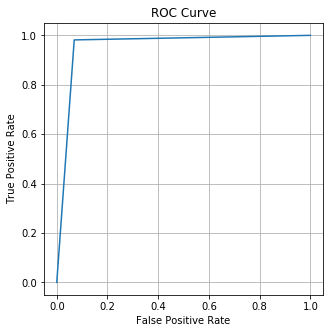

In [177]:
# 梯度提升树
test_learner(learner_id=6)

## bagging + tree

In [174]:
mybagging(data_target_resample, dataframe_onehot.to_numpy())

g_mean:0.9619773619545271
 tnr:0.93111279333838
 recall:0.9938650306748467
 AUC:0.9624888896942139
 fbeta:0.7788461538461539
 precision:0.6403162055335968


## de

In [123]:
de = DEalgorithm(5, 5, np.array([0, 0,0,0,0]),
                 np.array([2,2,3,5,2]), 6, 0.8, 0.5)
de.load_data(dataframe_onehot.to_numpy(), negative_frame_onehot, all_minority_sample_with_target)

[1. 1. 2. 3. 0.]
0.09400296211242676 [0 1 1 0 1 1 1 0]
[1. 1. 2. 3. 0.]
g_mean:0.0
 tnr:0.0
 recall:1.0
 AUC:0.5
 fbeta:0.19793564055859136
 precision:0.10983827493261455
[1. 1. 0. 1. 0.]
0.05860495567321777 [1 1 1 1 0 0 0 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 1. 3. 0.]
0.09778797626495361 [0 1 1 0 0 1 1 1]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 0. 0. 1. 1.]
g_mean:0.9544650172775987
 tnr:0.9280847842543528
 recall:0.9815950920245399
 AUC:0.9548398852348328
 fbeta:0.7655502392344496
 precision:0.6274509803921569
[1. 1. 1. 3. 0.]
0.09237051010131836 [0 1 1 0 1 1 1 1]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 0. 3. 0.]
0.09362447261810303 [0 0 1 0 0 0 0 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[1. 1. 2. 3. 0.]
0.0855969786643982 [0 1 1 1 0 0 1 0]
[1. 1. 2. 3. 0.]
g_mean:0.0
 tnr:0.0
 recall:1.0
 AUC:0.5
 fbeta:0.19793564055859136
 precision:0.109838274932614

g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 1. 0. 0.]
0.09356176853179932 [1 0 1 0 0 0 0 1]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 1. 1. 0.]
0.046256065368652344 [1 1 1 1 1 0 1 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 1. 1. 0.]
0.046256065368652344 [1 1 1 1 0 1 0 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 1. 1. 0.]
0.049363017082214355 [1 0 1 1 0 0 0 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 1. 0. 0.]
0.08670926094055176 [1 0 1 0 0 0 0 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 1. 1. 0.]
0.052391111850738525 [1 1 1 0 0 0 1 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[1. 1. 0. 0. 0.]
0.08595222234725952 [1 0 1 0 0 0 0 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 1. 0. 0.]
0.09356176853179932 [1 0 1 0 0 0 0 1]
g_mean:1.0
 tnr:1.0


0.09051752090454102 [0 1 1 1 0 0 0 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 0. 1. 0.]
0.04549914598464966 [1 1 1 1 1 0 1 1]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 0. 1. 0.]
0.046256065368652344 [1 1 1 1 0 1 1 1]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 1. 1. 0.]
0.04549914598464966 [1 1 1 1 1 0 1 1]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 0. 1. 0.]
0.06828814744949341 [0 1 1 1 1 1 1 1]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 1. 3. 0.]
0.09362447261810303 [0 0 1 0 0 0 0 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 0. 0. 0.]
0.09362447261810303 [0 0 1 0 0 0 0 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 0. 0. 0.]
0.08670926094055176 [1 0 1 0 0 0 0 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 0. 1. 0.]
0.049363017082214355 [1

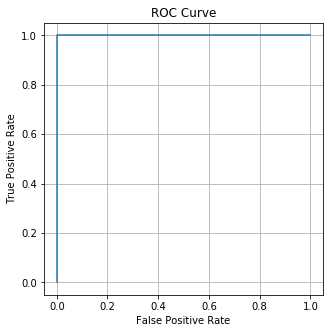

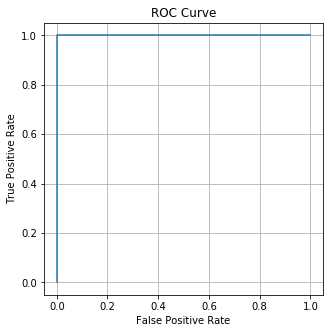

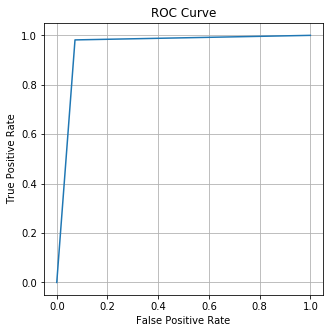

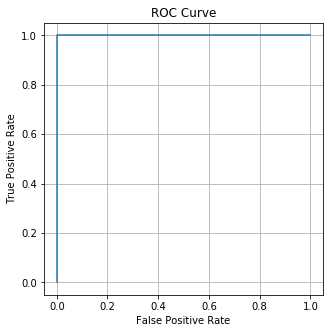

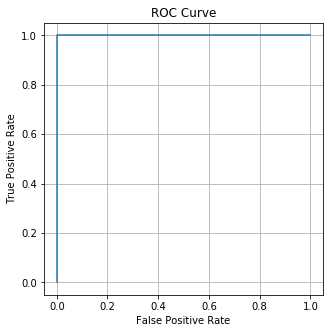

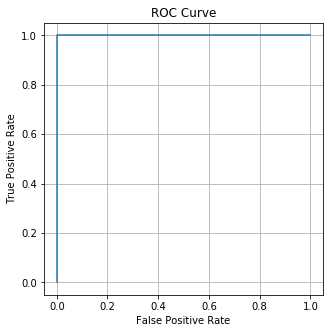

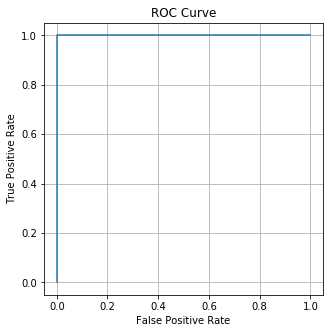

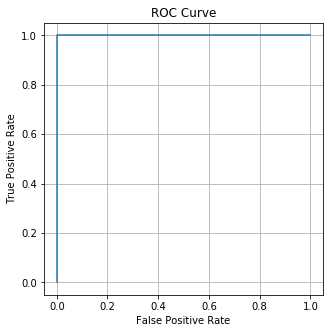

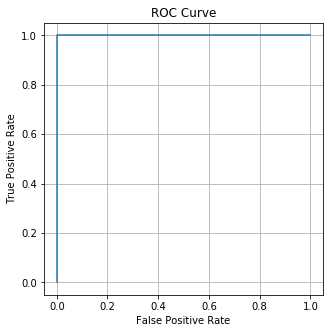

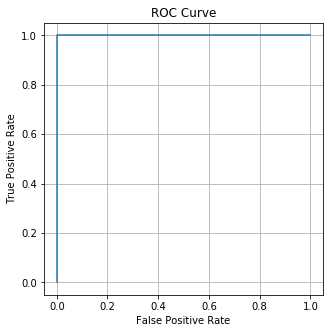

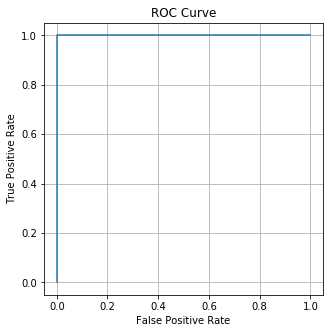

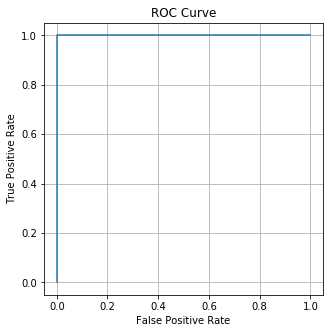

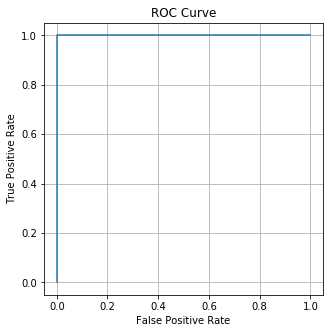

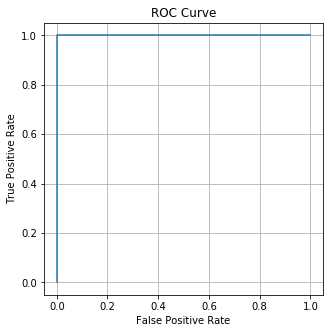

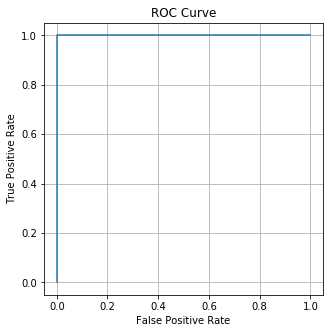

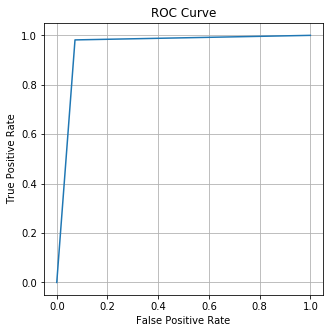

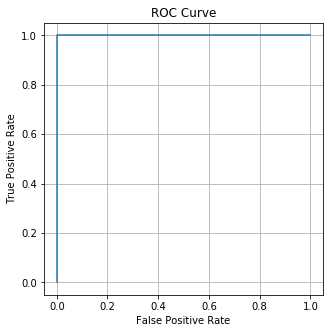

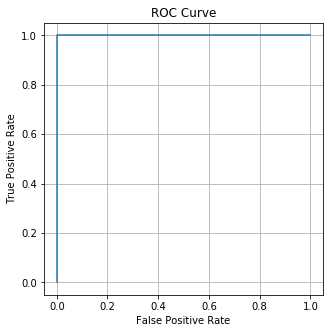

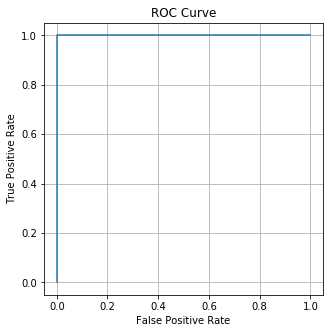

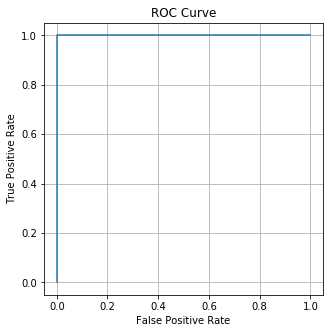

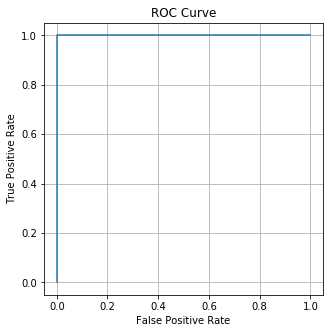

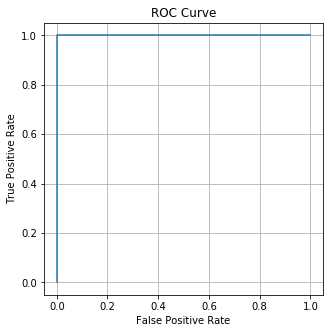

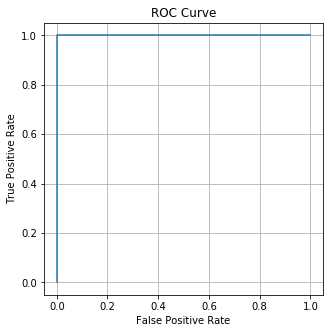

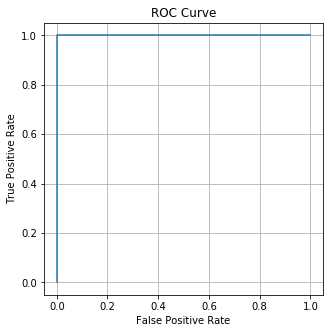

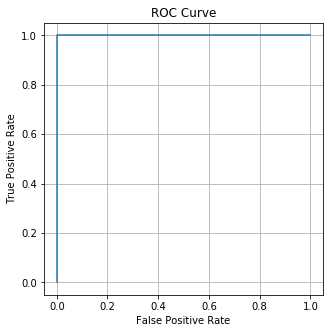

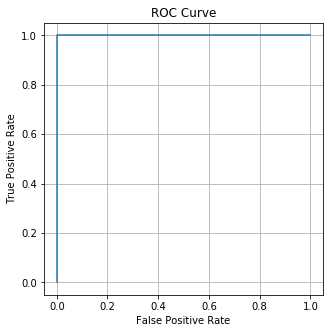

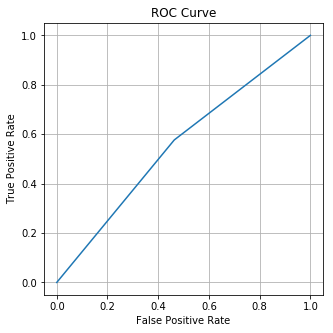

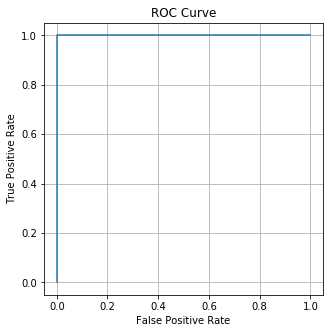

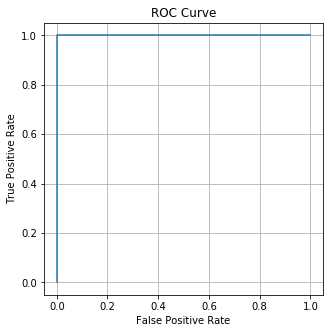

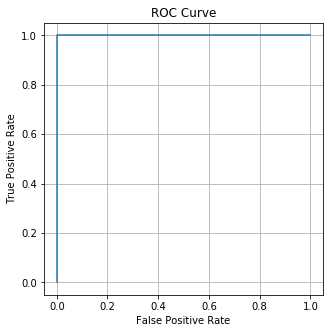

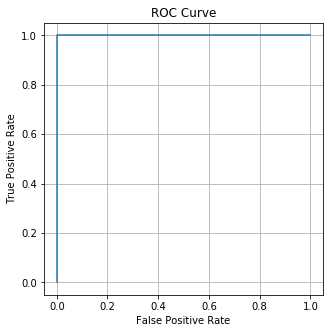

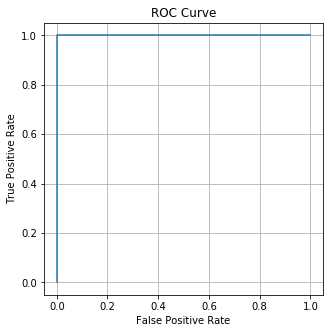

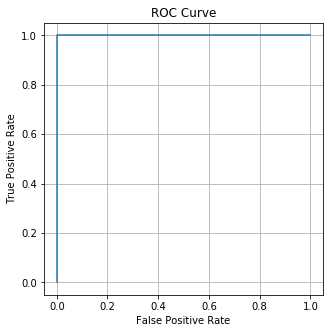

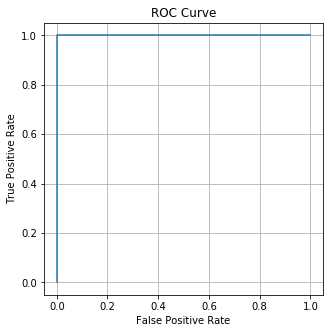

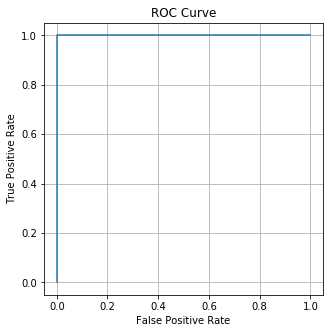

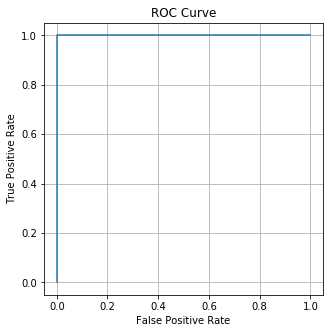

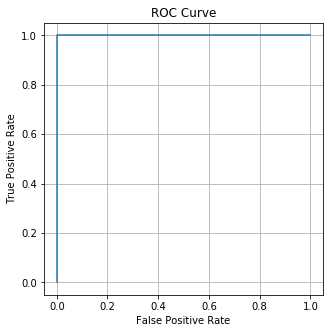

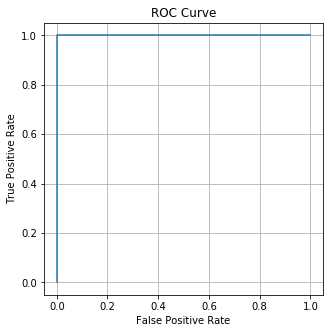

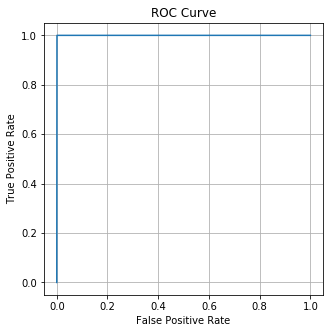

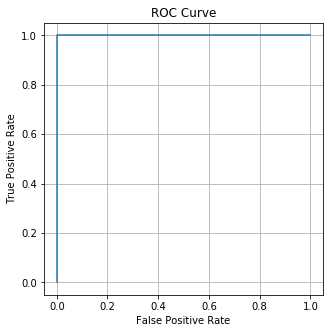

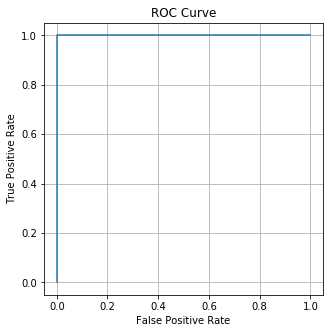

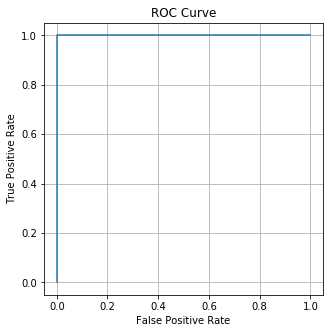

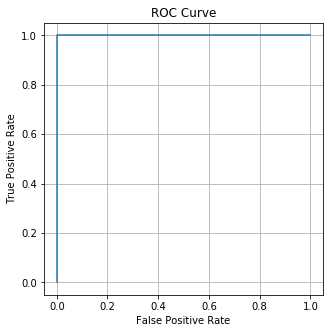

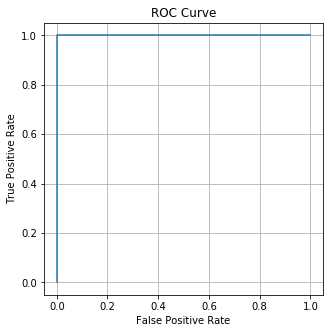

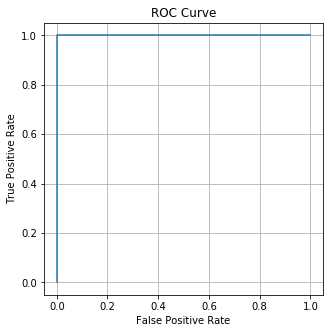

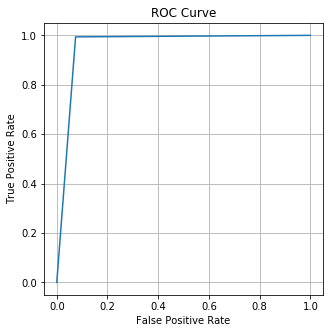

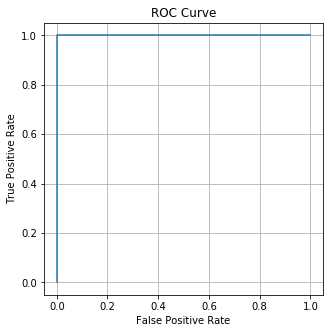

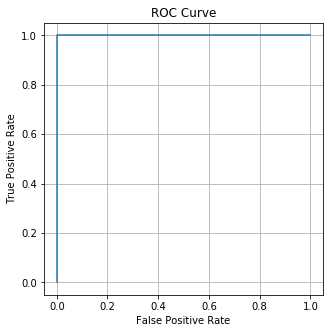

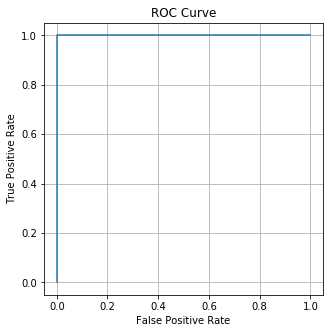

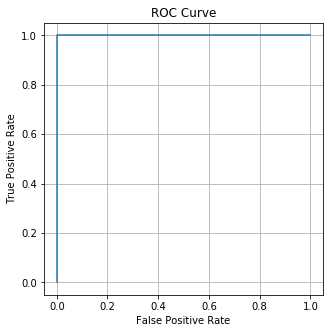

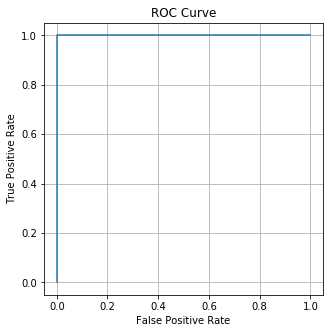

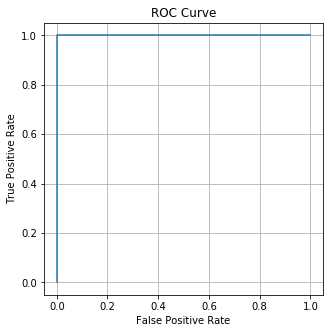

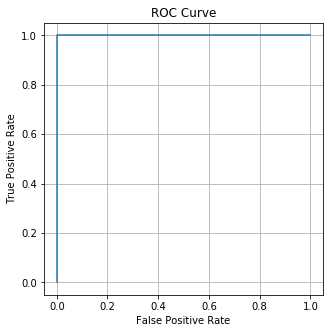

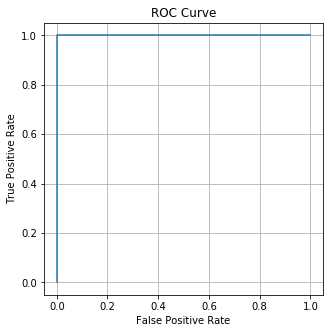

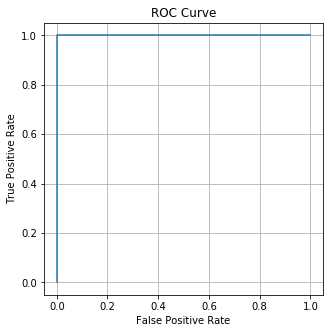

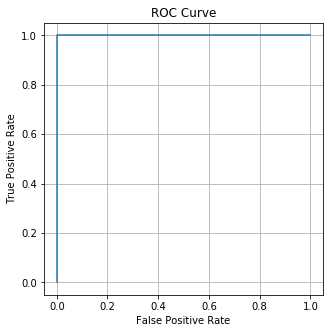

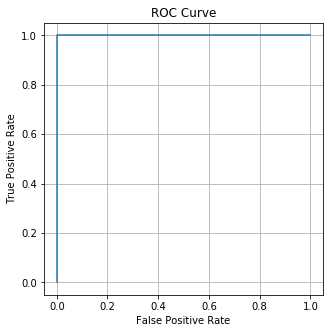

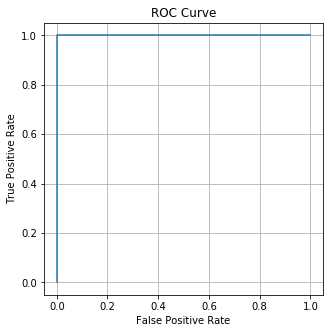

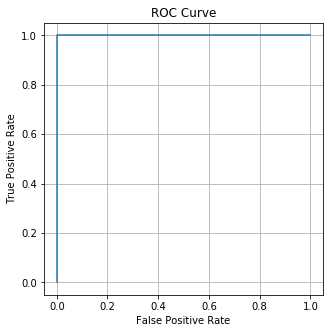

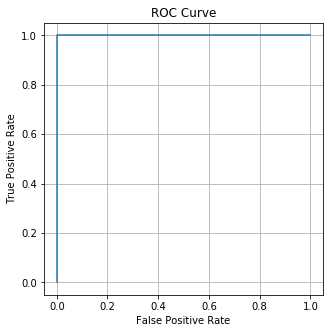

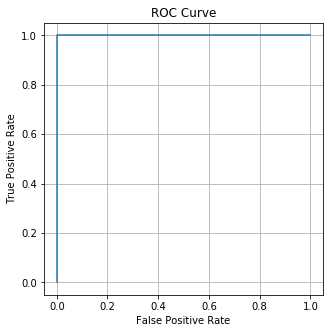

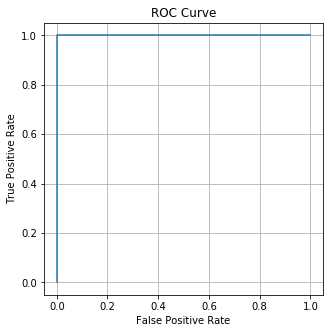

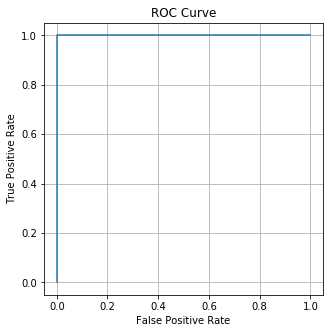

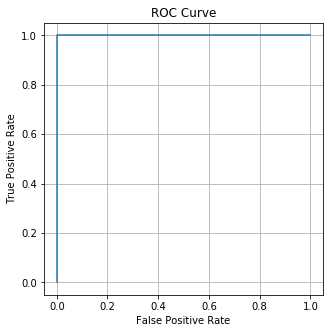

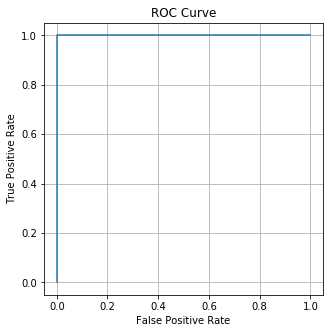

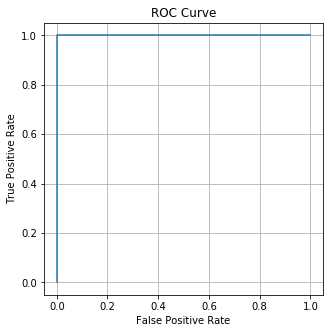

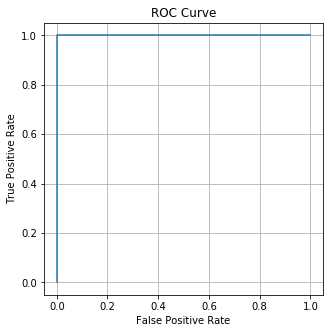

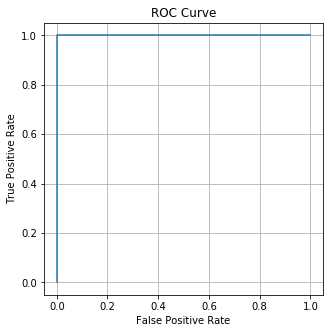

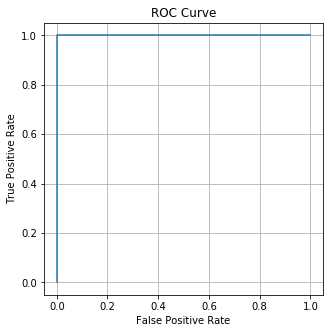

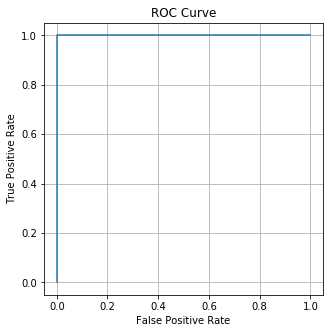

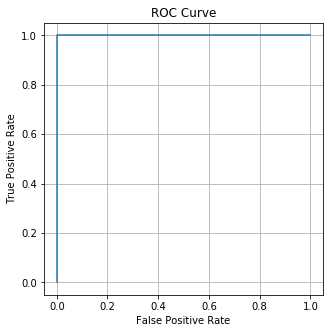

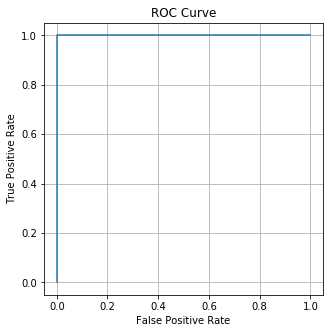

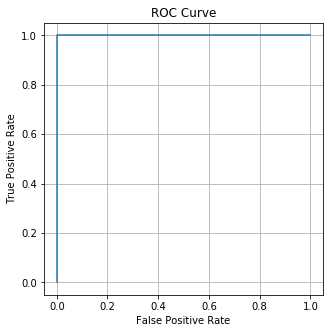

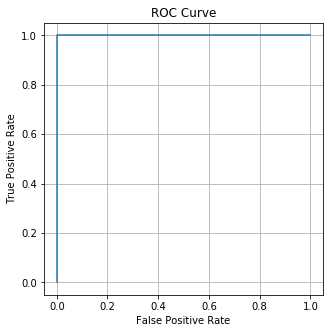

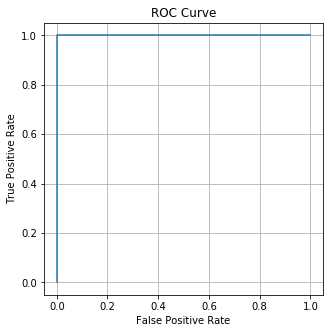

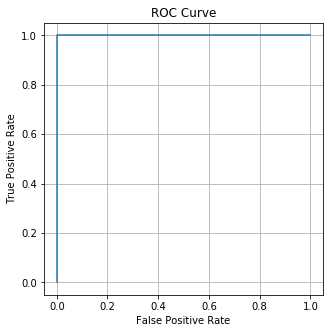

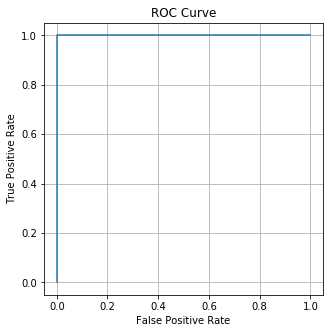

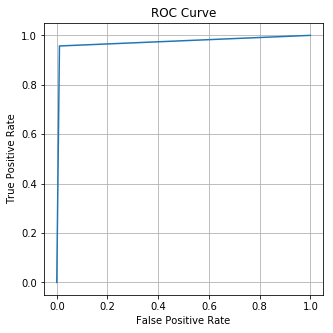

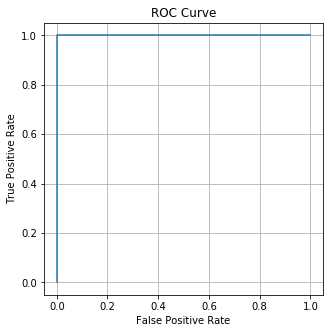

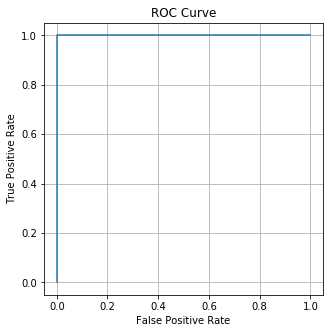

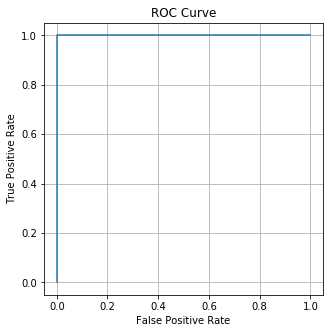

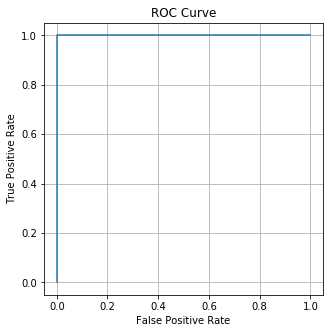

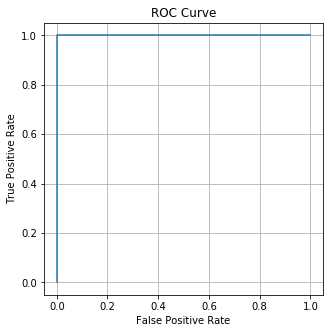

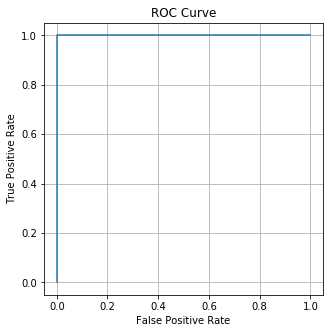

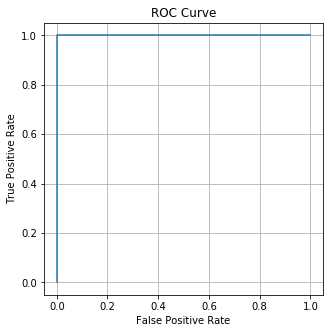

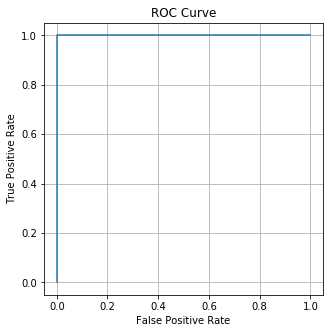

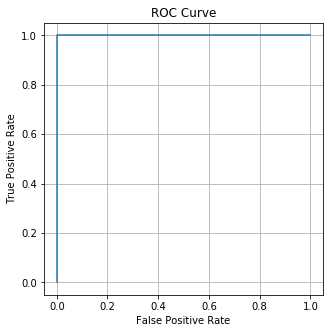

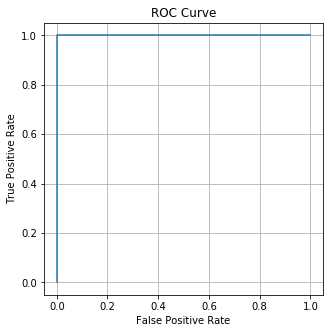

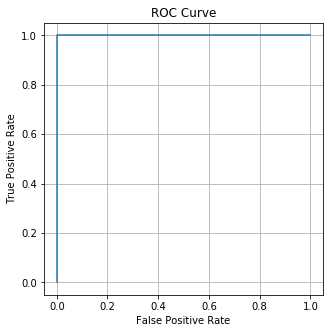

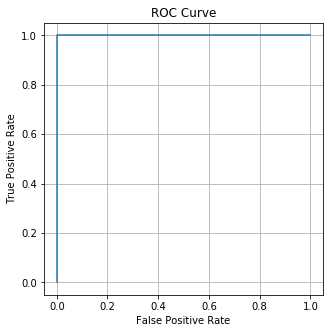

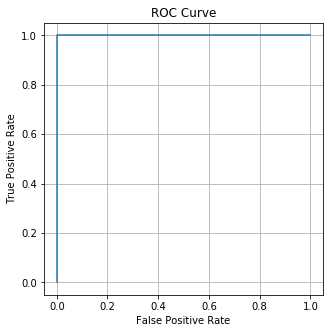

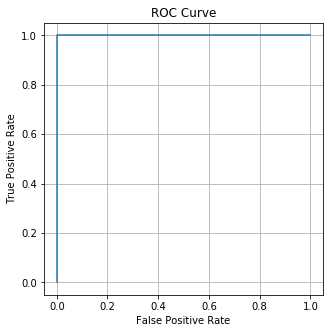

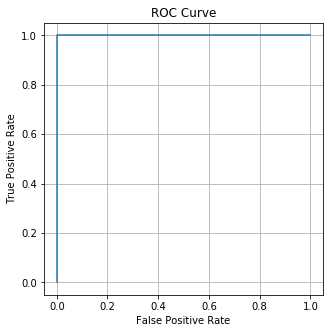

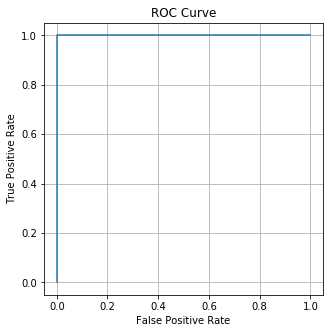

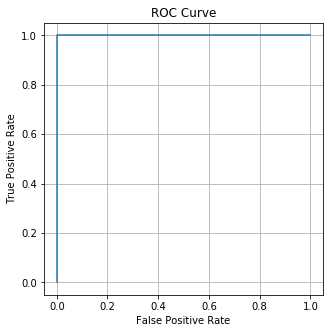

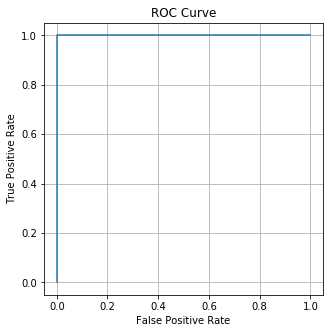

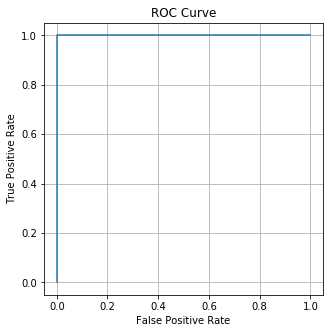

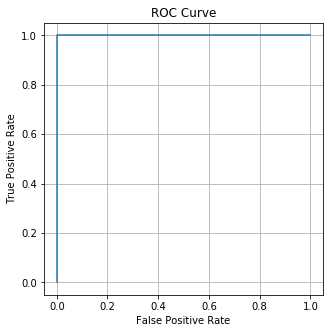

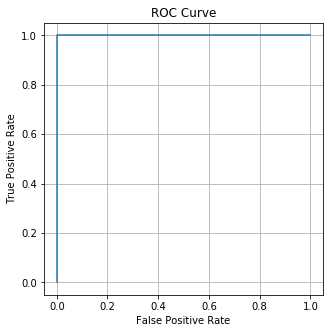

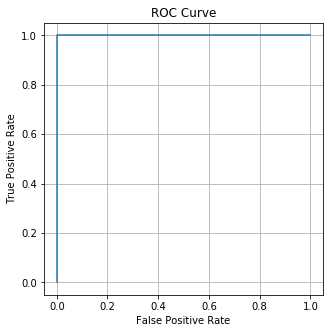

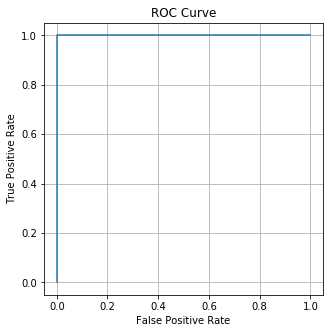

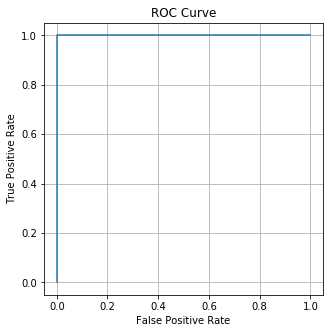

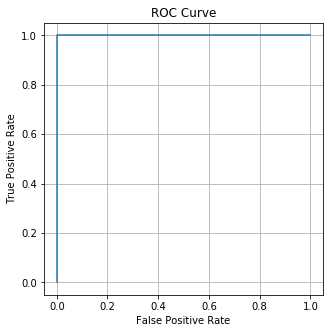

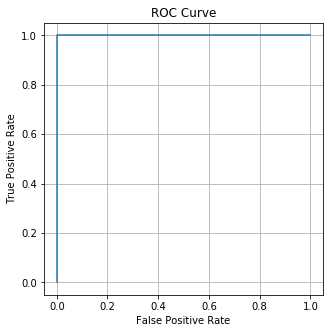

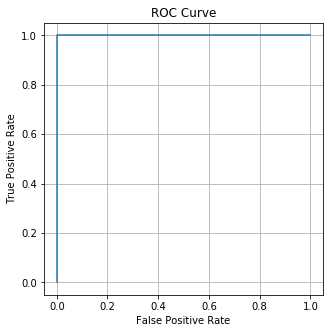

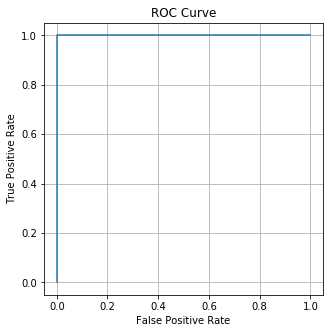

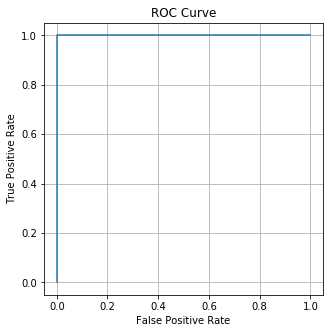

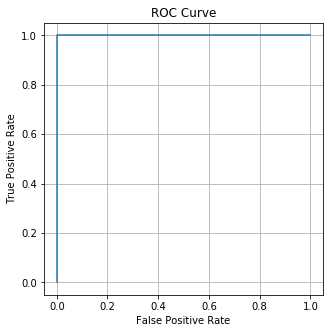

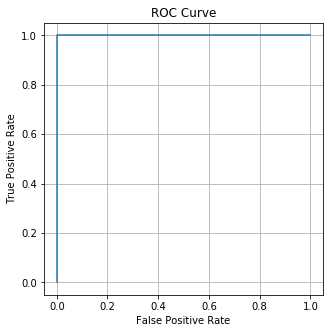

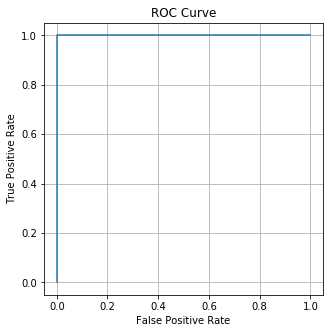

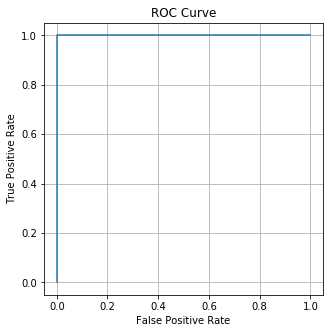

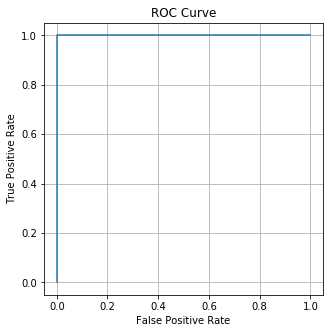

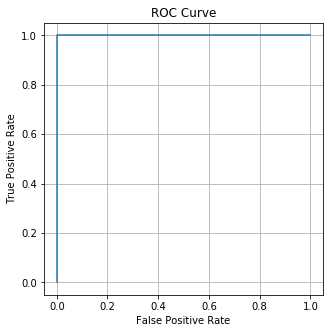

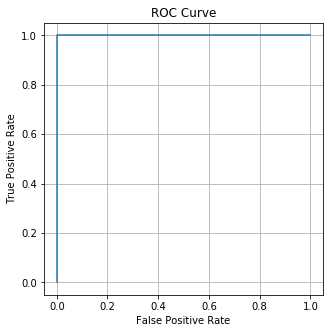

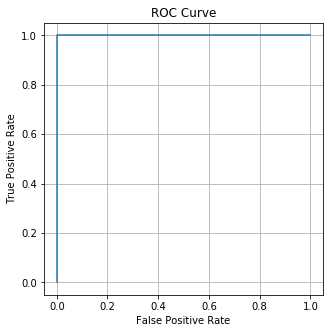

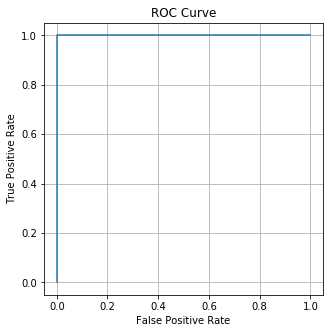

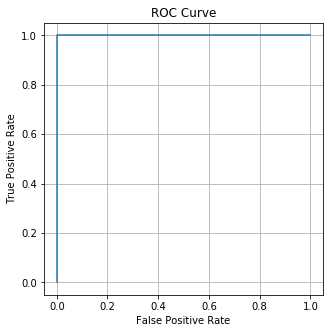

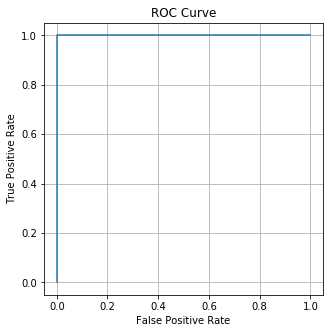

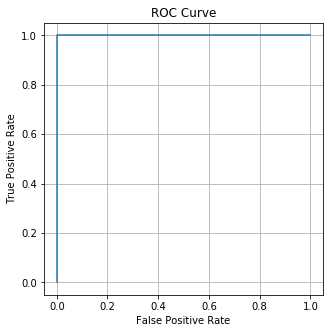

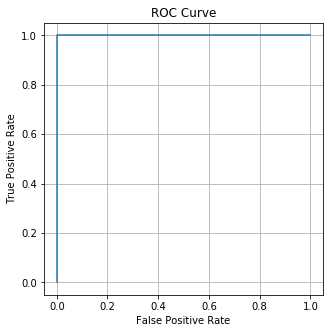

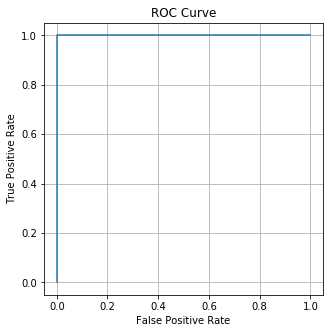

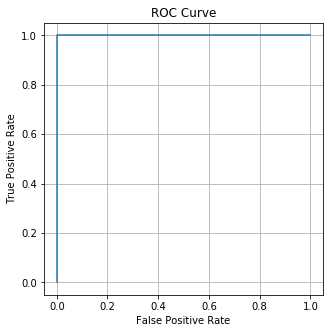

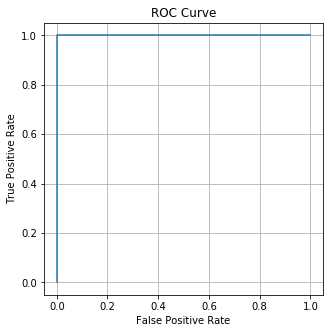

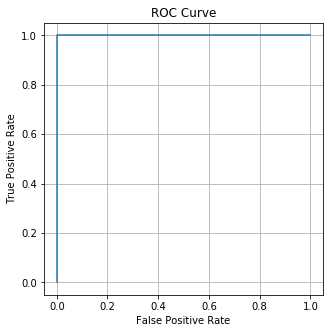

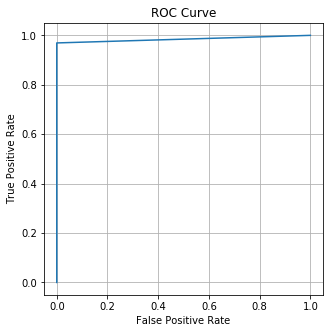

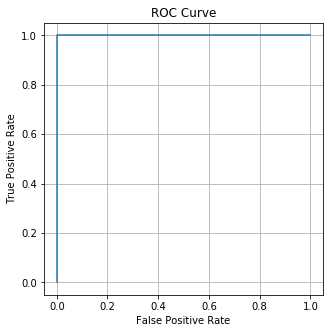

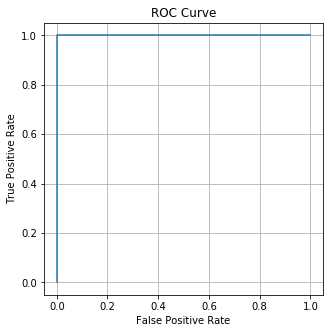

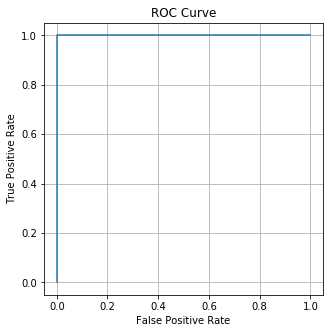

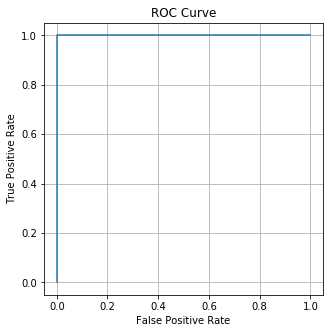

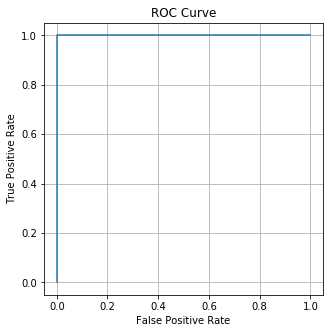

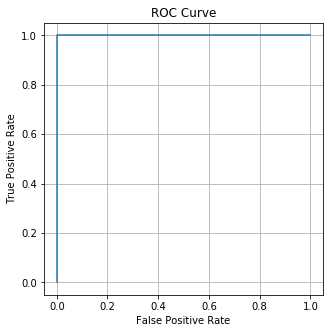

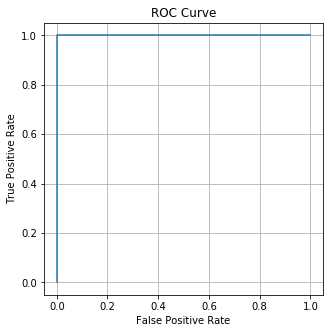

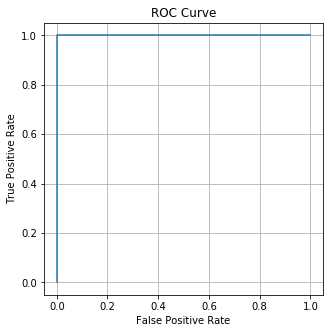

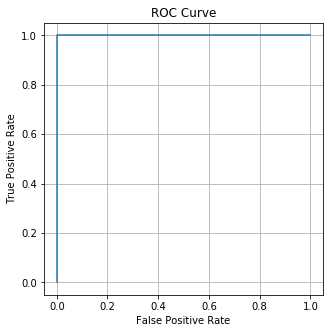

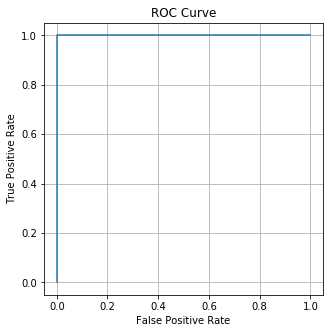

In [124]:
%time de.solve()

[0. 1. 0. 0. 0.]
0.08670926094055176 [1 0 1 0 0 0 0 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0


0.0

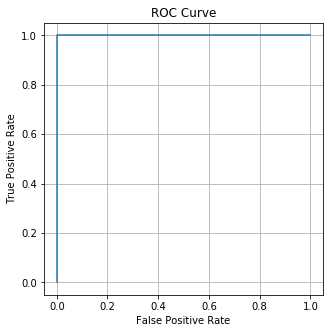

In [125]:
de.fitness(de.X_best)

# yeast6

In [178]:
kddcup, X, y, k = read_data(
    filepath=r'yeast6\yeast6_data.txt',
    atr_num=9)

dict_items([(0, 1449), (1, 35)]) Imbalanced Ratio:41


## feature columns

In [179]:
feature_columns = []

for header in ['Atr_' + str(i) for i in [0,1,2,3,4,5,6,7]]:
    feature_columns.append(tf.feature_column.numeric_column(header))

## onehot

In [180]:
X_onehot, columns_num = get_onehot(X, feature_columns)
dataframe_onehot = pd.DataFrame(np.c_[X_onehot.numpy(), y])

In [181]:
postive_frame_onehot = dataframe_onehot[dataframe_onehot[dataframe_onehot.columns[-1]] == 1]
negative_frame_onehot = dataframe_onehot[dataframe_onehot[dataframe_onehot.columns[-1]] == 0]

## smote

In [182]:
all_minority_sample_with_target = my_smote(postive_frame_onehot.to_numpy()[:,0:-1])
k = len(all_minority_sample_with_target)

## kmeans

### merge

In [183]:
new_negative = cluster_under_sample(k, negative_frame_onehot)

In [184]:
data_target_resample = np.r_[np.c_[new_negative, np.zeros(len(new_negative))], all_minority_sample_with_target]

## ada bp

g_mean:0.7350870375508692
 recall:0.9714285714285714
 tnr:0.5562456866804693
 fbeta:0.09550561797752809
 precision:0.050221565731166914



0.7350870375508692

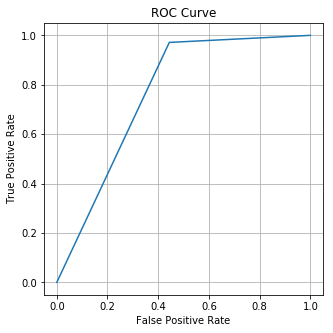

In [186]:
# 随机森林
test_learner(learner_id=5)

g_mean:0.7341610235892573
 recall:1.0
 tnr:0.538992408557626
 fbeta:0.09485094850948508
 precision:0.049786628733997154



0.7341610235892573

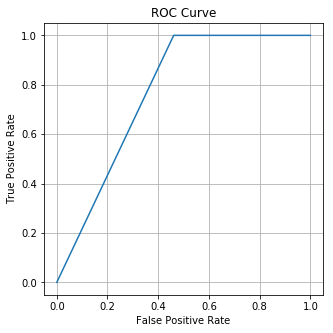

In [187]:
# 梯度提升树
test_learner(learner_id=6)

## bagging + tree

In [188]:
mybagging(data_target_resample, dataframe_onehot.to_numpy())

g_mean:0.6985146421615009
 tnr:0.48792270531400966
 recall:1.0
 AUC:0.7439613342285156
 fbeta:0.08620689655172413
 precision:0.04504504504504504


## de

In [189]:
de = DEalgorithm(5, 5, np.array([0, 0,0,0,0]),
                 np.array([2,2,3,5,2]), 6, 0.8, 0.5)
de.load_data(dataframe_onehot.to_numpy(), negative_frame_onehot, all_minority_sample_with_target)

[1. 0. 1. 1. 1.]
g_mean:0.8601282264334327
 tnr:0.7398205659075224
 recall:1.0
 AUC:0.8699102997779846
 fbeta:0.15659955257270694
 precision:0.08495145631067962
[0. 0. 0. 0. 0.]
g_mean:0.5018942723258683
 tnr:0.25189786059351277
 recall:1.0
 AUC:0.6259489059448242
 fbeta:0.0606585788561525
 precision:0.03127792672028597
[0. 0. 1. 0. 1.]
g_mean:0.6293927753799554
 tnr:0.3961352657004831
 recall:1.0
 AUC:0.6980676651000977
 fbeta:0.07407407407407407
 precision:0.038461538461538464
[1. 1. 1. 0. 0.]
0.1057971715927124 [1 1 1 1 0 0 1 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 1. 2. 0.]
0.11870253086090088 [1 0 0 0 0 0 0 0]
g_mean:0.9818926527398429
 tnr:0.9641131815044859
 recall:1.0
 AUC:0.9820565581321716
 fbeta:0.5737704918032787
 precision:0.40229885057471265
[0. 0. 1. 0. 1.]
g_mean:0.5018942723258683
 tnr:0.25189786059351277
 recall:1.0
 AUC:0.6259489059448242
 fbeta:0.0606585788561525
 precision:0.03127792672028597
[1. 0. 1. 1. 1.]
g_mean:0.8748459393

0.2951000928878784 [0 0 1 0 0 0 1 1]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 1. 2. 0.]
0.11428570747375488 [1 1 1 0 0 0 1 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 1. 2. 0.]
0.10303664207458496 [1 1 0 0 0 1 0 0]
g_mean:0.9710083124552245
 tnr:1.0
 recall:0.9428571428571428
 AUC:0.9714285731315613
 fbeta:0.9705882352941176
 precision:1.0
[0. 0. 1. 2. 1.]
g_mean:0.757206008017851
 tnr:0.6473429951690821
 recall:0.8857142857142857
 AUC:0.7665287256240845
 fbeta:0.10745233968804159
 precision:0.05719557195571956
[1. 1. 1. 0. 0.]
0.12084197998046875 [0 1 0 0 1 0 1 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 1. 0. 1.]
0.11683917045593262 [0 1 1 1 0 0 0 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 1. 0. 1.]
0.11821949481964111 [1 0 1 0 0 0 1 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 1. 2. 0.]
0.10924774408340454 [1 0 0 1 1 1 0

0.11890959739685059 [1 1 0 0 0 0 1 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 1. 1. 1.]
0.07239478826522827 [1 1 1 1 0 0 1 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 1. 1. 1.]
0.07895100116729736 [1 1 0 1 0 0 1 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[1. 1. 1. 0. 0.]
0.11200827360153198 [1 1 0 1 0 0 0 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 1. 1. 1.]
0.07895100116729736 [1 1 0 1 0 0 1 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[1. 1. 1. 0. 0.]
0.11545896530151367 [0 1 1 1 0 1 0 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 1. 0. 0.]
0.11842656135559082 [0 1 0 0 0 0 1 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 1. 0. 0.]
0.11842656135559082 [0 1 0 0 0 0 1 0]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0
[0. 1. 1. 1. 1.]
0.07294678688049316 [1 1

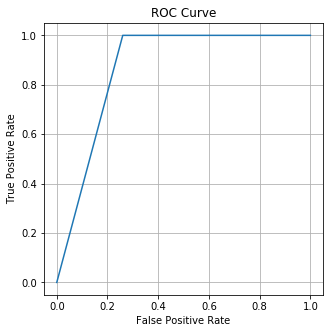

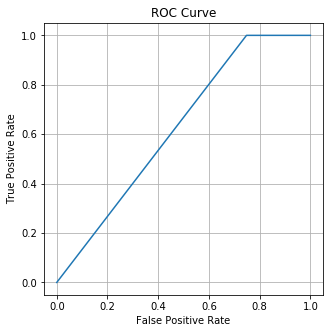

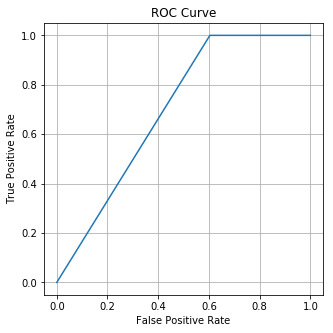

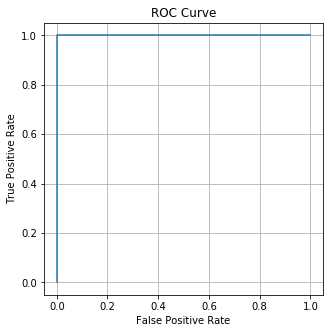

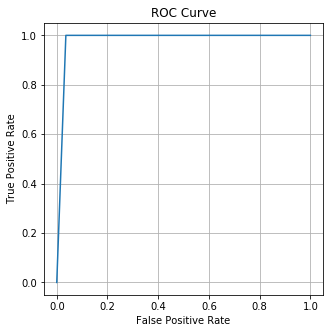

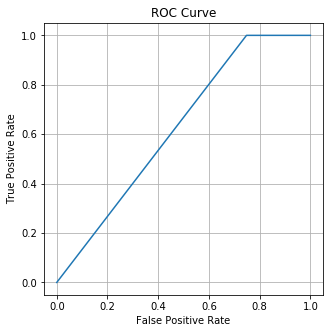

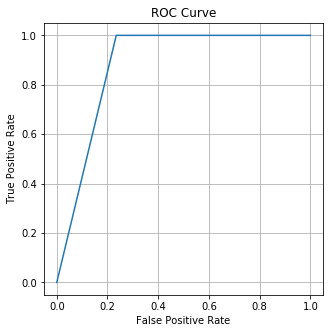

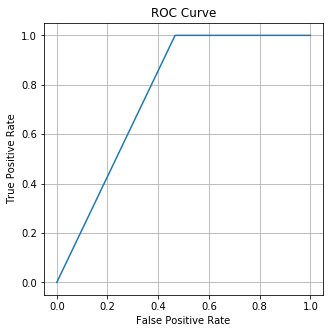

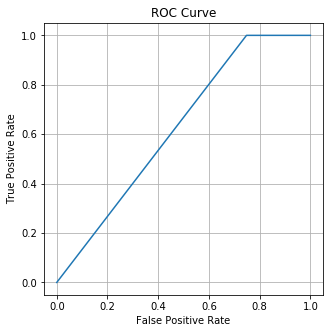

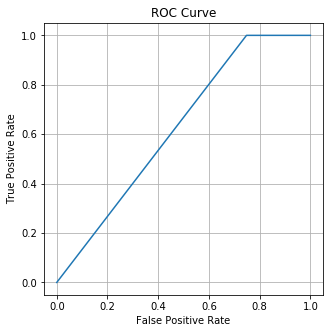

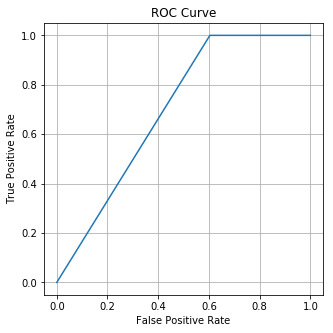

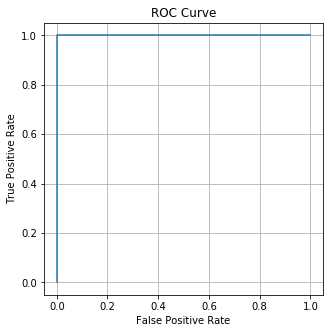

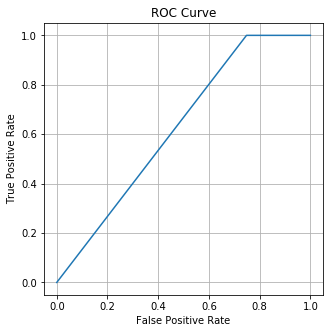

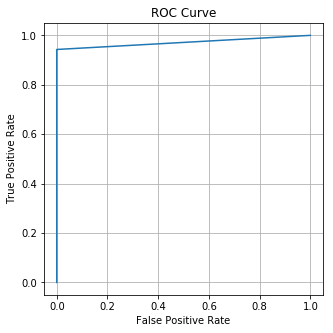

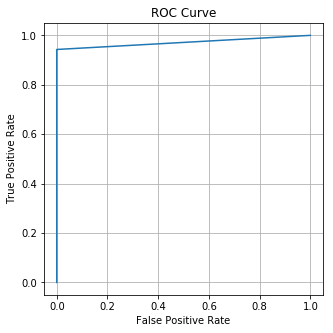

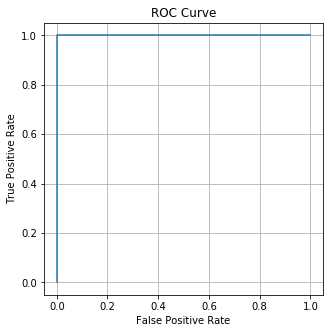

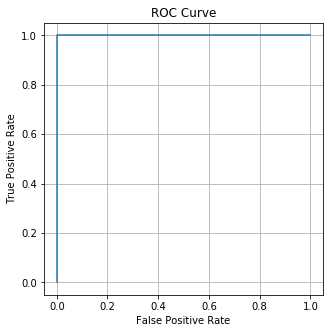

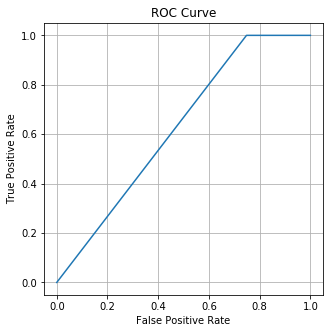

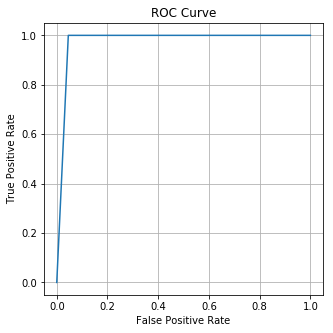

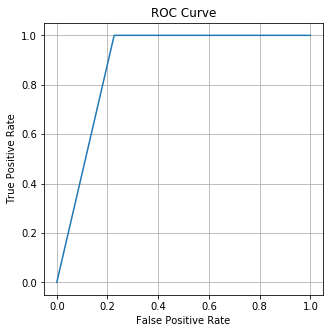

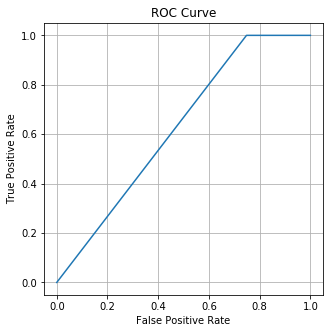

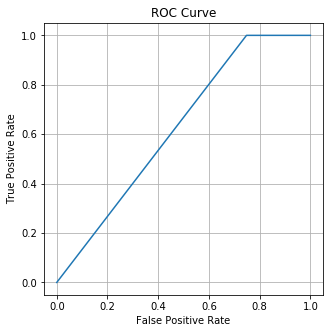

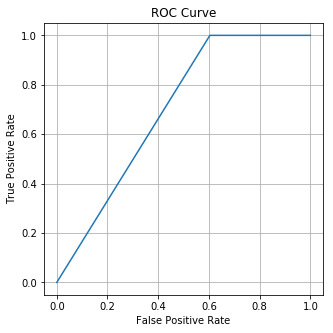

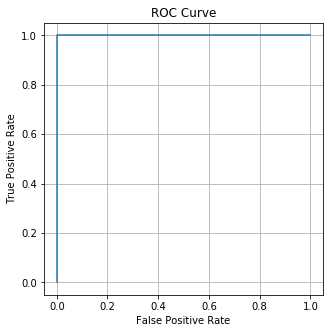

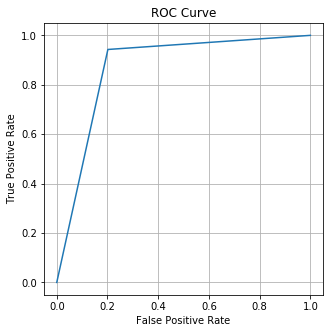

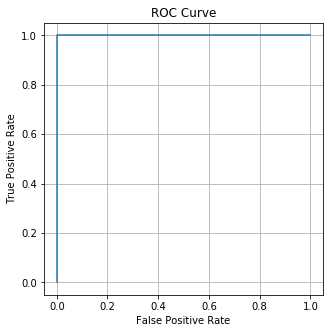

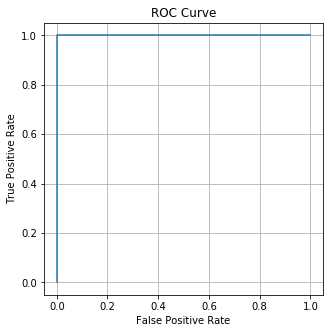

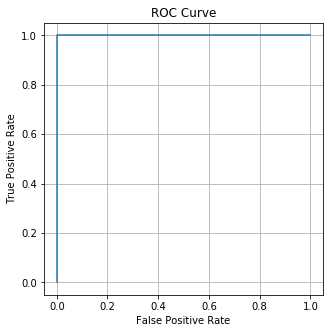

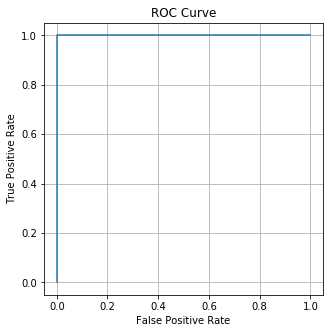

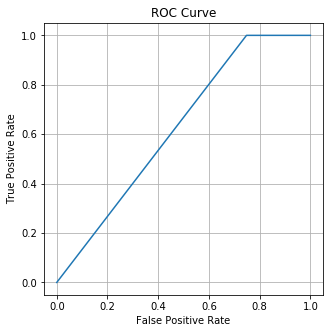

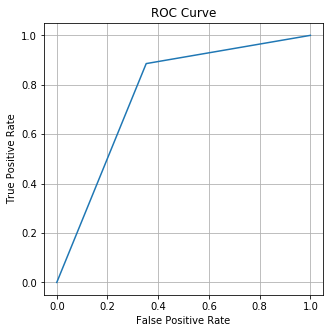

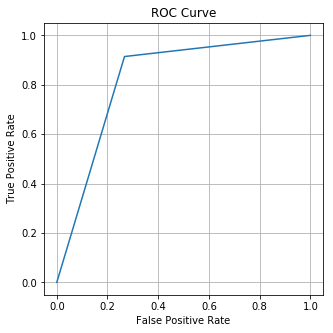

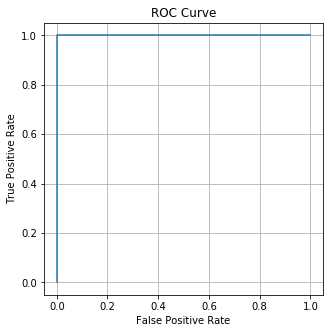

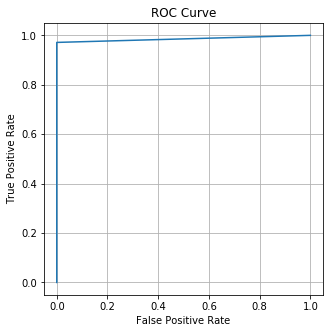

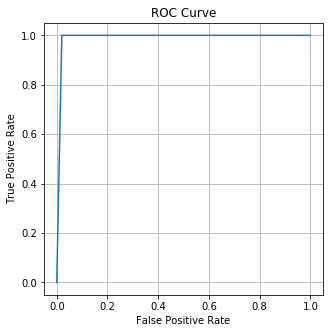

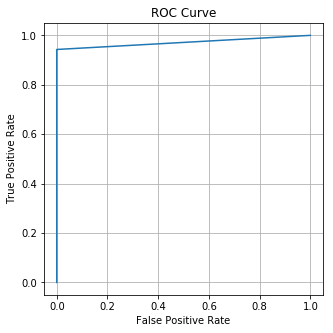

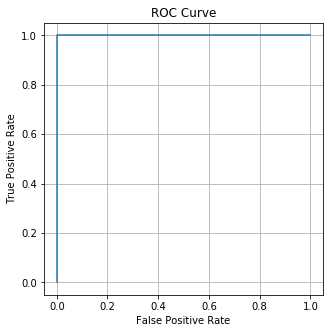

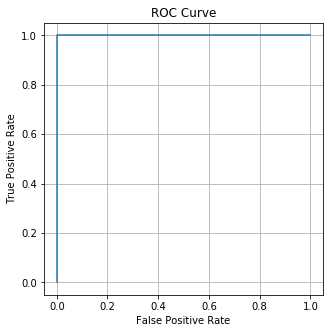

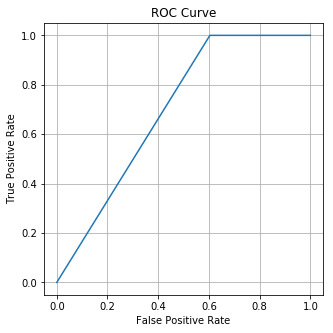

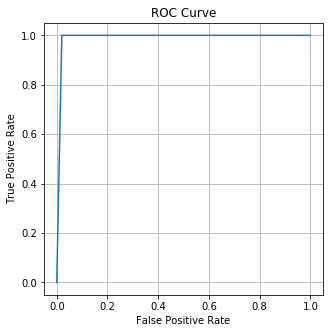

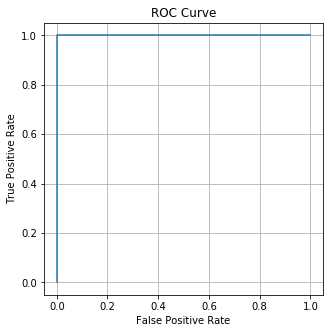

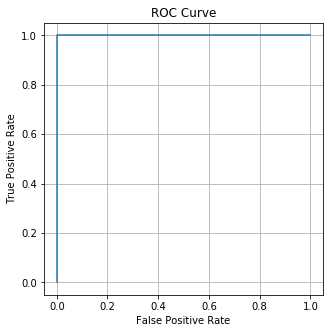

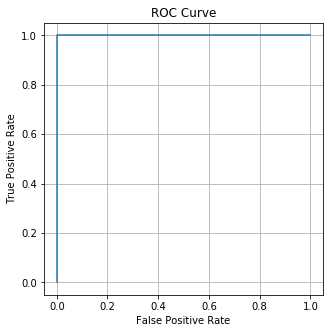

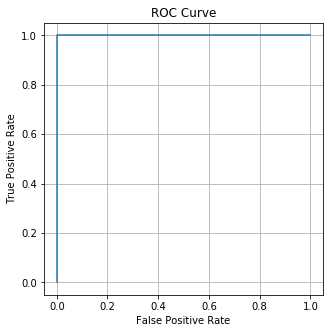

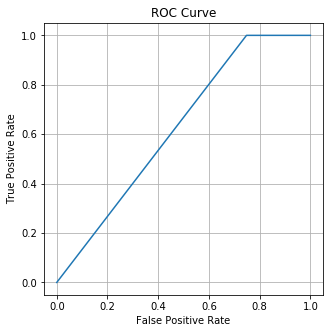

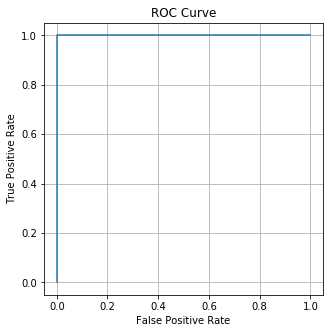

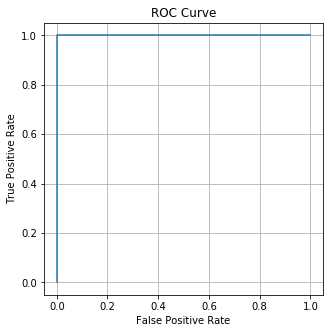

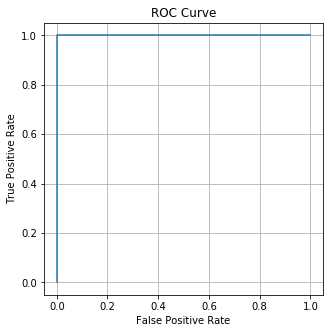

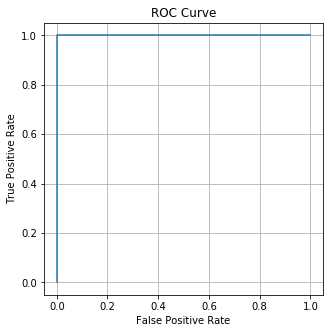

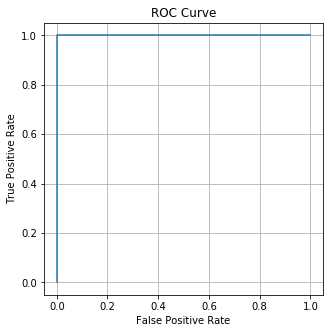

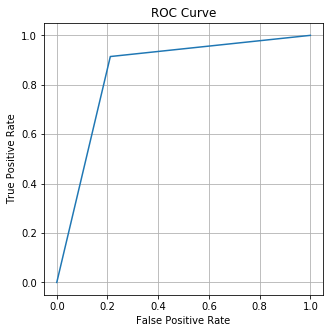

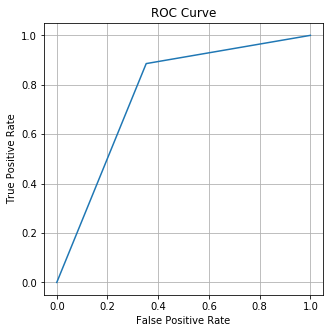

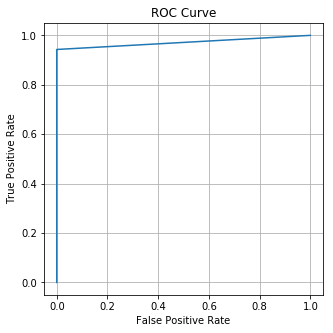

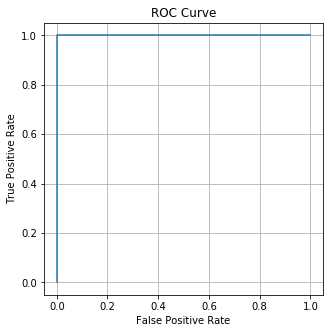

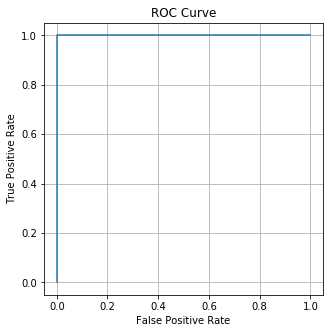

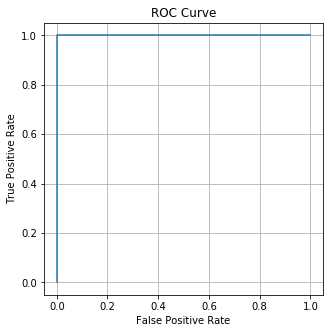

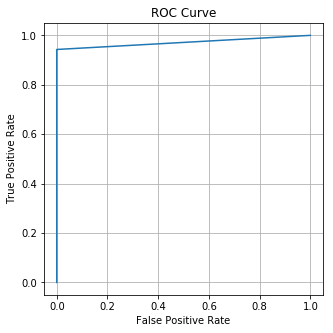

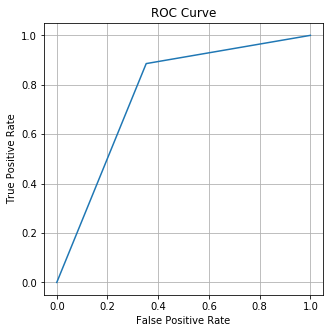

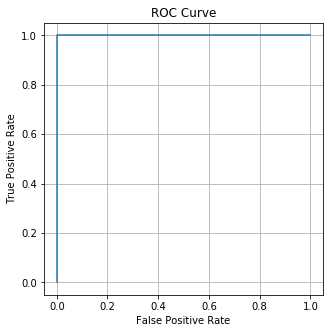

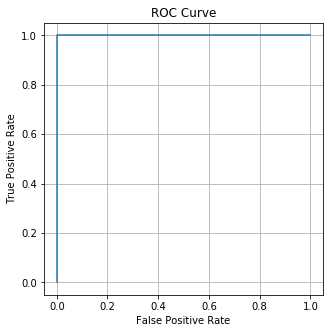

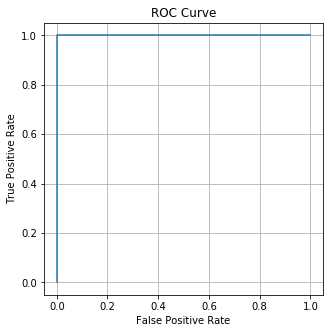

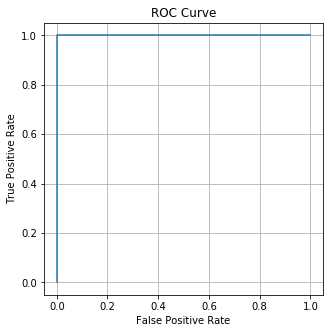

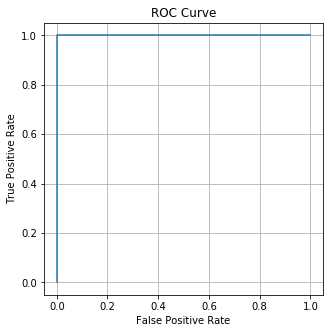

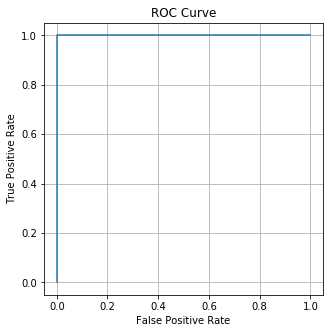

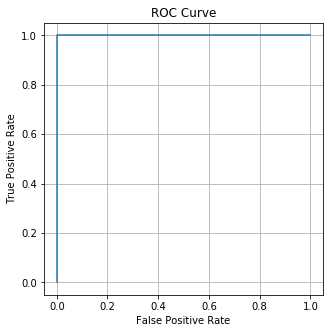

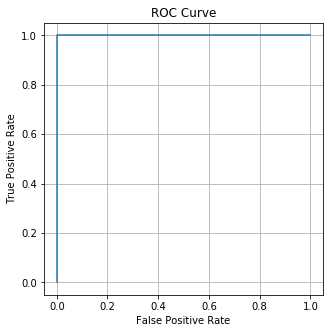

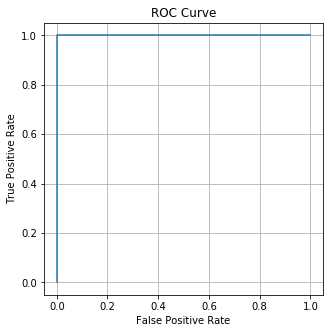

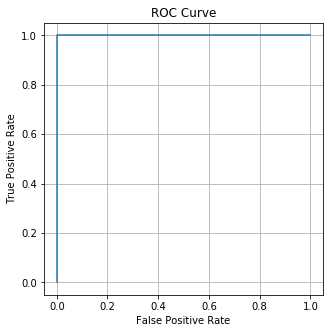

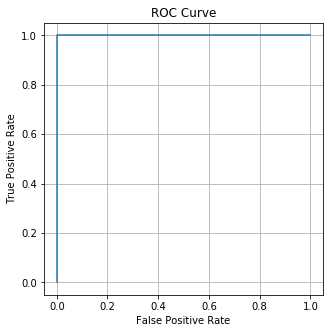

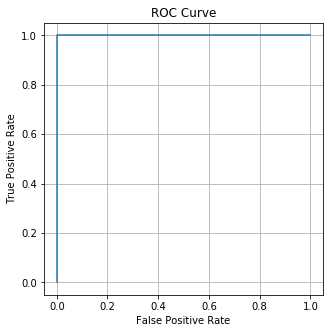

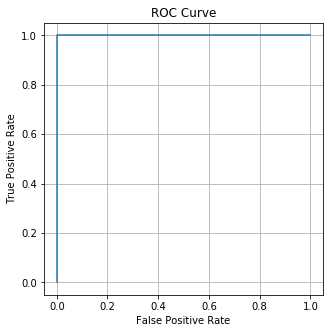

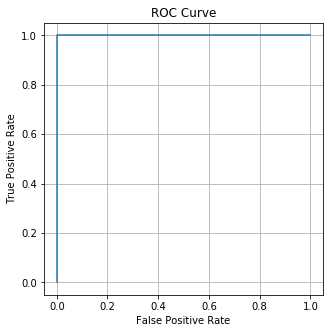

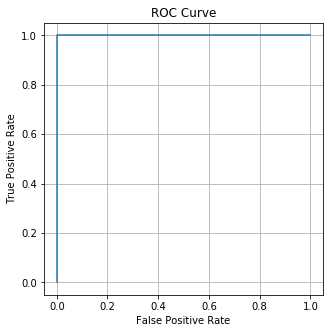

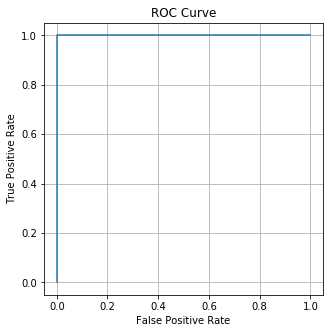

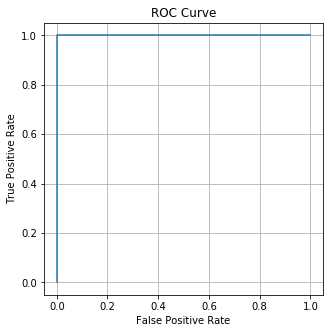

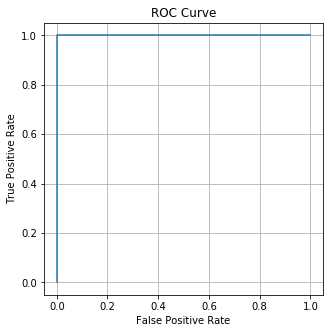

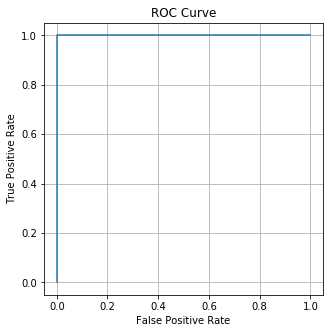

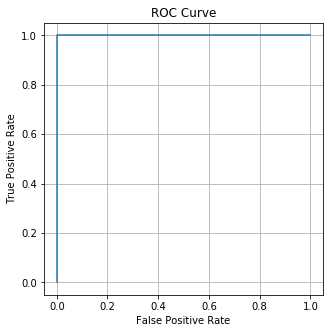

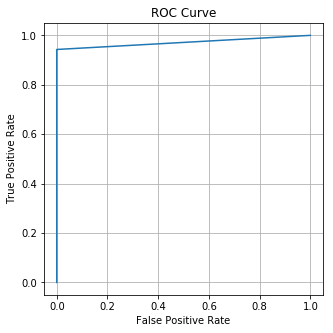

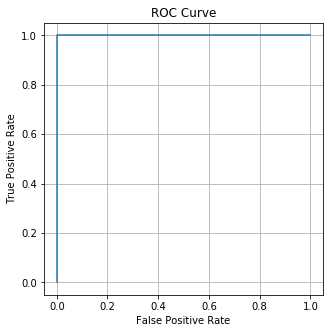

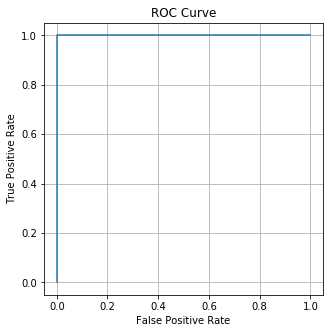

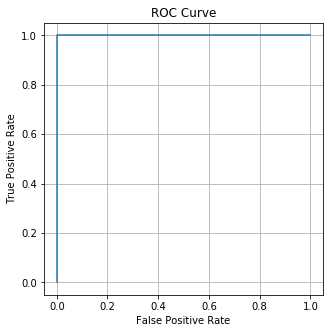

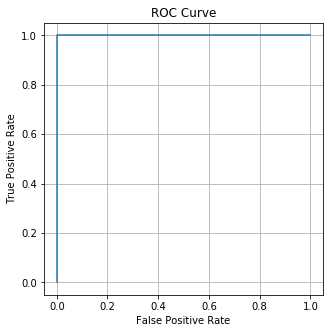

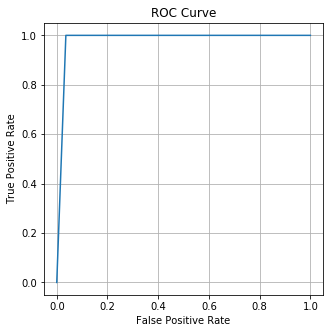

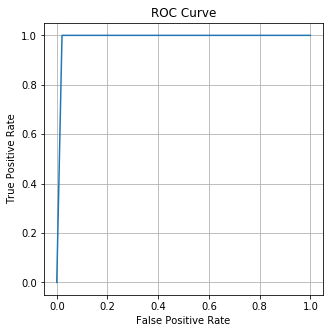

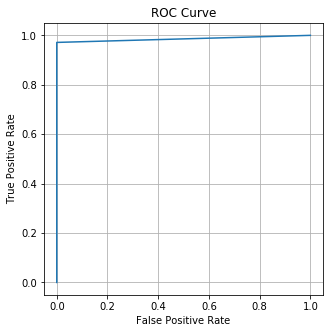

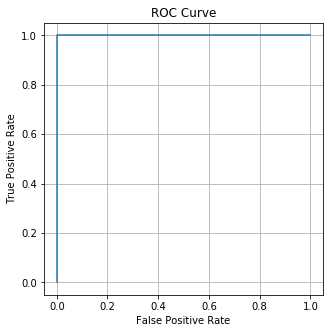

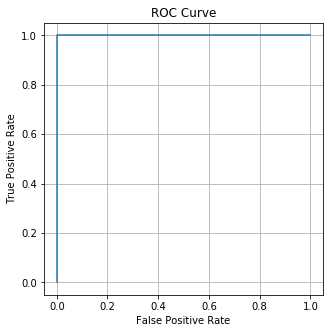

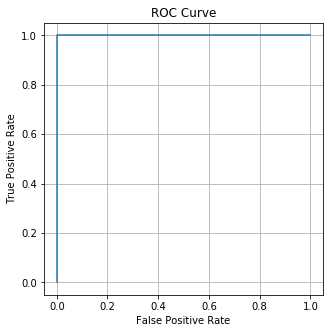

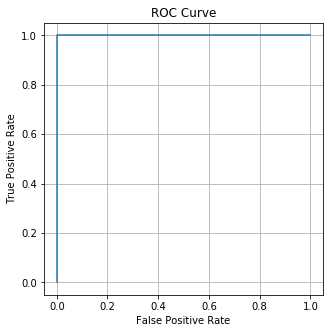

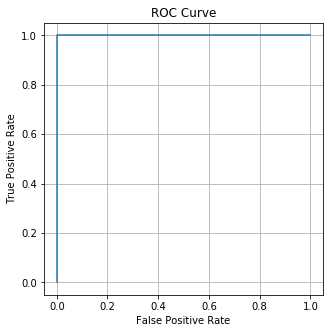

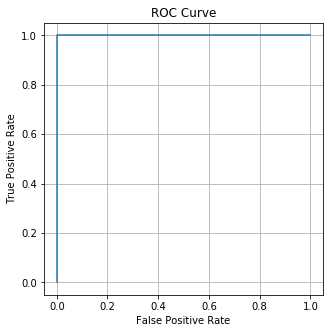

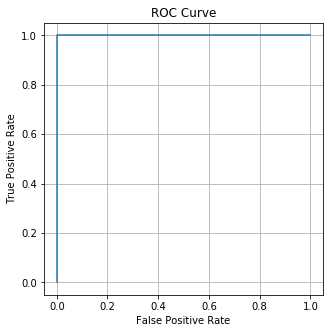

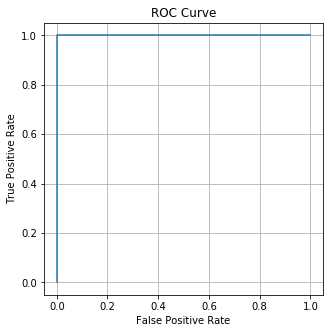

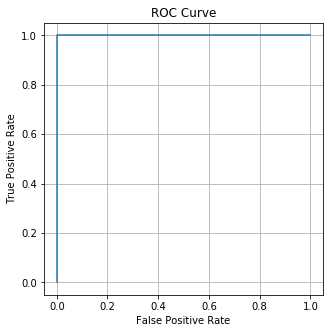

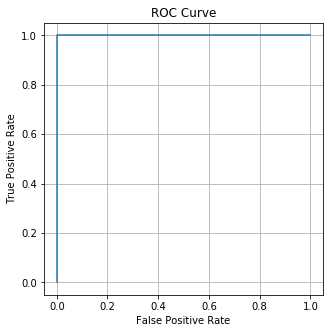

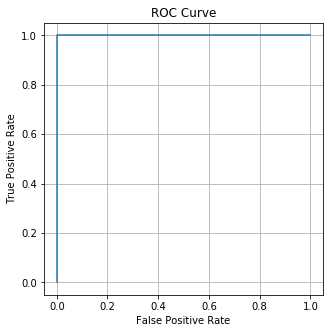

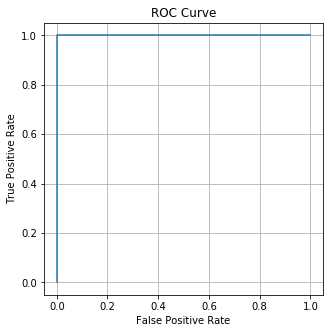

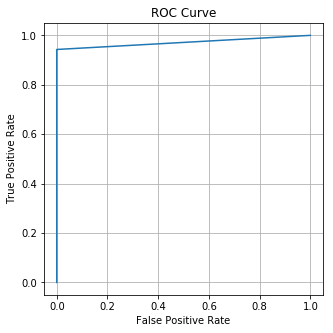

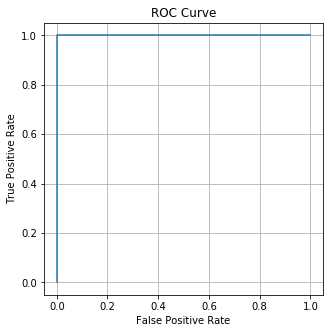

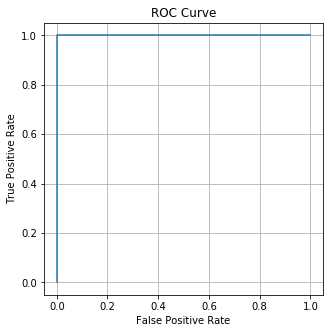

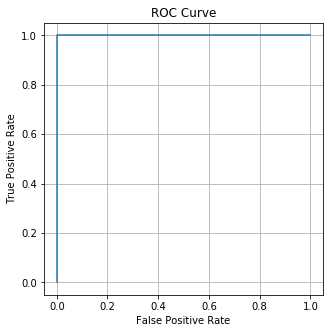

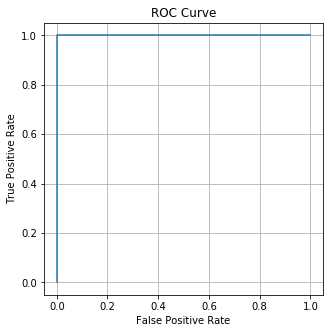

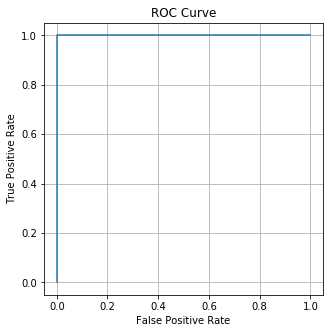

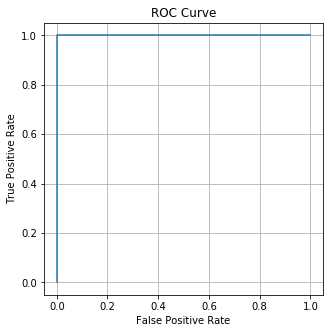

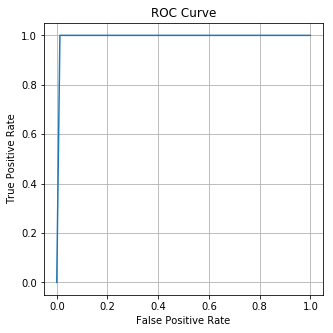

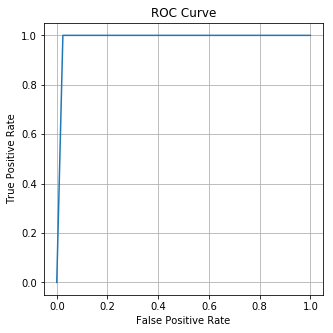

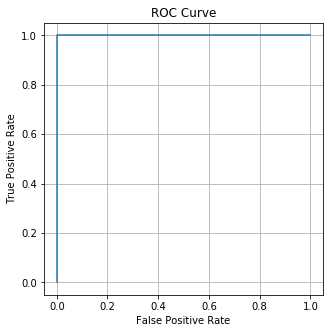

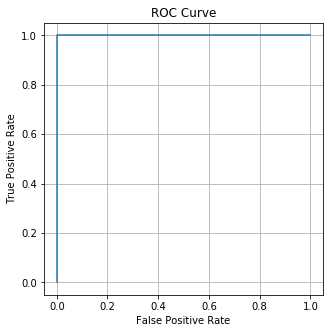

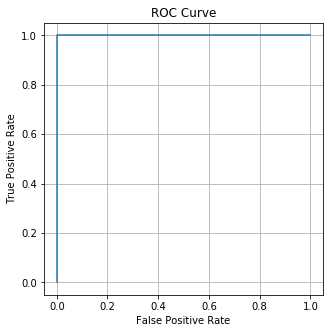

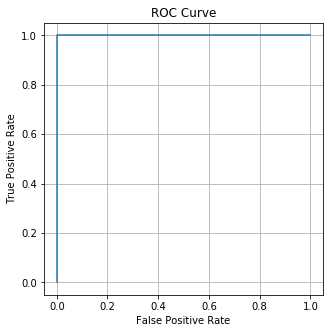

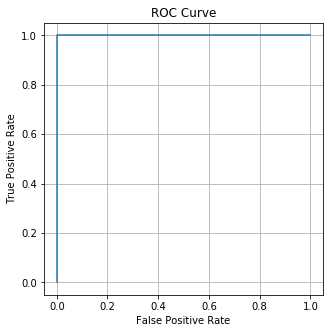

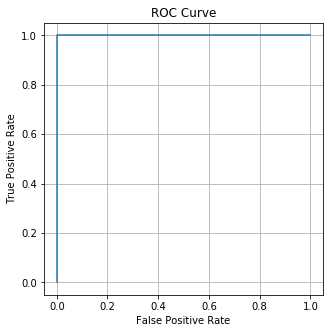

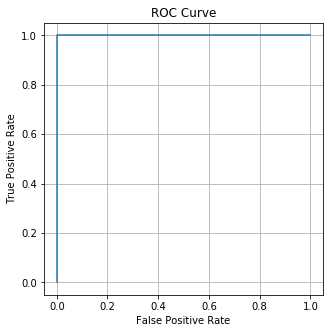

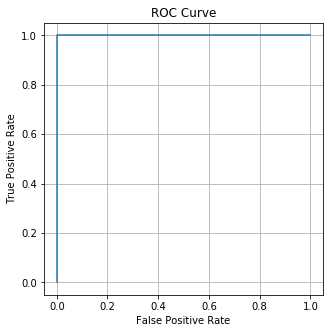

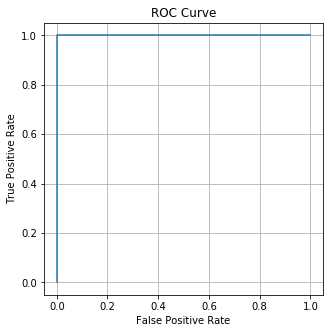

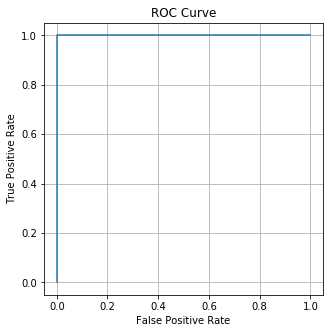

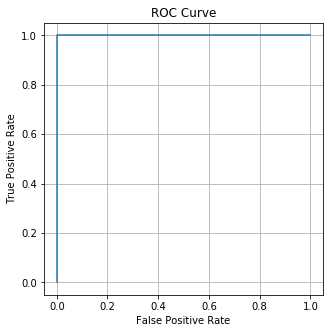

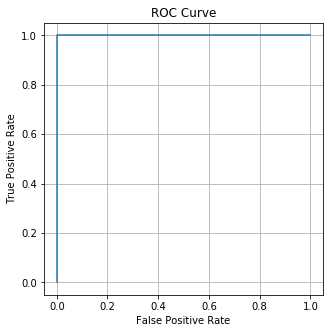

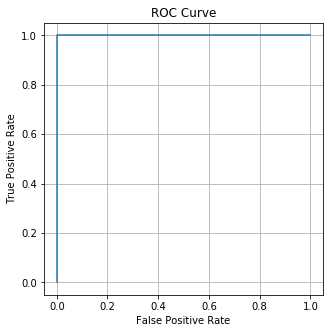

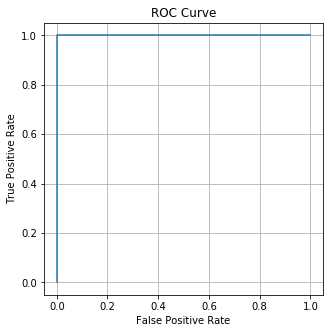

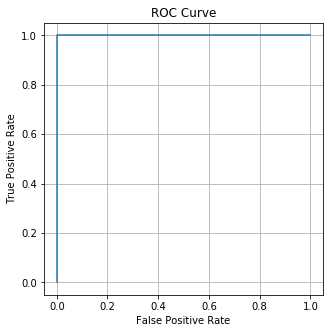

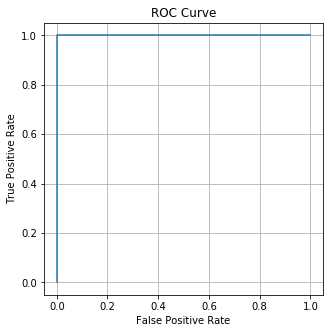

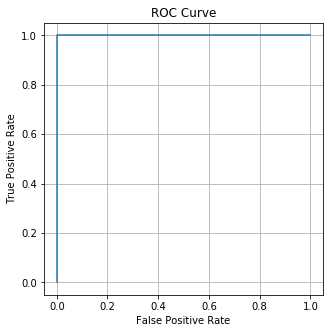

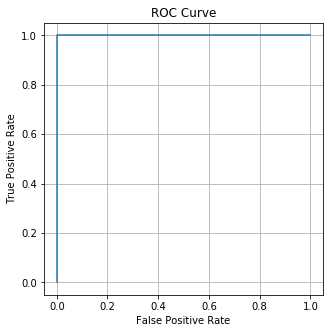

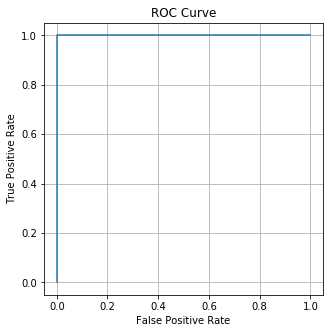

In [136]:
%time de.solve()

[0. 1. 1. 0. 0.]
0.15258800983428955 [0 1 1 1 0 0 1 1]
g_mean:1.0
 tnr:1.0
 recall:1.0
 AUC:1.0
 fbeta:1.0
 precision:1.0


0.0

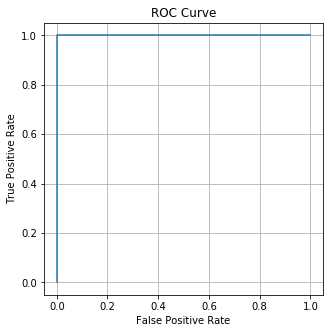

In [137]:
de.fitness(de.X_best)